In [1046]:
import hiplot as hip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import random
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import os
import glob
import uproot3 as uproot
import scipy

from scipy.optimize import curve_fit
import scipy.stats as stats


import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [1047]:
ofolder="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/results/"
os.system("mkdir -p "+ofolder)

0

In [1048]:
def loadDF(fileName,treeName,cols):
    ''' Function to load a root file '''
    tree=uproot.open(fileName)[treeName]
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    return df

def loadDataInCfgFile(cfg):
    ''' Grab the files listed in a amptools config file '''
    keys=["LOOPDATA","LOOPBKGND","LOOPACCMC"]
    dfs={}
    with open(cfg) as c:
        for line in c.readlines():
            if line.startswith("loop") and "root" in line:
                tmp=line.rstrip().lstrip().split(" ")
                df=[]
                for key in keys:
                    if tmp[1]==key:
                        for f in tmp[2:]:
                            d=loadDF(f,"kin",["Weight","AccWeight","Mpi0eta","cosTheta_eta_hel","cosTheta_eta_gj","Mpi0p","Mpi0","Meta"])
                            if key=="LOOPBKGND":
                                d.Weight*=-1
                            df.append(d)
                        dfs[key]=pd.concat(df)
    return dfs


def loadTheory(tbin):
    theory_pred_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/theory_pred/"
    ''' Load the theory curves for the different m-projections '''
    theoryCurves=pd.read_csv(theory_pred_floc+"Waves_bin"+str(tbin)+".txt",sep='  ',
                           names=["D0++", "D1++", "D2++", "D1--", "D0+-", "D1+-"], engine='python')
    theoryCurves=theoryCurves.reset_index()
    theoryCurves.rename(columns={"index":"mass"},inplace=True)
    return theoryCurves

def loadMergedPols(fileName,histBaseName,pols):
    '''
    We use amptools' plotter program to make histograms that were output into separate root files
    Use this function to load the root file and grab the histogram you want ~ integrated over some set of polarizations
    '''
    totalValues=0
    for pol in pols:
        hist=uproot.open(fileName)["EtaPi0_"+pol+"_"+histBaseName]
        edges=hist.edges
        width=edges[1]-edges[0]
        value=hist.values
        totalValues+=value
    return totalValues, edges, width

def relBW(x,particle_mass,width):
    ''' Equation for relativistic breit-wigner'''
    gamma=np.sqrt(particle_mass*particle_mass*(particle_mass*particle_mass+width*width))
    k=2*np.sqrt(2)*particle_mass*width*gamma/np.pi/np.sqrt(particle_mass*particle_mass+gamma)
    return k / ((x*x - particle_mass*particle_mass)**2 + (particle_mass*width)**2)

def constructAltTheory(tbin):
    '''
    Everytime we call this we have to load all 5 t bins since we have to keep the same proportions across t-bins
    '''
    theories=[loadTheory(i).iloc[:,1:].sum() for i in range(1,6)]
    theories=[theory/theories[0]["D2++"] for theory in theories]
    theory_masses=loadTheory(1).mass
    theory_waves=loadTheory(1).iloc[:,1:].columns
    
    mapWaves = {wave:relBW(loadTheory(1).mass,1.3182,0.1134)*theories[tbin-1][wave] for wave in theory_waves}
    mapWaves["mass"]=theory_masses
    mapWaves=pd.DataFrame(mapWaves)
    return mapWaves

def getYield(files):
    ''' Quickly get the yield in an tree by integrating the weights '''
    sums=0
    for file in files:
        tmp=uproot.open(file)["kin"].arrays(["Weight"],outputtype=pd.DataFrame)
        sums+=tmp["Weight"].sum()
    return sums

def combineBR(br1,br2,br3):
    ''' Combine 3 branching ratios by multiplication and propagate their uncertainties '''
    br=br1[0]*br2[0]*br3[0]
    brErr=br*np.sqrt((br1[1]/br1[0])**2+(br2[1]/br2[0])**2+(br3[1]/br3[0])**2)
    return [br,brErr]


#################
def loadFitFractions(files):
    ''' 
    amptools' plotter program can also output yields + acceptance corrected yields
    In the current setup the acceptance corrected yields are normalized by the total corrected
    yield to obtain a fit fraction. We can just multiply by the total yield to get the corrected
    yield in a wave
    '''
    etapi_plotter_ofile="etapi_plotter_output.log"
    waveInts_ts={}
    waveIntErrs_ts={}
    totals=[]
    for file in files:
        fname=file+"/"+etapi_plotter_ofile
        with open(fname) as fin:
            for line in fin:
                if "TOTAL EVENTS" in line:
                    total=float(line.split("=")[1].split("+-")[0].rstrip().lstrip())
                    total_err=float(line.split("=")[1].split("+-")[1].rstrip().lstrip())
                if line.startswith("FIT FRACTION") and "::" not in line:
                    wave=line.split(" ")[2]
#                     if "+" in wave or "-" in wave:
#                         continue
                    waveInt=float(line.split(" ")[4].rstrip().lstrip())
                    waveInt_err=float(line.split(" ")[6].rstrip().lstrip())
                    
                    if wave in waveInts_ts:
                        waveInts_ts[wave].append(waveInt)
                        waveIntErrs_ts[wave].append(waveInt_err)
                    else:
                        waveInts_ts[wave]=[waveInt]
                        waveIntErrs_ts[wave]=[waveInt_err]
        totals.append(total)
    
    waveInts_ts={k:np.array(v) for k,v in waveInts_ts.items()}
    waveIntErrs_ts={k:np.array(v) for k,v in waveIntErrs_ts.items()}
    
    return waveInts_ts, waveIntErrs_ts, totals


def applyCut(df,sectionStr):
    tmp=df
    vars1=sectionStr.split(" ")[::3]
    mins1=[float(x) for x in sectionStr.split(" ")[1::3]]
    maxs1=[float(x) for x in sectionStr.split(" ")[2::3]]
    
    for var1,min1,max1 in zip(vars1,mins1,maxs1):
        if var1[0]=='!':
            var1=var1[1:]
            tmp=tmp[~((tmp[var1]>min1)&(tmp[var1]<max1))]
        else:
            tmp=tmp[((tmp[var1]>min1)&(tmp[var1]<max1))]
    return tmp

## Barlows study

In [1023]:
floc='/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/systematic_nominal_v4/systematic_v16/SOURCE/systematic_syst/barlows.csv'
df=pd.read_csv(floc,dtype={'t':str})

In [1024]:
map_t={
    '010020':r'$0.1<-t<0.2$',
    '0200325':r'$0.2<-t<0.325$',
    '0325050':r'$0.325<-t<0.5$',
    '050075':r'$0.5<-t<0.75$',
    '075100':r'$0.75<-t<1.0$'
}
df['t']=df.t.map(map_t)

In [1025]:
selection=df[(df.variation.apply(lambda x: variations[5] in x))]

In [1026]:
df_significantPos=df[df.nBarlowPos.abs()>4]
df_significantNeg=df[df.nBarlowNeg.abs()>4]

In [1035]:
pd.set_option('max_colwidth', 800)
a=df_significantPos.drop(['nBarlowNeg','diffNeg','negVar','negNom'],axis=1)
a.columns=['t','variable','nominal','variation','nBarlow','difference','yields','status']
print(a.to_latex(escape=False))

a=df_significantNeg.drop(['nBarlowPos','diffPos','posVar','posNom'],axis=1)
a.columns=['t','variable','nominal','variation','nBarlow','difference','yields','status']
print(a.to_latex(escape=False))

\begin{tabular}{lllrrrrrl}
\toprule
{} &               t &                        variable &  nominal &  variation &   nBarlow &  difference &       yields & status \\
\midrule
12  &    $0.1<-t<0.2$ &          $1.04<M(\eta\pi)<1.60$ &  0.20433 &    0.21834 &   5.50005 &     0.01401 &  57831.34375 &      C \\
13  &    $0.1<-t<0.2$ &          $1.04<M(\eta\pi)<1.56$ &  0.20433 &    0.22099 &   9.00976 &     0.01666 &  56287.82324 &      C \\
21  &    $0.1<-t<0.2$ &            $E_{unused}<0.2 GeV$ &  0.20433 &    0.23310 &   6.13178 &     0.02876 &  63037.39941 &      C \\
22  &    $0.1<-t<0.2$ &           $E_{unused}<0.25 GeV$ &  0.20433 &    0.24394 &   4.43727 &     0.03961 &  63370.12598 &      C \\
25  &    $0.1<-t<0.2$ &            $E_{unused}<0.4 GeV$ &  0.20433 &    0.26387 &   4.52807 &     0.05954 &  64303.28418 &      F \\
29  &    $0.1<-t<0.2$ &                     $\chi^2<16$ &  0.20433 &    0.22439 &   7.09780 &     0.02005 &  64679.73828 &      C \\
30  &    $0.1<-t<0.2$ &  

In [1028]:
variations=[
    '\\theta_{\\gamma,beam}',
    '\\theta_{\\gamma,trans}',
    'E_{\\gamma}',
    'z_{proton}',
    '|MMsq|',
    'M(\\eta\\pi)',
    'M(\\pi p)',
    'E_{unused}',
    '\\chi^2'
]
variation=variations[0]
t='010020'
selection=df[(df.variation.apply(lambda x: variation in x))&(df.t==t)]
selection

Empty DataFrame
Columns: [t, variation, posNom, negNom, posVar, negVar, nBarlowPos, diffPos, nBarlowNeg, diffNeg, yields, status]
Index: []

## Draw Dataframe for waveset scan

In [818]:
floc='/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/systematic_nominal_v4/systematic_v16/SOURCE/fit_quality.csv'
df=pd.read_csv(floc)

In [819]:
df['extraDOF']=df.file.apply(lambda x: len(x.split("_")))*4
df.loc[df.file=='nominal','extraDOF']=0
df=df.drop('shiftedMinimum',axis=1)

In [822]:
floc='/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/systematic_nominal_v4/systematic_v16/010020_nominal/fit.log'
with open(floc) as f:
    lines=f.readlines()
    lines=[line for line in lines if "Weight Integral" in line]
    
lines=list(set(lines))

datalines=[float(line.split(" ")[-1].rstrip()) for line in lines if "DTOT" in line and "data" in line]
bkgndlines=[float(line.split(" ")[-1].rstrip()) for line in lines if "DTOT" in line and "bkgnd" in line]
accmclines=[float(line.split(" ")[-1].rstrip()) for line in lines if "FTOT" in line and "acc" in line]
genmclines=[float(line.split(" ")[-1].rstrip()) for line in lines if "FTOT" in line and "gen" in line]

print(f'data integrals: {datalines}')
print(f'bkgnd integrals: {bkgndlines}')
print(f'accmc integrals: {accmclines}')
print(f'genmc integrals: {genmclines}')

integral=sum(datalines)-sum(bkgndlines)+4*sum(accmclines)
print(f'integral {integral}')

data integrals: [28154.0, 26952.0, 26983.0, 27509.0]
bkgnd integrals: [11544.009766, 12075.111328, 12012.001953, 12191.680664]
accmc integrals: [532717.5625]
genmc integrals: [4261403.0]
integral 2192645.446289


In [823]:
reference='nominal'
delta_nll=df['bestMinimum']-df.loc[df.file==reference,'bestMinimum'].iloc[0]
delta_dof=df['extraDOF']-df.loc[df.file==reference,'extraDOF'].iloc[0]
df['delta_aic']=2*delta_dof+2*delta_nll # there is a plus between the terms since amptools outputs NLL not LL
df['delta_bic']=np.log(integral)*delta_dof+2*delta_nll
df['shiftedMinimum']=delta_nll

df[(df.extraDOF<=32)]

## STUDY OF T ACCEPTANCE

In [1049]:
faccs=[
    "rootFiles/F2017_1_selected_acc_flat.root",
    "rootFiles/F2018_1_selected_acc_flat.root",
    "rootFiles/F2018_8_selected_acc_flat.root"
   ]

faccs2=[]
for f in faccs:
    faccs2.append(loadDF("/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/"+f,"kin",
                         cols=["Mpi0eta","mandelstam_t","Mpi0eta_thrown","mandelstam_t_thrown","weightASBS"]))
faccs2=pd.concat(faccs2)
faccs2=faccs2.reset_index()

# fgens=["rootFiles/t010020_m104180/polALL_t010020_m104180_FTOT_gen_data_flat.root",
#    ]

# fgens2=[]
# for f in fgens:
#     fgens2.append(loadDF("/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/"+f,"kin",
#                          cols=["Mpi0eta_thrown","mandelstam_t_thrown"]))
# fgens2=pd.concat(fgens2)
# fgens2=fgens2.reset_index()


# a=faccs2[
#     (faccs2.Mpi0eta>1.04)&(faccs2.Mpi0eta<1.56)&
#     (faccs2.mandelstam_t>0.1)&(faccs2.mandelstam_t<0.15)&
#     (faccs2.Mpi0eta_thrown>1.04)&(faccs2.Mpi0eta_thrown<1.56)
#         ]

# g=fgens2[
#     (fgens2.Mpi0eta_thrown>1.04)&(fgens2.Mpi0eta_thrown<1.56)
# ]

# ac,edges=np.histogram(a.mandelstam_t,weights=a.weightASBS,bins=100)
# gc,_=np.histogram(g.mandelstam_t_thrown,bins=edges)


# ###################################
# #### Include selection on thrown t
# ###################################

# plt.figure(figsize=(10,6))
# hep.histplot((ac/gc,edges),label="recon t=[0.1,0.15]")

# a2=a[
#     (a.mandelstam_t_thrown>0.1)&(a.mandelstam_t_thrown<0.15)
# ]

# g=g[
#     (g.mandelstam_t_thrown>0.1)&(g.mandelstam_t_thrown<0.15)
# ]

# ac,_=np.histogram(a2.mandelstam_t,weights=a2.weightASBS,bins=edges)
# gc,_=np.histogram(g.mandelstam_t_thrown,bins=edges)

# hep.histplot((ac/gc,edges),label="recon & thrown t=[0.1,0.15]")
# plt.xlabel(r"$-t GeV^2$",size=28)
# plt.ylabel("Acceptance",size=28)
# plt.legend(prop={"size":24})

Text(0.5, 1.0, 'Artificial Steps From Sampler')

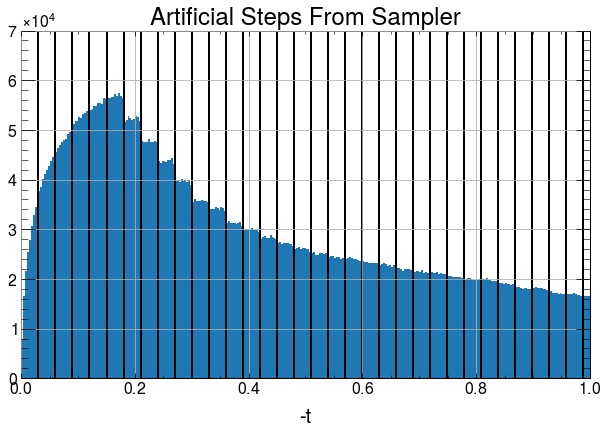

In [1050]:
ds=[5.078462993309374807e-04,
3.045287258403528430e-02,
6.039789886873962732e-02,
9.034292515344398422e-02,
1.202879514381483272e-01,
1.502329777228526564e-01,
1.801780040075570133e-01,
2.101230302922613424e-01,
2.400680565769656993e-01,
2.700130828616700285e-01,
2.999581091463743854e-01,
3.299031354310787423e-01,
3.598481617157830992e-01,
3.897931880004874561e-01,
4.197382142851917575e-01,
4.496832405698961144e-01,
4.796282668546004713e-01,
5.095732931393048837e-01,
5.395183194240091851e-01,
5.694633457087135975e-01,
5.994083719934178989e-01,
6.293533982781223113e-01,
6.592984245628266127e-01,
6.892434508475309141e-01,
7.191884771322353265e-01,
7.491335034169396279e-01,
7.790785297016440403e-01,
8.090235559863483417e-01,
8.389685822710526431e-01,
8.689136085557570555e-01,
8.988586348404613569e-01,
9.288036611251657693e-01,
9.587486874098700707e-01,
9.886937136945743720e-01]

plt.figure(figsize=(10,6))
raw=loadDF("/d/grid17/ln16/dselector_v3/phase1_selected/F2017_1_gen_data_flat.root","kin",cols=["Mpi0eta_thrown","mandelstam_t_thrown"])
raw[raw.mandelstam_t_thrown<1.0].mandelstam_t_thrown.hist(bins=300)
[plt.axvline(d,c='black') for d in ds]
plt.xlabel("-t")
plt.title("Artificial Steps From Sampler",size=24)

## --- END ABOVE STUDY ----

## CHARGED CHANNEL XSEC

Text(0, 0.5, '$d\\sigma/dt~(\\mu b/GeV^2)$')

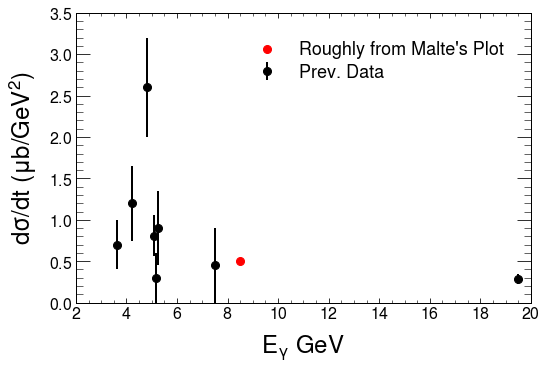

In [1092]:
eg=[3.625, 4.2, 4.8, 5.1, 5.15, 5.25, 7.5, 19.5]
a2c_xsec=[0.7, 1.2, 2.6,0.81,0.3,0.9,0.45,0.29]
a2c_xsec_err=[0.3,0.45,0.6,0.25,0.3,0.45,0.45,0.06]

plt.figure(figsize=(8,5))
plt.errorbar(eg,a2c_xsec,yerr=a2c_xsec_err,fmt='o',c='black',label="Prev. Data")
plt.ylim(0)
plt.scatter([8.5],[0.5],c='red',label="Roughly from Malte's Plot")
plt.legend(prop={"size":18})
plt.xlabel("$E_{\gamma}~GeV$",size=24)
plt.ylabel(r"$d\sigma/dt~(\mu b/GeV^2)$",size=24)

In [1067]:
a2c_xsec_pred_ope=[[0.020000000000000462, 2.835882104403453],
[0.0600000000000005, 2.448032641539203],
[0.09333333333333371, 2.112704268094782],
[0.12666666666666693, 1.8233087454338301],
[0.16666666666666696, 1.57394389473918],
[0.22666666666666657, 1.3596929953167924],
[0.28000000000000025, 1.2187481753273908],
[0.33333333333333304, 1.0525871516388239],
[0.3866666666666667, 0.9791747708979212],
[0.4400000000000004, 0.8776742025360055],
[0.4933333333333332, 0.8164610738912905],
[0.54, 0.7593292114277592],
[0.5933333333333337, 0.7330967434969904],
[0.6400000000000006, 0.6817982999321116],
[0.6866666666666665, 0.6580813300086397],
[0.7333333333333334, 0.6351893763141704],
[0.7866666666666671, 0.5908882804249125],
[0.8466666666666676, 0.5498130626677786],
[0.913333333333334, 0.5310816432030906],
[0.9733333333333327, 0.4941638452638647],
[1.0266666666666673, 0.4770920178820959],
[1.086666666666667, 0.4781563112624202],
[1.1333333333333337, 0.46152321192195767],
[1.1866666666666665, 0.4455790171328707],
[1.2400000000000002, 0.43018564479627486],
[1.286666666666667, 0.41522124843424396],
[1.3399999999999999, 0.40087664280101126]]


a2c_xsec_pred_vmd=[[0.020000000000000462, 6.983707179489598],
[0.1466666666666674, 2.3465515938493473],
[0.27333333333333343, 0.9852544092107977],
[0.413333333333334, 0.4466835921509612],
[0.5466666666666669, 0.2527482585986258],
[0.6933333333333334, 0.14336779733411148],
[0.8200000000000003, 0.08726904331596591],
[0.9600000000000009, 0.053253000895755964],
[1.0933333333333328, 0.032455650842053964],
[1.246666666666667, 0.01985406605090928],
[1.3800000000000008, 0.012100287771665169],
[1.5199999999999996, 0.007953121814603063],
[1.666666666666666, 0.0052338009814747065],
[1.8133333333333335, 0.003444266710889397],
[1.9400000000000004, 0.002258205396216302]]



malte_xsec=[ [0.15004678118215595, 1.5732647814910026],
[0.2488895146565898, 1.089974293059126],
[0.3509015596755294, 0.6272493573264781],
[0.4473925168276, 0.5809768637532133],
[0.6278307157066684, 0.15424164524421569],
[0.8726988654427862, 0.16966580976863743] ]

a2c_xsec_e_ope, a2c_xsec_pred_ope = np.array(a2c_xsec_pred_ope).T
a2c_xsec_e_vmd, a2c_xsec_pred_vmd = np.array(a2c_xsec_pred_vmd).T
a2c_malte_e, a2c_malte_pred = np.array(malte_xsec).T

Text(0, 0.5, '$d\\sigma/dt~(\\mu b/GeV^2)$')

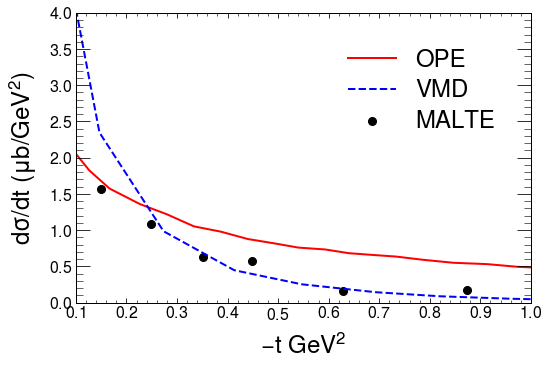

In [1087]:
plt.figure(figsize=(8,5))
plt.plot(a2c_xsec_e_ope, a2c_xsec_pred_ope, c='red',label="OPE")
plt.plot(a2c_xsec_e_vmd, a2c_xsec_pred_vmd, c='blue',linestyle='--',label="VMD")
plt.scatter(a2c_malte_e, a2c_malte_pred, c='black',label="MALTE")
plt.ylim(0,4)
plt.xlim(0.1,1.0)
plt.legend(prop={"size":24})
plt.xlabel("$-t~GeV^2$",size=24)
plt.ylabel(r"$d\sigma/dt~(\mu b/GeV^2)$",size=24)

## --- END ABOVE STUDY ----

In [5]:
c_rec=["Mpi0eta","Meta","Mpi0","mandelstam_t","Ebeam",
       "weightASBS","AccWeight","weightBSpi0","weightBSeta",
       "cosTheta_eta_hel","phi_eta_hel","Metap",
       "Mpi0p","vanHove_omega",'rfTime',
      'proton_z','proton_momentum','unusedEnergy','pVH','chiSq','photonTheta1','photonTheta2','photonTheta3','photonTheta4',
      'photonE1','photonE2','photonE3','photonE4','mmsq','Phi']

dat_df=[]
acc_df=[]
b1_df=[]
for run in ["2017_1","2018_1","2018_8"]:
    dat_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected_v4/D"+run+"_selected_acc_flat.root","kin",cols=c_rec))
    acc_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected_v4/F"+run+"_selected_acc_flat.root","kin",cols=c_rec))
    b1_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected_v4/BOne"+run+"_selected_acc_flat.root","kin",cols=c_rec))
dat_df=pd.concat(dat_df)
dat_df=dat_df.reset_index(drop=True)
acc_df=pd.concat(acc_df)
acc_df=acc_df.reset_index(drop=True)
b1_df=pd.concat(b1_df)
b1_df=b1_df.reset_index(drop=True)

def f(x,a,b,c,d):
    return a*np.arctan(b*x+c)+d
args2=(-29.5,-1.05,2.78,328)

In [108]:
f2_df=[]
eta_df=[]
etap_df=[]
a2pi_df=[]
f1_df=[]
for run in ["2017_1"]:
    f2_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected_v4/FTwo"+run+"_selected_acc_flat.root","kin",cols=c_rec))
    eta_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected_v4/eta6g"+run+"_selected_acc_flat.root","kin",cols=c_rec))
    etap_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected_v4/etap6g"+run+"_selected_acc_flat.root","kin",cols=c_rec))
    a2pi_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected_v4/a2pi6g"+run+"_selected_acc_flat.root","kin",cols=c_rec))
    f1_df.append(loadDF("/d/grid17/ln16/dselector_v3/phase1_selected_v4/fOne6g"+run+"_selected_acc_flat.root","kin",cols=c_rec))
f2_df=pd.concat(f2_df)
f2_df=f2_df.reset_index(drop=True)
eta_df=pd.concat(eta_df)
eta_df=eta_df.reset_index(drop=True)
etap_df=pd.concat(etap_df)
etap_df=etap_df.reset_index(drop=True)
a2pi_df=pd.concat(a2pi_df)
a2pi_df=a2pi_df.reset_index(drop=True)
f1_df=pd.concat(f1_df)
f1_df=f1_df.reset_index(drop=True)

In [36]:
# nominal='Mpi0eta 1.04 1.72 pVH 0.5 999 unusedEnergy -999 0.01 chiSq -999 13.277 \
# !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
# !photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
# photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
# proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'
selection='Mpi0eta 1.04 1.72 pVH 0.5 999 mandelstam_t 0.1 0.2 !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
!photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'

dat_df_2=dat_df
dat_df_2=applyCut(dat_df_2,selection)
acc_df_2=acc_df
acc_df_2=applyCut(acc_df_2,selection)
b1_df_2=b1_df
b1_df_2=applyCut(b1_df_2,selection)

In [109]:
f2_df_2=f2_df
f2_df_2=applyCut(f2_df_2,selection)
eta_df_2=eta_df
eta_df_2=applyCut(eta_df_2,selection)
etap_df_2=etap_df
etap_df_2=applyCut(etap_df_2,selection)
a2pi_df_2=a2pi_df
a2pi_df_2=applyCut(a2pi_df_2,selection)
f1_df_2=f1_df
f1_df_2=applyCut(f1_df_2,selection)

### What causes the weird looking acceptance?


In [6]:
##### What causes the weird looking acceptance?
selection='Mpi0eta 1.04 1.72 pVH 0.5 999 photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'

acc_df_3=acc_df
acc_df_3=applyCut(acc_df_3,selection)

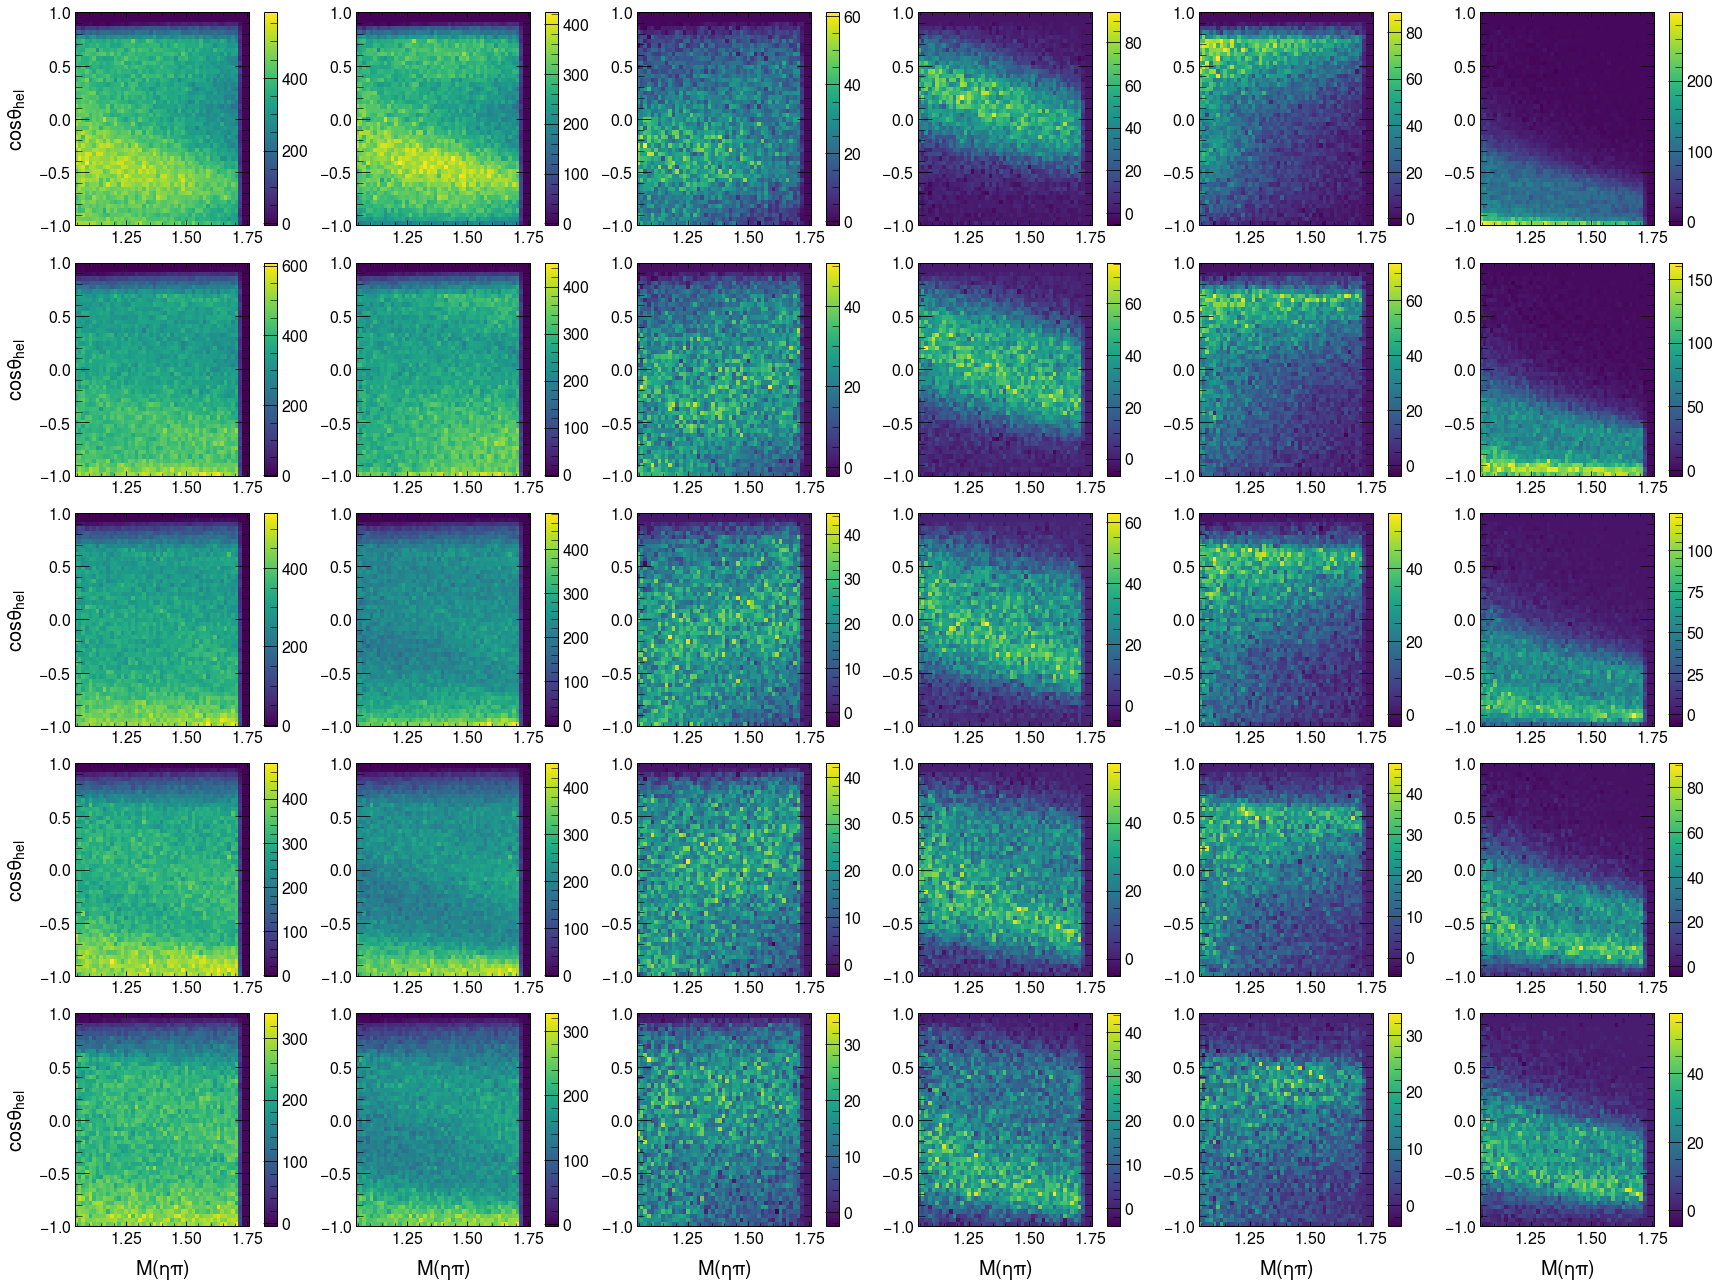

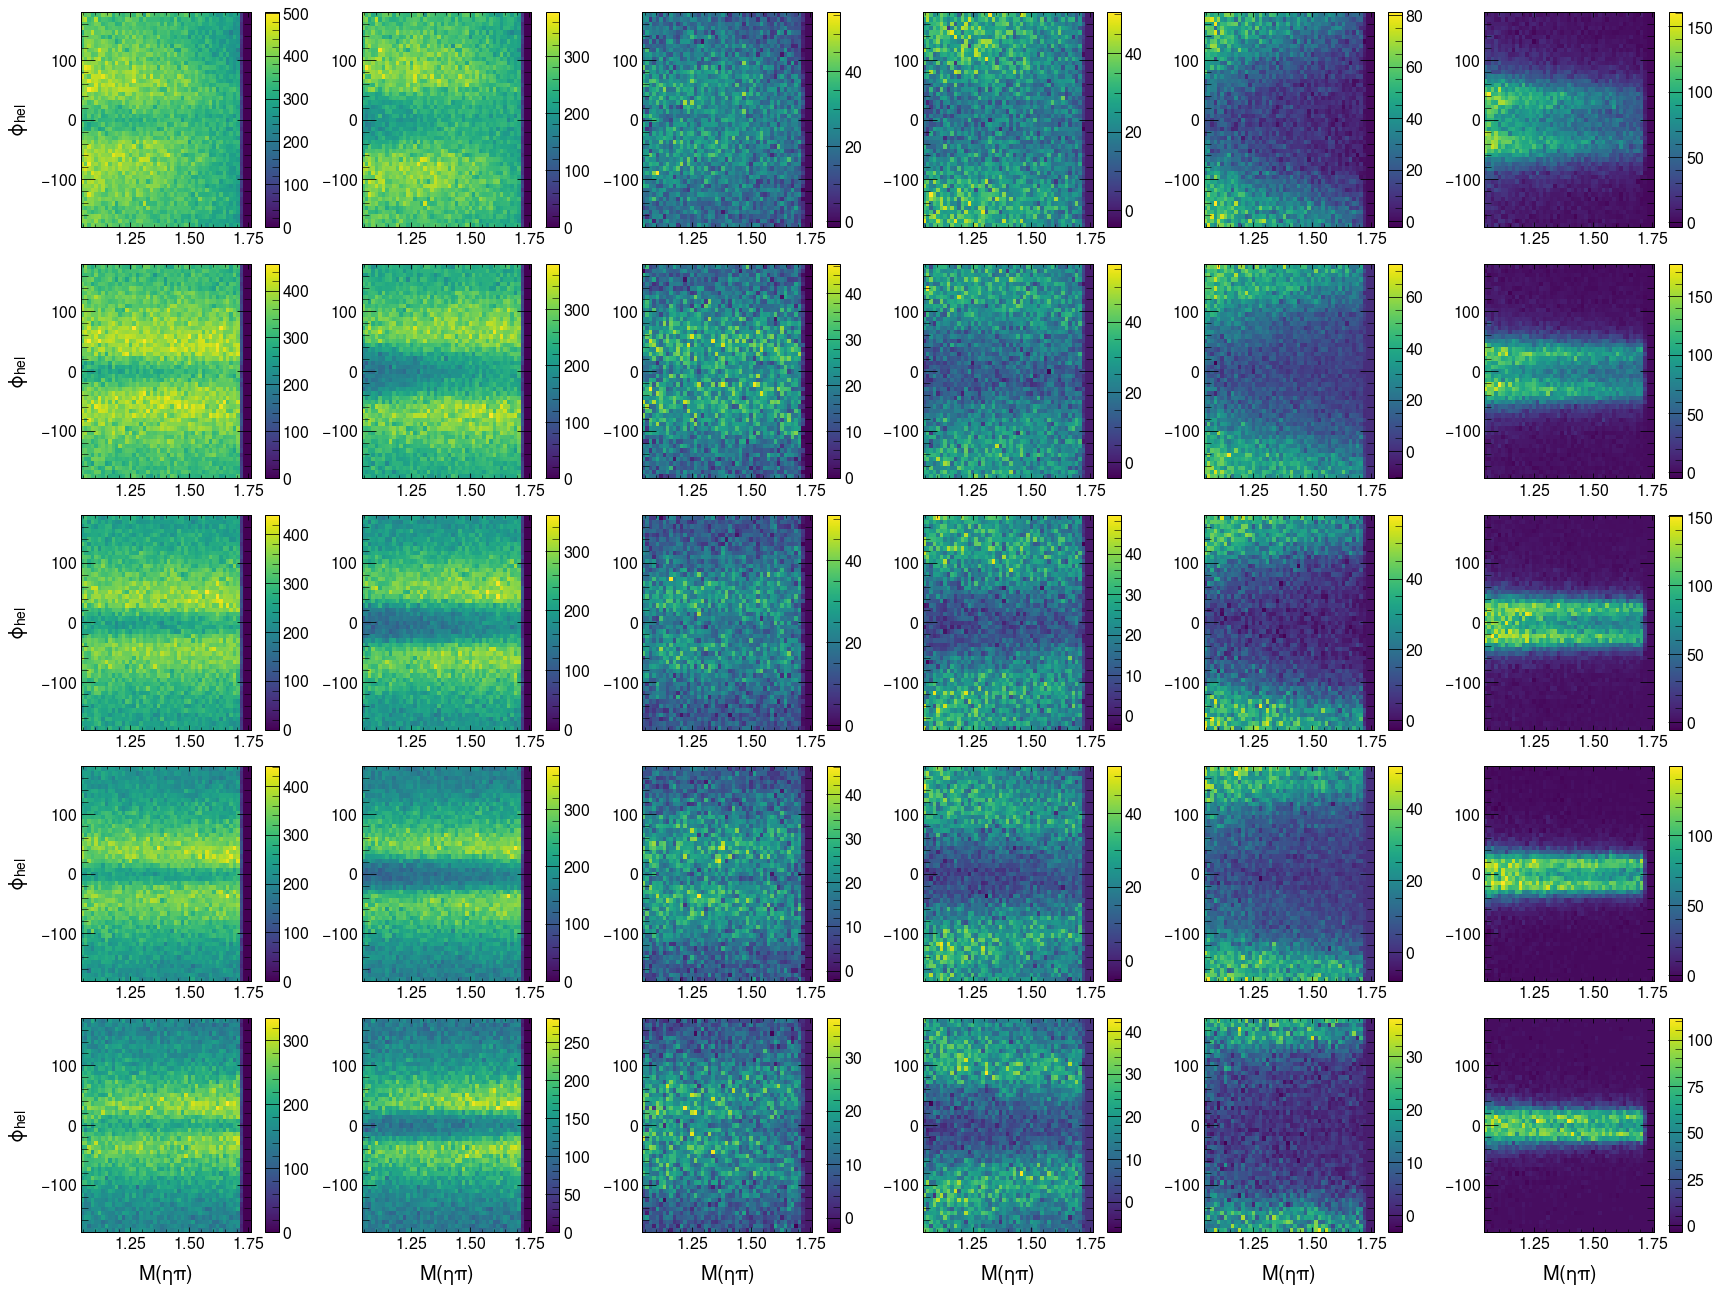

In [7]:
edges=(np.linspace(1.04,1.76,50),np.linspace(-1,1,50))

transL=10.3
transU=11.9
beamU=2.5
dfs=[
    acc_df_3,
    applyCut(acc_df_3,
             f'!photonTheta1 -999 {beamU} !photonTheta1 {transL} {transU} !photonTheta2 -999 {beamU} !photonTheta2 {transL} {transU} !photonTheta3 -999 {beamU} !photonTheta3 {transL} {transU} !photonTheta4 -999 {beamU} !photonTheta4 {transL} {transU}'),
    acc_df_3[((acc_df_3.photonTheta3>transL)&(acc_df_3.photonTheta3<transU))|((acc_df_3.photonTheta4>transL)&(acc_df_3.photonTheta4<transU))],
    acc_df_3[((acc_df_3.photonTheta1>transL)&(acc_df_3.photonTheta1<transU))|((acc_df_3.photonTheta2>transL)&(acc_df_3.photonTheta2<transU))],
    acc_df_3[(acc_df_3.photonTheta3<beamU)|(acc_df_3.photonTheta4<beamU)],
    acc_df_3[(acc_df_3.photonTheta1<beamU)|(acc_df_3.photonTheta2<beamU)]
]

fig,axes=plt.subplots(5,6,figsize=(24,18))
for i, df in enumerate(dfs):
    for tmin,tmax,j in zip([0.1,0.2,0.325,0.5,0.75],[0.2,0.325,0.5,0.75,1.0],range(5)):
        tmp=df[(df.mandelstam_t<tmax)&(df.mandelstam_t>tmin)]
        out=np.histogram2d(tmp.Mpi0eta,tmp.cosTheta_eta_hel,weights=tmp.weightASBS,bins=edges)
        hep.hist2dplot(out,ax=axes[j,i],cbar=True)

[axes[4,i].set_xlabel(r"$M(\eta\pi)$") for i in range(6)]
[axes[i,0].set_ylabel(r"$cos\theta_{hel}$") for i in range(5)]
plt.tight_layout()


edges=(np.linspace(1.04,1.76,50),np.linspace(-180,180,50))
fig,axes=plt.subplots(5,6,figsize=(24,18))
for i, df in enumerate(dfs):
    for tmin,tmax,j in zip([0.1,0.2,0.325,0.5,0.75],[0.2,0.325,0.5,0.75,1.0],range(5)):
        tmp=df[(df.mandelstam_t<tmax)&(df.mandelstam_t>tmin)]
        out=np.histogram2d(tmp.Mpi0eta,tmp.phi_eta_hel,weights=tmp.weightASBS,bins=edges)
        hep.hist2dplot(out,ax=axes[j,i],cbar=True)

[axes[4,i].set_xlabel(r"$M(\eta\pi)$") for i in range(6)]
[axes[i,0].set_ylabel(r"$\phi_{hel}$") for i in range(5)]
plt.tight_layout()


### understand UE and chiSq systematics

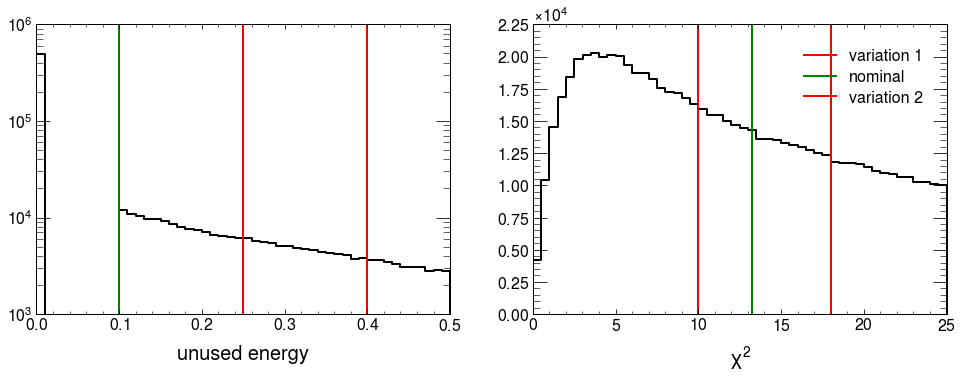

In [8]:
fig,axes=plt.subplots(1,2,figsize=(16,5))
hep.histplot(np.histogram(dat_df_2.unusedEnergy,bins=50),ax=axes[0],c='black')
axes[0].set_yscale("log")
axes[0].axvline(0.25,c='red')
axes[0].axvline(0.1,c='green')
axes[0].axvline(0.4,c='red')
hep.histplot(np.histogram(dat_df_2.chiSq,bins=50),ax=axes[1],c='black')
axes[0].set_xlabel("unused energy")
axes[1].set_xlabel(r"$\chi^2$")
axes[1].axvline(10,c='red',label='variation 1')
axes[1].axvline(13.27,c='green',label='nominal')
axes[1].axvline(18,c='red',label='variation 2')
axes[1].legend()

In [37]:
dat_df_2=dat_df_2[(dat_df_2.unusedEnergy<0.4)&(dat_df_2.chiSq<18)]
acc_df_2=acc_df_2[(acc_df_2.unusedEnergy<0.4)&(acc_df_2.chiSq<18)]
b1_df_2=b1_df_2[(b1_df_2.unusedEnergy<0.4)&(b1_df_2.chiSq<18)]

In [110]:
f2_df_2=f2_df_2[(f2_df_2.unusedEnergy<0.4)&(f2_df_2.chiSq<18)]
eta_df_2=eta_df_2[(eta_df_2.unusedEnergy<0.4)&(eta_df_2.chiSq<18)]
etap_df_2=etap_df_2[(etap_df_2.unusedEnergy<0.4)&(etap_df_2.chiSq<18)]
a2pi_df_2=a2pi_df_2[(a2pi_df_2.unusedEnergy<0.4)&(a2pi_df_2.chiSq<18)]
f1_df_2=f1_df_2[(f1_df_2.unusedEnergy<0.4)&(f1_df_2.chiSq<18)]

In [541]:
def makePlot(df11,df12,df21,df22,label11,label12,label21,label22,density=False):
    fig,axes=plt.subplots(2,2,figsize=(16,10))
    hep.histplot(np.histogram(df11.Mpi0,bins=50,weights=df11.AccWeight),ax=axes[0,0],c='black',density=density,label=label11)
    hep.histplot(np.histogram(df11.Meta,bins=50,weights=df11.AccWeight),ax=axes[0,1],c='black',density=density,label=label11)
    hep.histplot(np.histogram(df12.Mpi0,bins=50,weights=df12.AccWeight),ax=axes[0,0],c='red',density=density,label=label12)
    hep.histplot(np.histogram(df12.Meta,bins=50,weights=df12.AccWeight),ax=axes[0,1],c='red',density=density,label=label12)
    label='Density' if density else 'Yield'
    axes[0,0].set_ylabel(label)
    axes[0,0].set_xlabel(r"$M(\pi)$")
    axes[0,1].set_xlabel(r"$M(\eta)$")
    axes[0,1].legend(prop={'size':24})
    axes[0,0].set_ylim(0)
    axes[0,1].set_ylim(0)
    
    hep.histplot(np.histogram(df21.Mpi0,bins=50,weights=df21.AccWeight),ax=axes[1,0],c='black',density=density,label=label21)
    hep.histplot(np.histogram(df21.Meta,bins=50,weights=df21.AccWeight),ax=axes[1,1],c='black',density=density,label=label21)
    hep.histplot(np.histogram(df22.Mpi0,bins=50,weights=df22.AccWeight),ax=axes[1,0],c='red',density=density,label=label22)
    hep.histplot(np.histogram(df22.Meta,bins=50,weights=df22.AccWeight),ax=axes[1,1],c='red',density=density,label=label22)
    axes[1,0].set_ylabel(label)
    axes[1,0].set_xlabel(r"$M(\pi)$")
    axes[1,1].set_xlabel(r"$M(\eta)$")
    axes[1,1].legend(prop={'size':24})
    axes[1,0].set_ylim(0)
    axes[1,1].set_ylim(0)
    
    plt.tight_layout()
    
    print(f'Yields with {label11}: {df11.AccWeight.sum()}')
    print(f'Yields with {label12}: {df12.AccWeight.sum()}')
    print(f'Yields with {label21}: {df21.AccWeight.sum()}')
    print(f'Yields with {label22}: {df22.AccWeight.sum()}')
    
    
def drawSet(df):
#     makePlot(
#         df[(df.unusedEnergy<0.1)&(df.chiSq<13.277)],
#         df[(df.unusedEnergy<0.1)&(df.chiSq<18)],
#         df[(df.unusedEnergy<0.1)&(df.chiSq<13.277)],
#         df[(df.unusedEnergy<0.4)&(df.chiSq<13.277)],
#         '$\chi^2<13.277$',
#         '$\chi^2<18$',
#         'no UE',
#         'UE<0.4',
#         False)
    
    makePlot(
        df[(df.unusedEnergy<0.1)&(df.chiSq<13.277)],
        df[(df.unusedEnergy<0.1)&(df.chiSq>13.277)],
        df[(df.unusedEnergy<0.1)&(df.chiSq<13.277)],
        df[(df.unusedEnergy>0.1)&(df.chiSq<13.277)],
        '$\chi^2<13.277$',
        '$\chi^2>13.277$',
        'no UE',
        'UE>0.1',
        True)

Yields with $\chi^2<13.277$: 105291.4375
Yields with $\chi^2>13.277$: 15804.3603515625
Yields with no UE: 105291.4375
Yields with UE>0.1: 27275.37890625


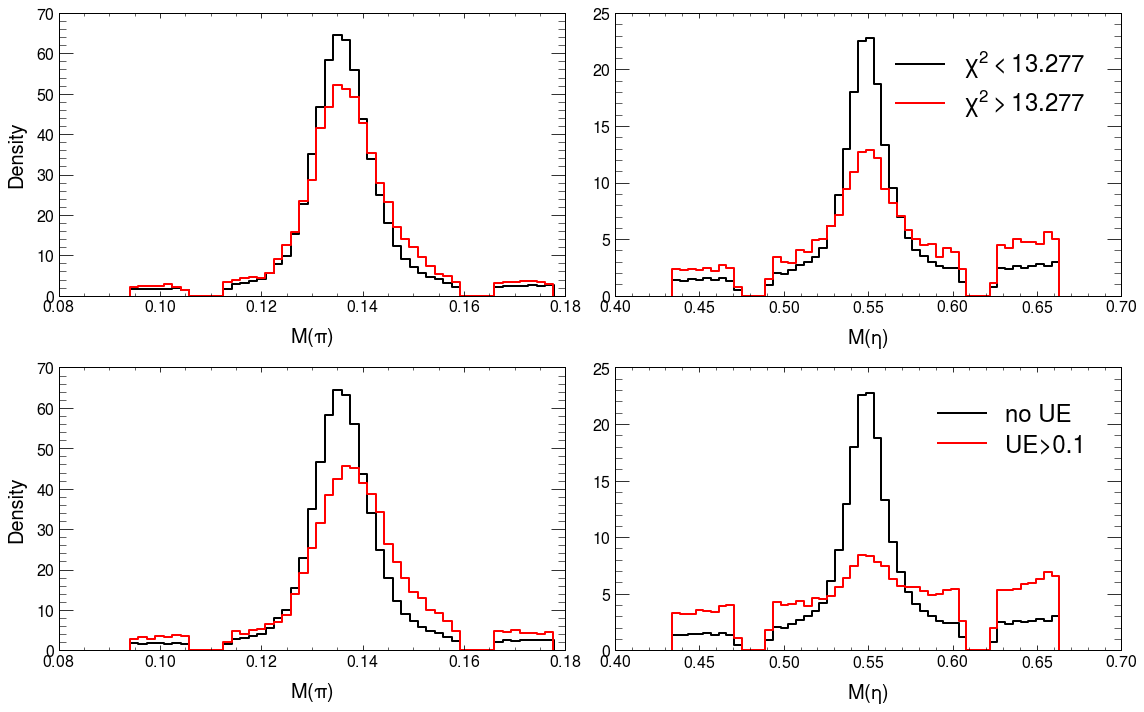

In [542]:
drawSet(dat_df_2)

Yields with $\chi^2<13.277$: 560018.25
Yields with $\chi^2>13.277$: 36492.5
Yields with no UE: 560018.25
Yields with UE>0.1: 8772.1669921875


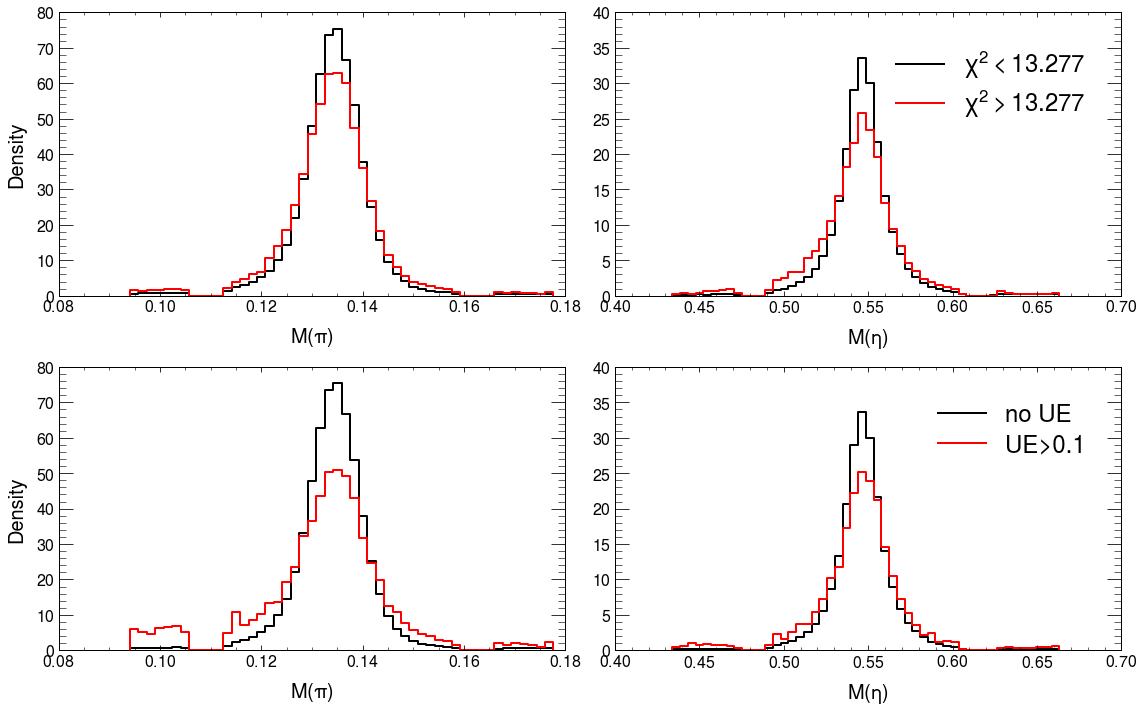

In [543]:
drawSet(acc_df_2)

Yields with $\chi^2<13.277$: 208560.328125
Yields with $\chi^2>13.277$: 41468.6640625
Yields with no UE: 208560.328125
Yields with UE>0.1: 171888.171875


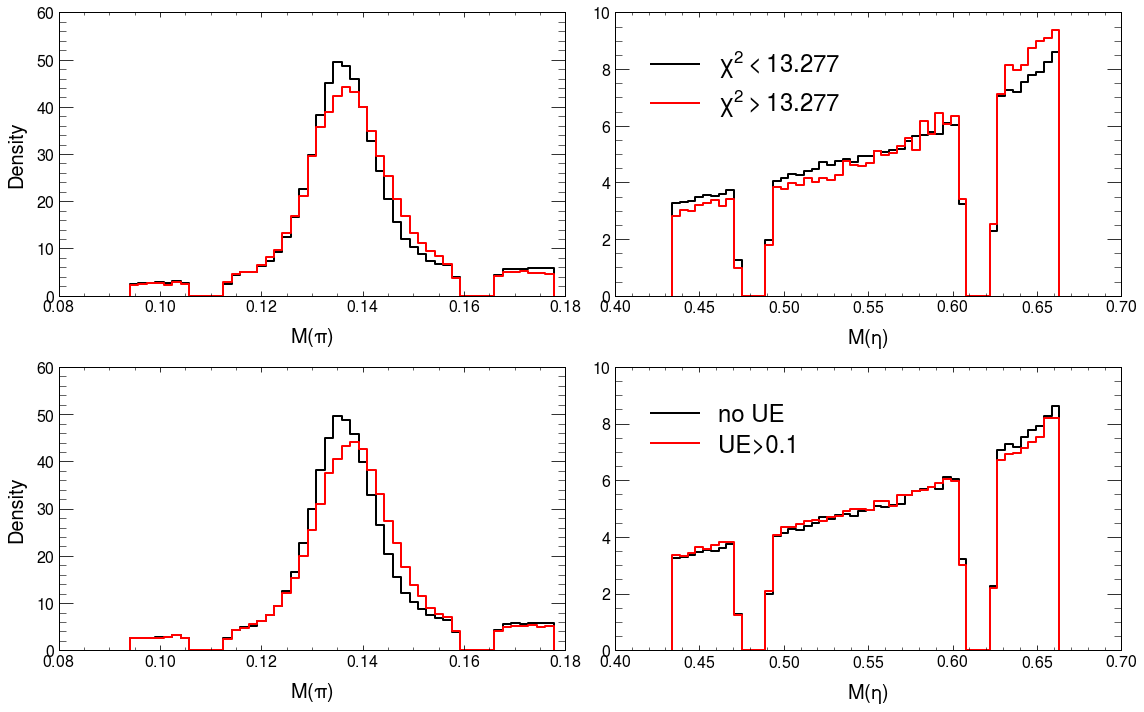

In [544]:
drawSet(b1_df_2)

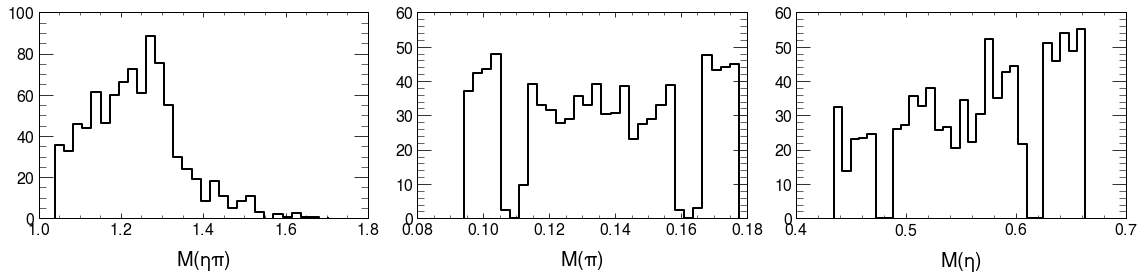

In [380]:
#### Check f2->4g channel real quick

fig,axes=plt.subplots(1,3,figsize=(16,4))
hep.histplot(np.histogram(f2_df_2.Mpi0eta,weights=f2_df_2.AccWeight,bins=30),ax=axes[0],c='black')
hep.histplot(np.histogram(f2_df_2.Mpi0,weights=f2_df_2.AccWeight,bins=30),ax=axes[1],c='black')
hep.histplot(np.histogram(f2_df_2.Meta,weights=f2_df_2.AccWeight,bins=30),ax=axes[2],c='black')
[ax.set_ylim(0) for ax in axes]
axes[0].set_xlabel(r"$M(\eta\pi)$")
axes[1].set_xlabel(r"$M(\pi)$")
axes[2].set_xlabel(r"$M(\eta)$")
plt.tight_layout()

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


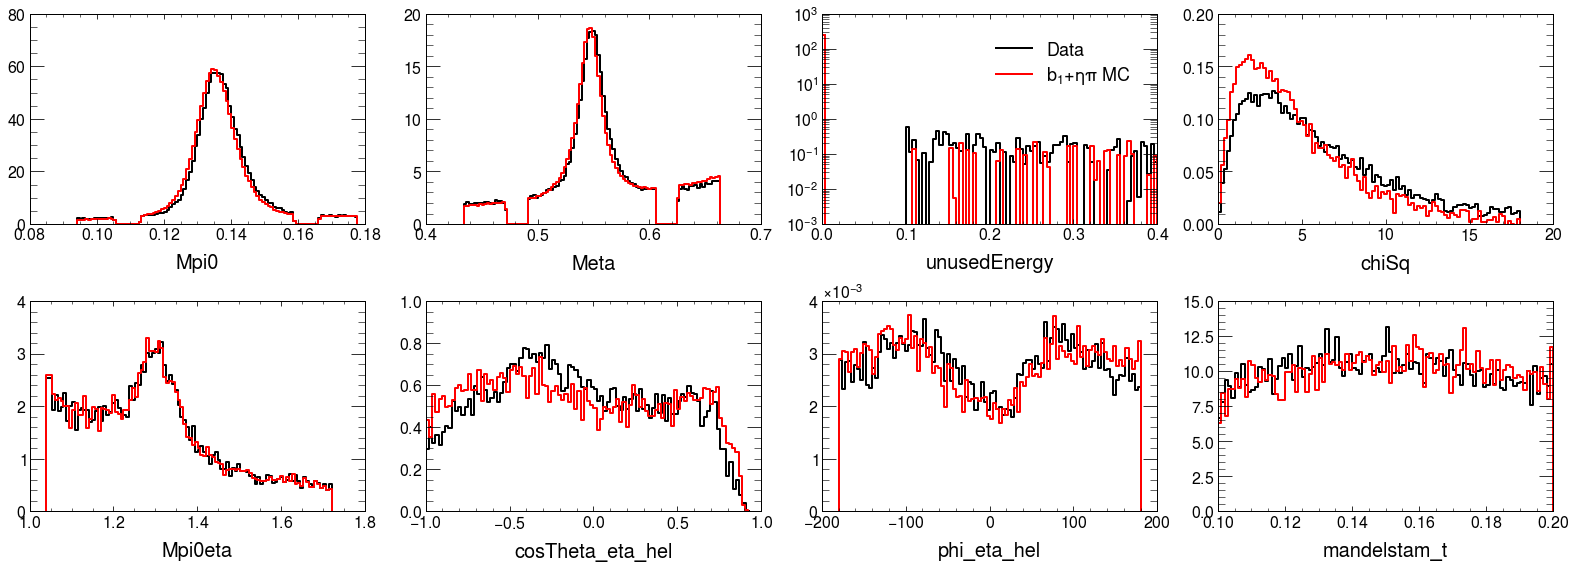

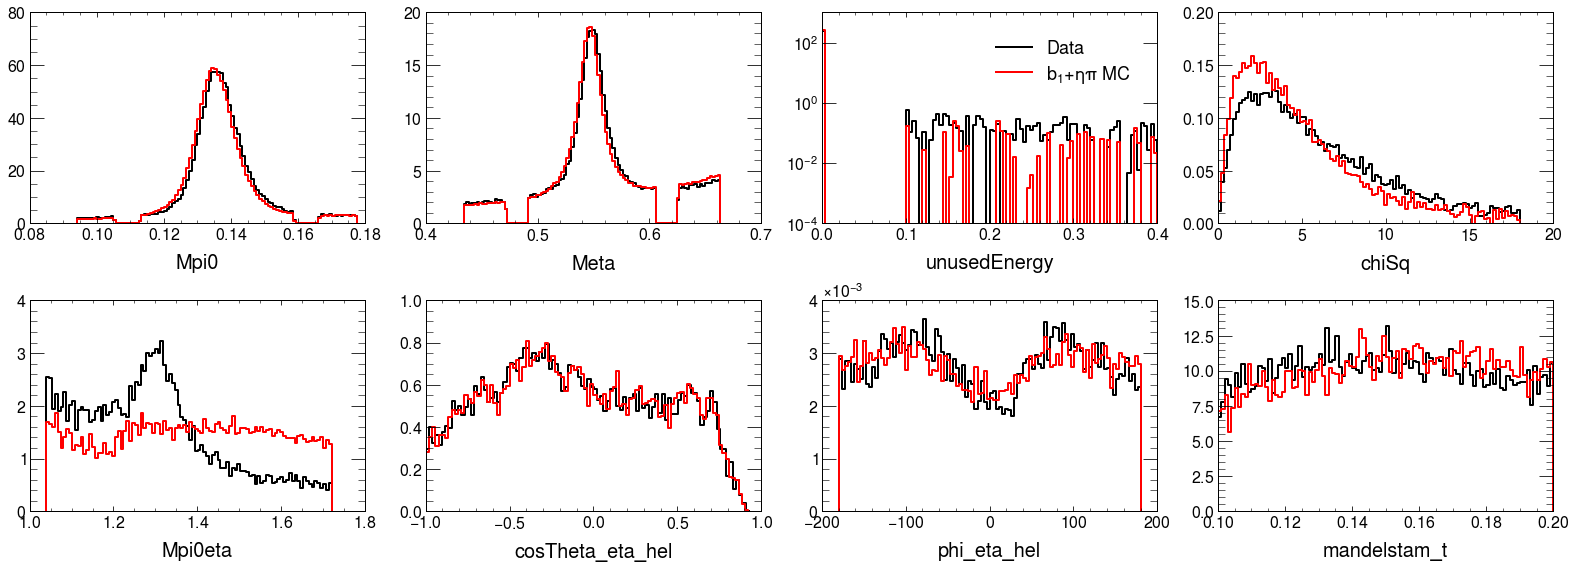

In [385]:
#######################

#### Sample the MC to match the data in one distribution to check the response of other variables


for varToSample,edges in zip(['Mpi0eta','cosTheta_eta_hel'],[np.linspace(1.04,1.72,50),np.linspace(-1,1,50)]):
    cdat=np.histogram(dat_df_2[varToSample],weights=dat_df_2['weightASBS'],bins=edges)
    ctmp=np.histogram(tmp[varToSample],weights=tmp['weightASBS'],bins=edges)
    acceptanceProb=cdat[0]/ctmp[0]
    def sample(x):
        prob=acceptanceProb[np.digitize(x,edges)-1] # have to -1 since the 0th bin is actually index 1
        return np.random.uniform()<prob
    tmp['acceptance']=tmp[varToSample].apply(sample)
    
    fig,axes=plt.subplots(2,4,figsize=(22,8))
    axes=axes.flatten()
    
    for i,var in enumerate(variables):
        if i<2:
            hep.histplot(np.histogram(dat_df_2[var],bins=100,weights=dat_df_2['AccWeight']),density=True,c='black',ax=axes[i],label='Data')
            hep.histplot(np.histogram(tmp[var],bins=100,weights=tmp['AccWeight']),density=True,c='red',ax=axes[i],label=r'$b_1$+$\eta\pi$ MC')
        else:
            hep.histplot(np.histogram(dat_df_2[var],weights=dat_df_2['weightASBS'],bins=100),density=True,c='black',ax=axes[i],label='Data')
            hep.histplot(np.histogram(tmp[var],weights=tmp['weightASBS']*tmp['acceptance'],bins=100),density=True,c='red',ax=axes[i],label=r'$b_1$+$\eta\pi$ MC')
        axes[i].set_xlabel(var)
    
    axes[3].set_ylim(0)
    axes[2].legend(prop={'size':18})
    axes[2].set_yscale('log')
    plt.tight_layout()

yield in summed: 69699.78090492818
yield in b1: -4190.712660060074
yield in acc: 73890.4935649882
summed/acc: 0.943


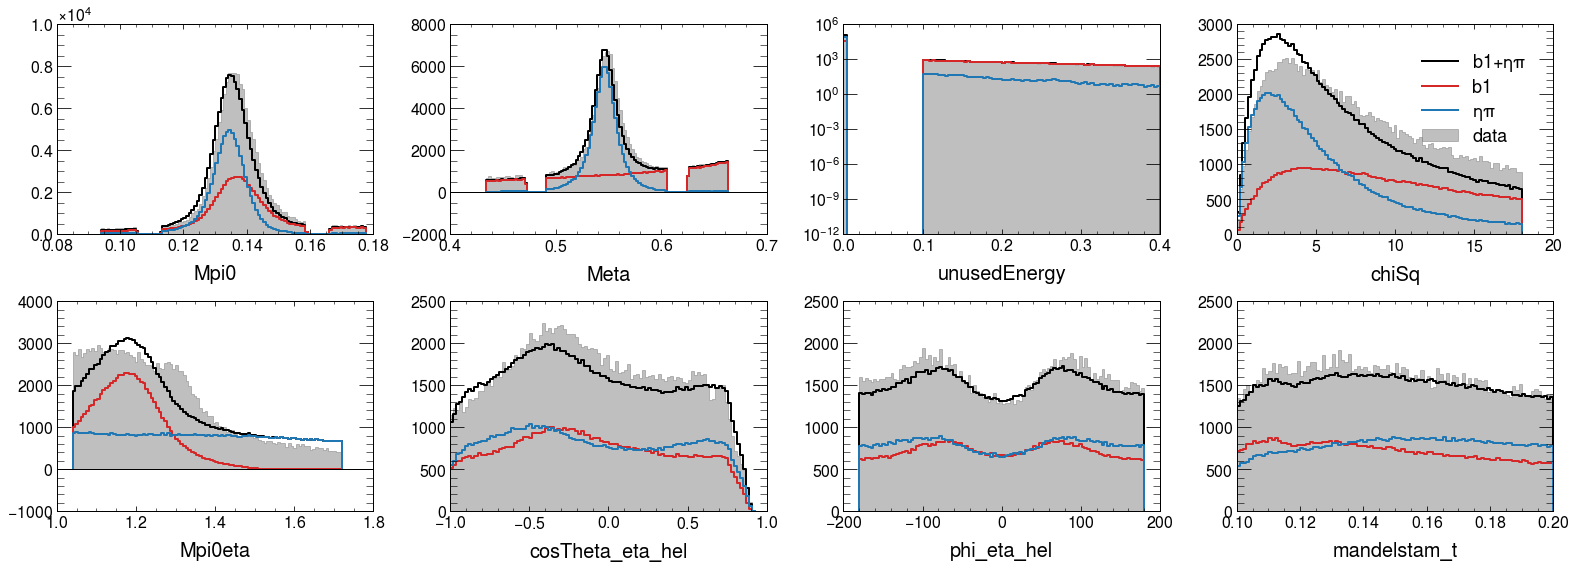

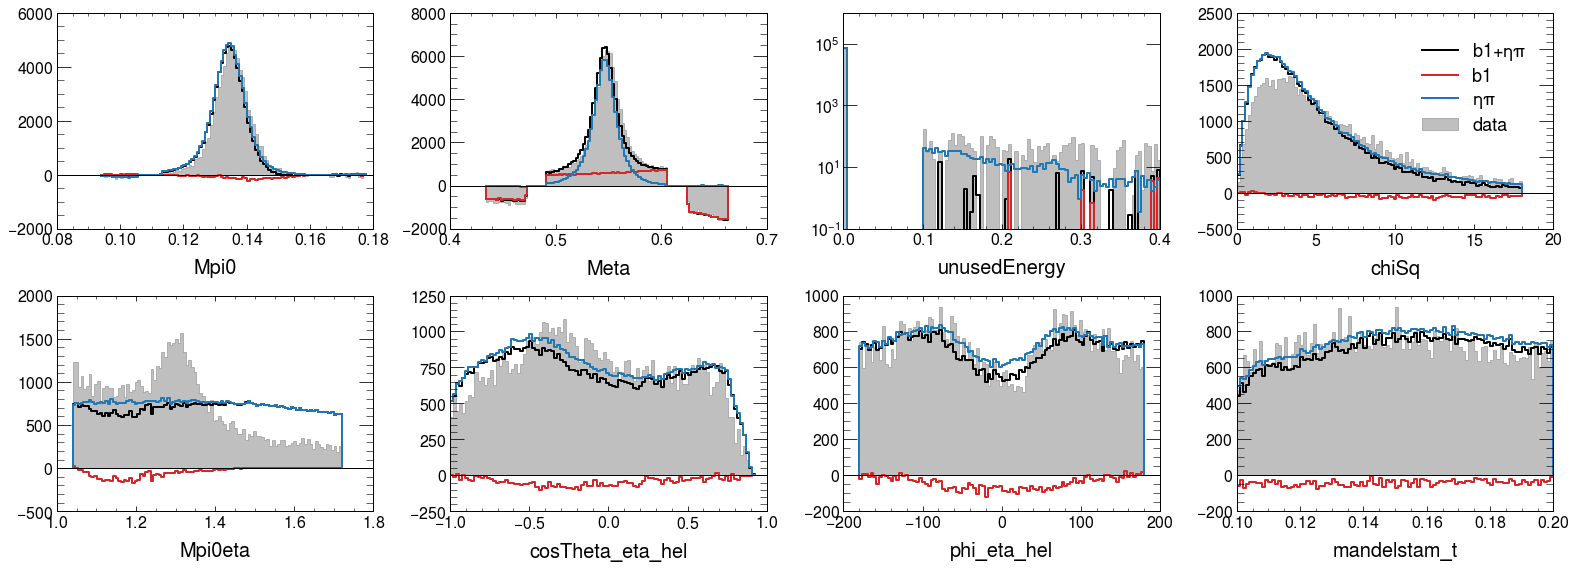

In [554]:
def drawPlots(dat,summed,b1,acc,weight):
    fig,axes=plt.subplots(2,4,figsize=(22,8))
    axes=axes.flatten()
    
    for i,var in enumerate(variables):
        edges=np.histogram(dat[var],bins=100)[1]
    #     weight="weightASBS" if i<2 else "weightASBS"
#         weight="AccWeight" if i<2 else "AccWeight"

        hep.histplot(np.histogram(dat[var],weights=dat[weight],bins=edges),histtype='fill',color='gray',alpha=0.5,label='data',ax=axes[i])
        hep.histplot(np.histogram(summed[var],weights=summed[weight]*summed.scaleFactor,bins=edges),c='black',label=r'b1+$\eta\pi$',ax=axes[i])
        hep.histplot(np.histogram(b1[var],weights=b1[weight]*b1.scaleFactor,bins=edges),c='tab:red',label='b1',ax=axes[i])
        hep.histplot(np.histogram(acc[var],weights=acc[weight]*acc.scaleFactor,bins=edges),c='tab:blue',label=r'$\eta\pi$',ax=axes[i])
        axes[i].axhline(0,c='black',linewidth=1)
        axes[i].set_xlabel(var)
        
    axes[3].legend(prop={'size':18})
    axes[2].set_yscale('log')
    plt.tight_layout()

dat_df_5=dat_df_2#[(dat_df_2.unusedEnergy<0.1)&(dat_df_2.chiSq<13.277)]
f1_df_5=f1_df_2#[(f1_df_2.unusedEnergy<0.1)&(f1_df_2.chiSq<13.277)]
acc_df_5=acc_df_2#[(acc_df_2.unusedEnergy<0.1)&(acc_df_2.chiSq<13.277)]
b1_df_5=b1_df_2#[(b1_df_2.unusedEnergy<0.1)&(b1_df_2.chiSq<13.277)]

b1_df_5['scaleFactor']=0.15
acc_df_5['scaleFactor']=0.13
summed=pd.concat([b1_df_5,acc_df_5])

drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'AccWeight')
drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'weightASBS')

print(f'yield in data: {(dat_df_5[weight]).sum()}')
print(f'yield in summed: {(summed[weight]*summed.scaleFactor).sum()}')
print(f'yield in b1: {(b1_df_5[weight]*b1_df_5.scaleFactor).sum()}')
print(f'yield in acc: {(acc_df_5[weight]*acc_df_5.scaleFactor).sum()}')
print(f'summed/acc: {(summed[weight]*summed.scaleFactor).sum()/(acc_df_5[weight]*acc_df_5.scaleFactor).sum():0.3f}')

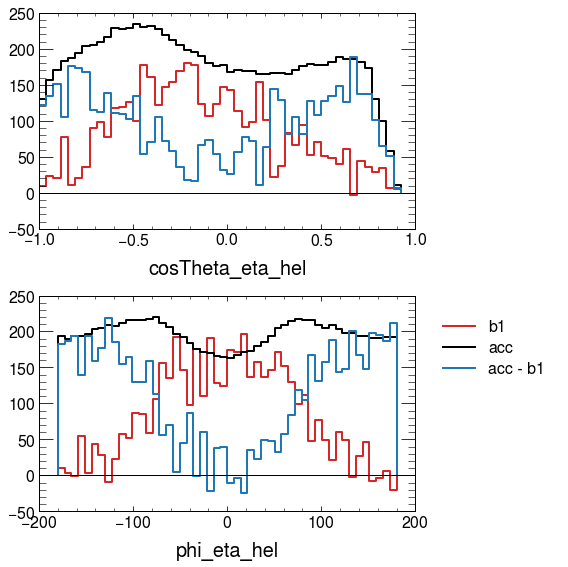

In [530]:
fig,axes=plt.subplots(2,1,figsize=(8,8))
axes=axes.flatten()

weight="weightASBS"
for i,var in enumerate(variables[5:-1]):
    edges=np.histogram(b1_df_5[var],bins=50)[1]
    out=np.histogram(b1_df_5[var],weights=-1*b1_df_5[weight]*b1_df_5.scaleFactor,bins=edges)
    scale=max(out[0])*len(out[0])/acc_df_5[weight].sum()
    flat=np.histogram(acc_df_5[var],weights=acc_df_5[weight]*scale,bins=edges)[0]
    hep.histplot(out,c='tab:red',label='b1',ax=axes[i])
    hep.histplot((flat,out[1]),c='black',label='acc',ax=axes[i])
    hep.histplot((flat-out[0],out[1]),c='tab:blue',label='acc - b1',ax=axes[i])
    axes[i].axhline(0,c='black',linewidth=1)
    axes[i].set_xlabel(var)
axes[1].legend(bbox_to_anchor=(1.01,1))
plt.tight_layout()

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


yield in summed: 66902.69942508814
yield in b1: -1946.6000664465107
yield in acc: 68849.29949153471
summed/acc: 0.972


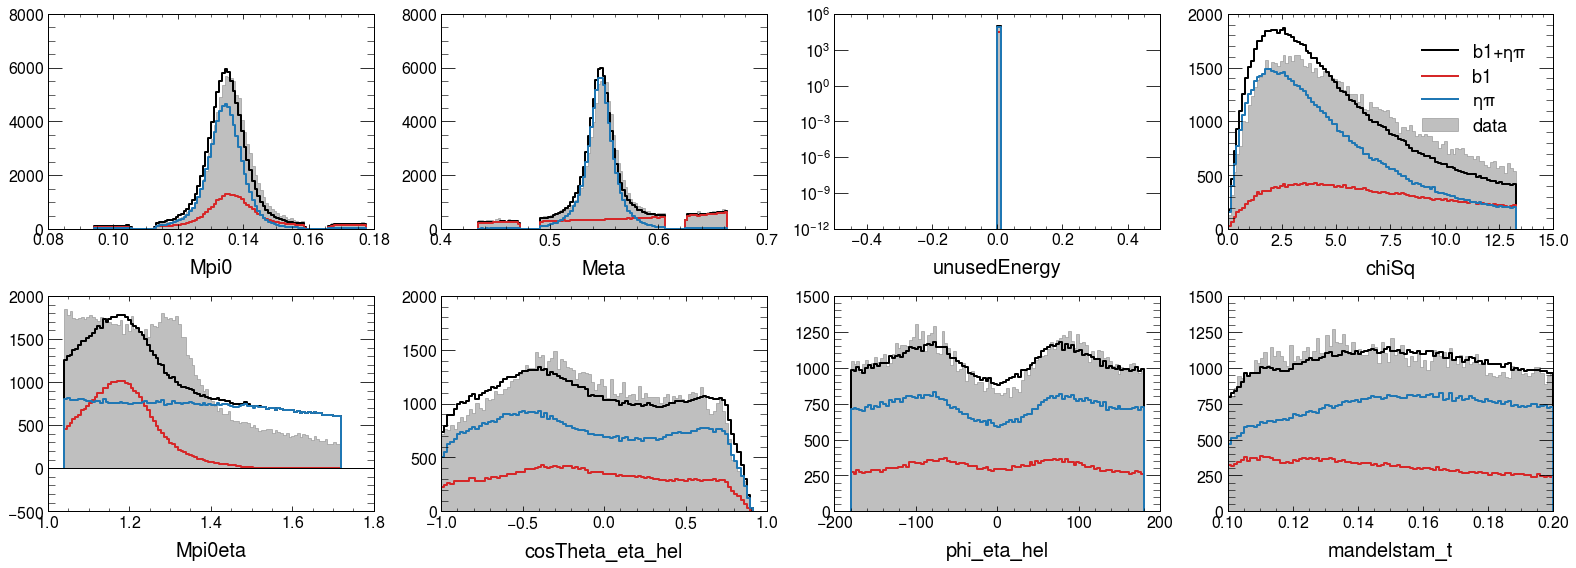

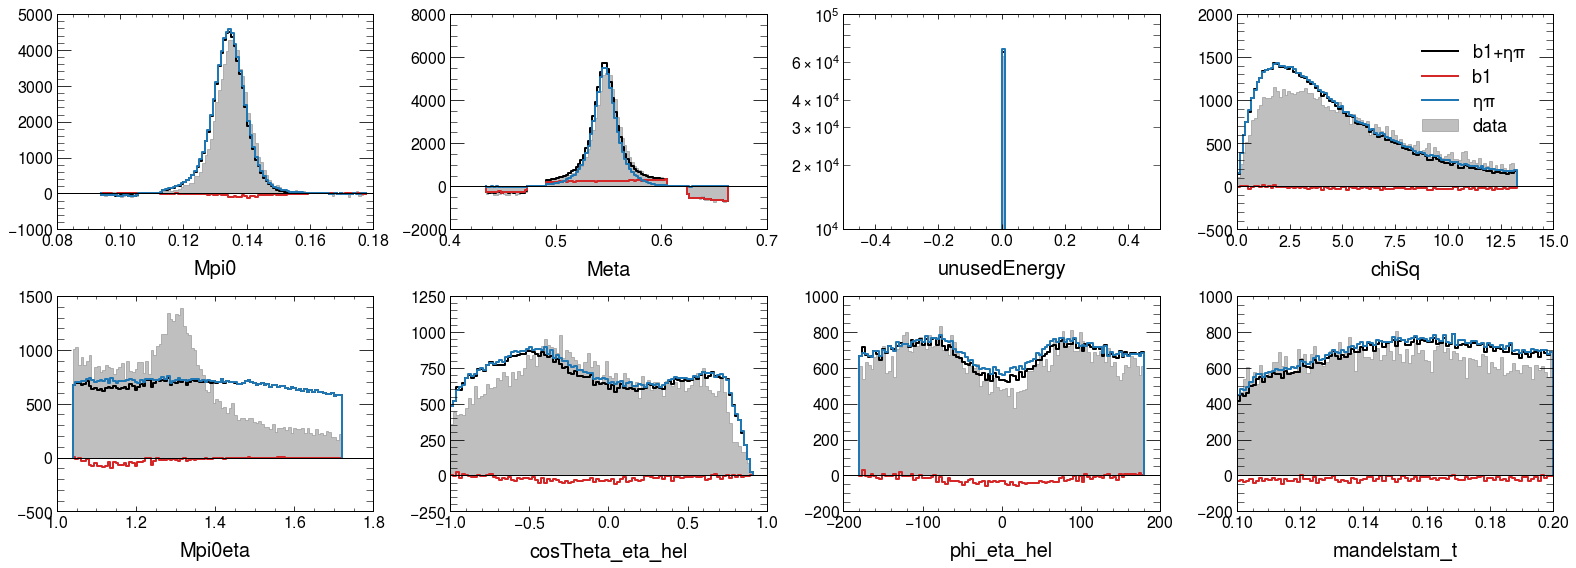

In [555]:
dat_df_5=dat_df_2[(dat_df_2.unusedEnergy<0.1)&(dat_df_2.chiSq<13.277)]
f1_df_5=f1_df_2[(f1_df_2.unusedEnergy<0.1)&(f1_df_2.chiSq<13.277)]
acc_df_5=acc_df_2[(acc_df_2.unusedEnergy<0.1)&(acc_df_2.chiSq<13.277)]
b1_df_5=b1_df_2[(b1_df_2.unusedEnergy<0.1)&(b1_df_2.chiSq<13.277)]

b1_df_5['scaleFactor']=0.15
acc_df_5['scaleFactor']=0.13
summed=pd.concat([b1_df_5,acc_df_5])

drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'AccWeight')
drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'weightASBS')

print(f'yield in data: {(dat_df_5[weight]).sum()}')
print(f'yield in summed: {(summed[weight]*summed.scaleFactor).sum()}')
print(f'yield in b1: {(b1_df_5[weight]*b1_df_5.scaleFactor).sum()}')
print(f'yield in acc: {(acc_df_5[weight]*acc_df_5.scaleFactor).sum()}')
print(f'summed/acc: {(summed[weight]*summed.scaleFactor).sum()/(acc_df_5[weight]*acc_df_5.scaleFactor).sum():0.3f}')

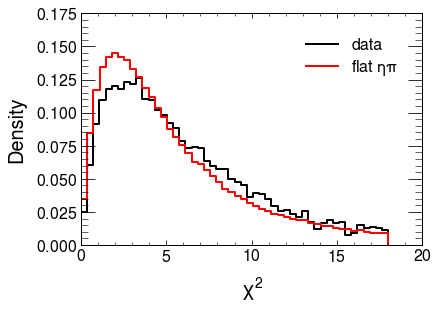

In [540]:
hep.histplot(np.histogram(dat_df_2.chiSq, weights=dat_df_2.weightASBS, bins=50), density=True, c='black', label='data')
hep.histplot(np.histogram(acc_df_2.chiSq, weights=acc_df_2.weightASBS, bins=50), density=True, c='red', label=r'flat $\eta\pi$')
plt.xlabel(r'$\chi^2$')
plt.ylabel(r'Density')
plt.legend()

In [566]:
# nominal='Mpi0eta 1.04 1.72 pVH 0.5 999 unusedEnergy -999 0.01 chiSq -999 13.277 \
# !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
# !photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
# photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
# proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'
selection='Mpi0eta 1.04 1.72 pVH 0.5 999 !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
!photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'

dat_df_6=dat_df
dat_df_6=applyCut(dat_df_6,selection)
acc_df_6=acc_df
acc_df_6=applyCut(acc_df_6,selection)
b1_df_6=b1_df
b1_df_6=applyCut(b1_df_6,selection)

f2_df_6=f2_df
f2_df_6=applyCut(f2_df_6,selection)
eta_df_6=eta_df
eta_df_6=applyCut(eta_df_6,selection)
etap_df_6=etap_df
etap_df_6=applyCut(etap_df_6,selection)
a2pi_df_6=a2pi_df
a2pi_df_6=applyCut(a2pi_df_6,selection)
f1_df_6=f1_df
f1_df_6=applyCut(f1_df_6,selection)

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


yield in data: 231274.890625
yield in summed: 226447.45241568613
yield in b1: -3637.2876523442537
yield in acc: 230084.7400680304
summed/acc: 0.984


/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


yield in data: 63855.421875
yield in summed: 66902.69942508814
yield in b1: -1946.6000664465107
yield in acc: 68849.29949153471
summed/acc: 0.972


/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


yield in data: 31247.8515625
yield in summed: 30534.47479624121
yield in b1: -213.54167542606592
yield in acc: 30748.016471667277
summed/acc: 0.993


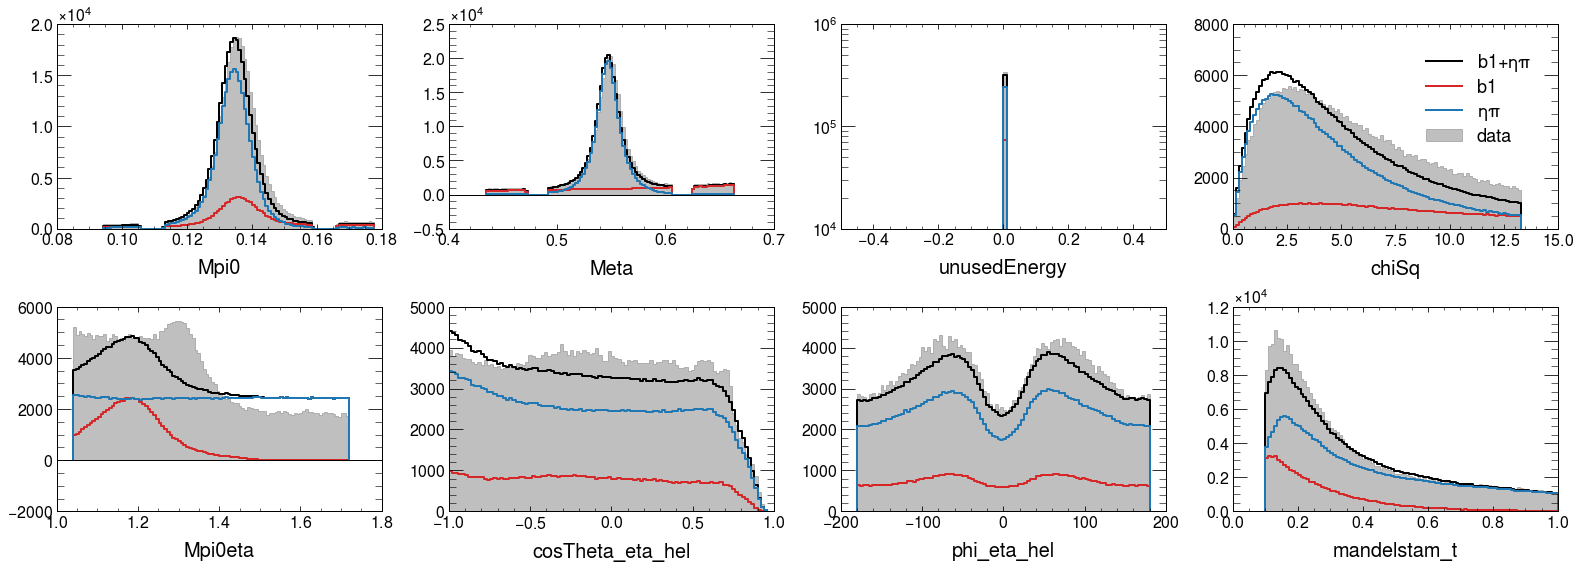

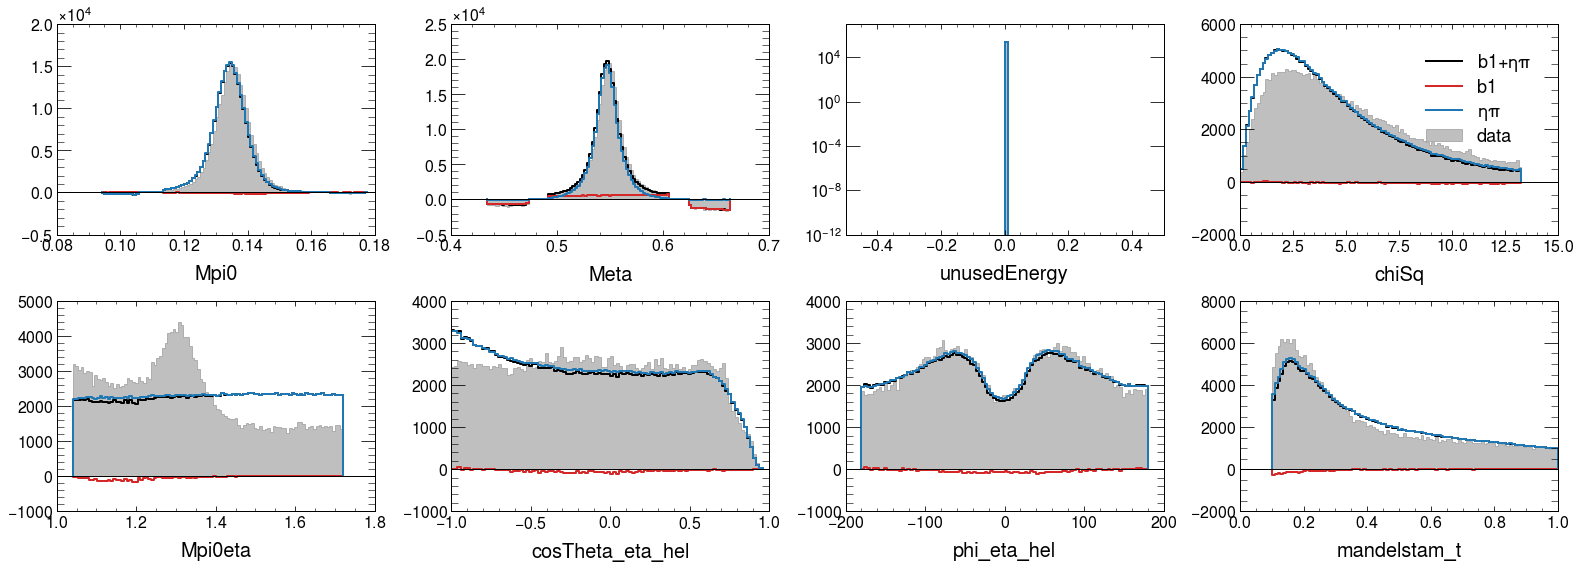

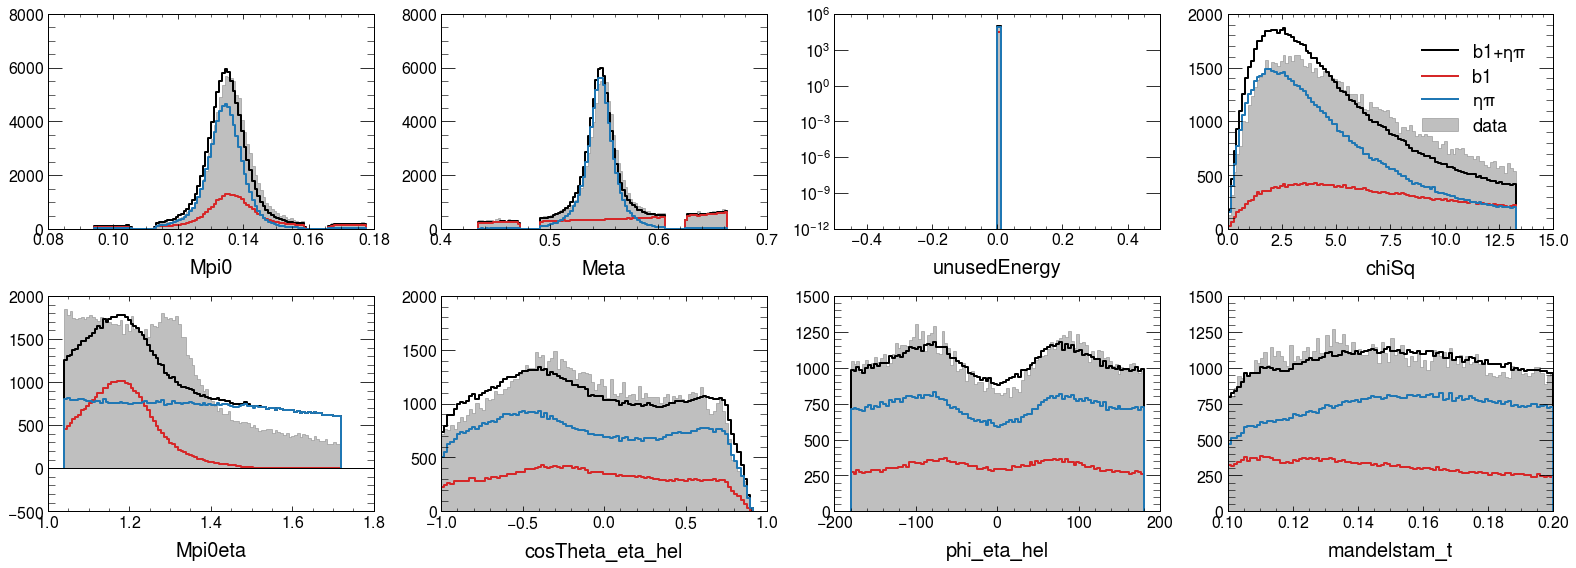

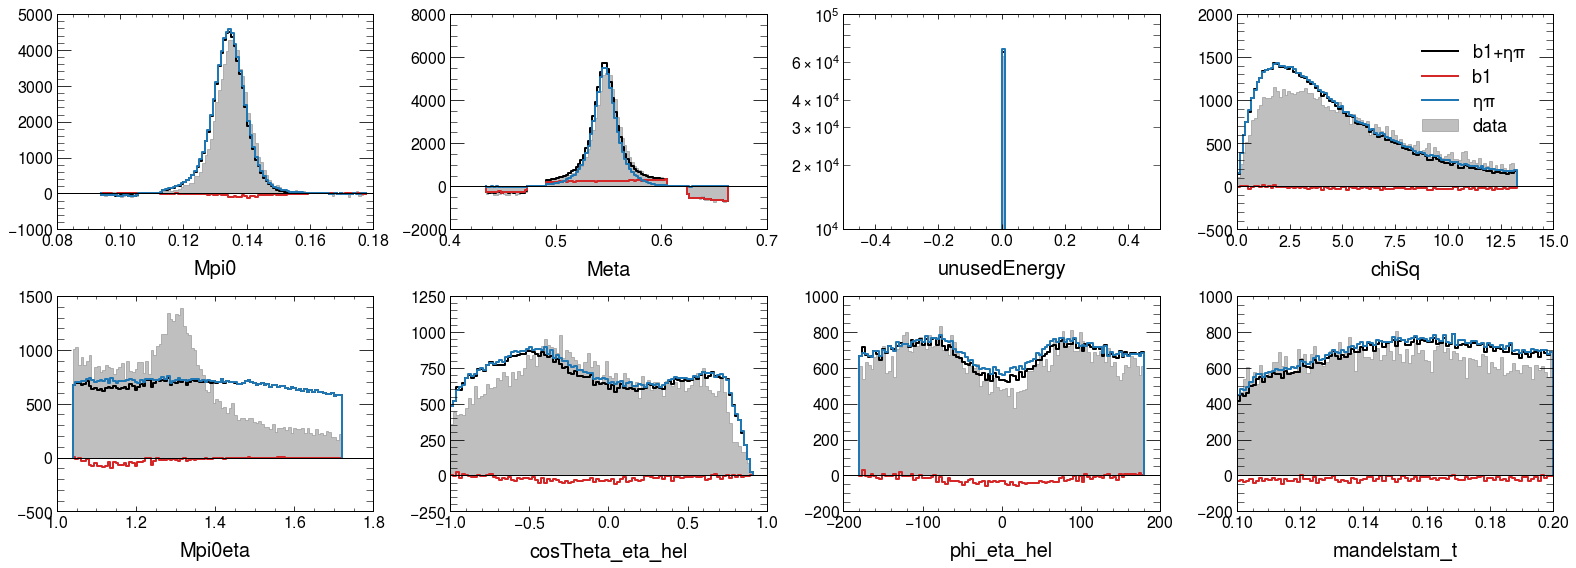

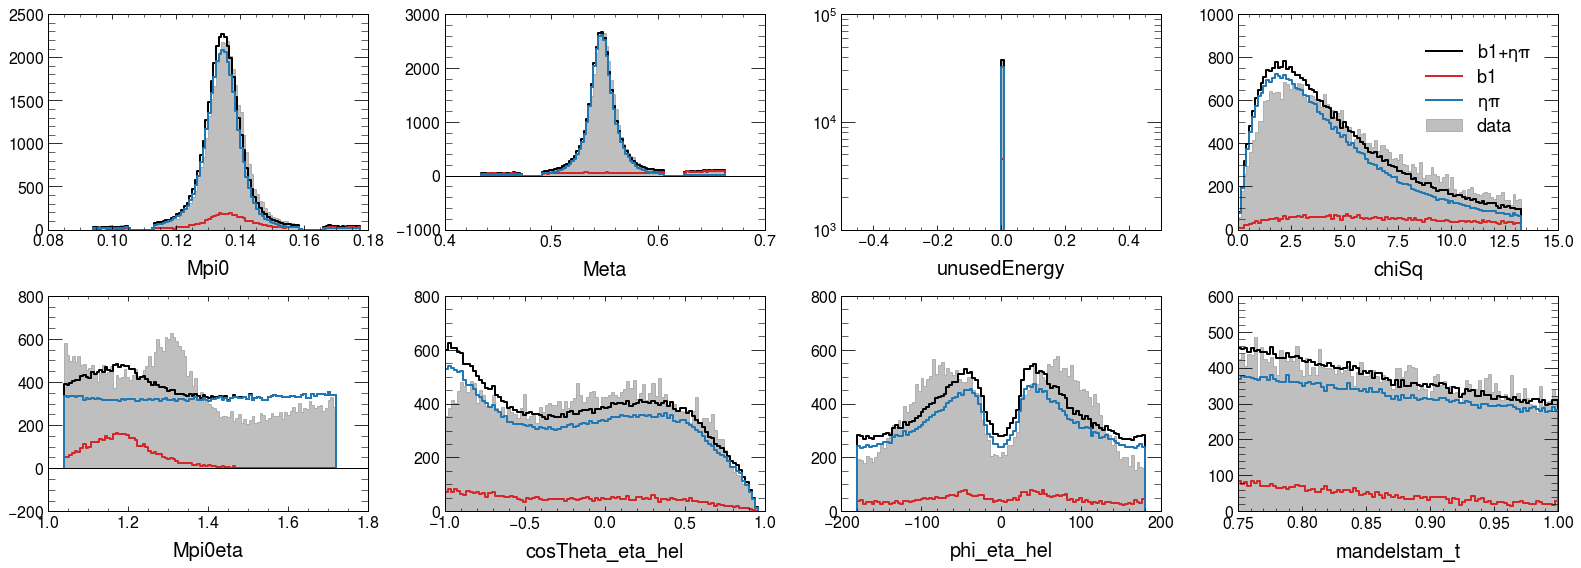

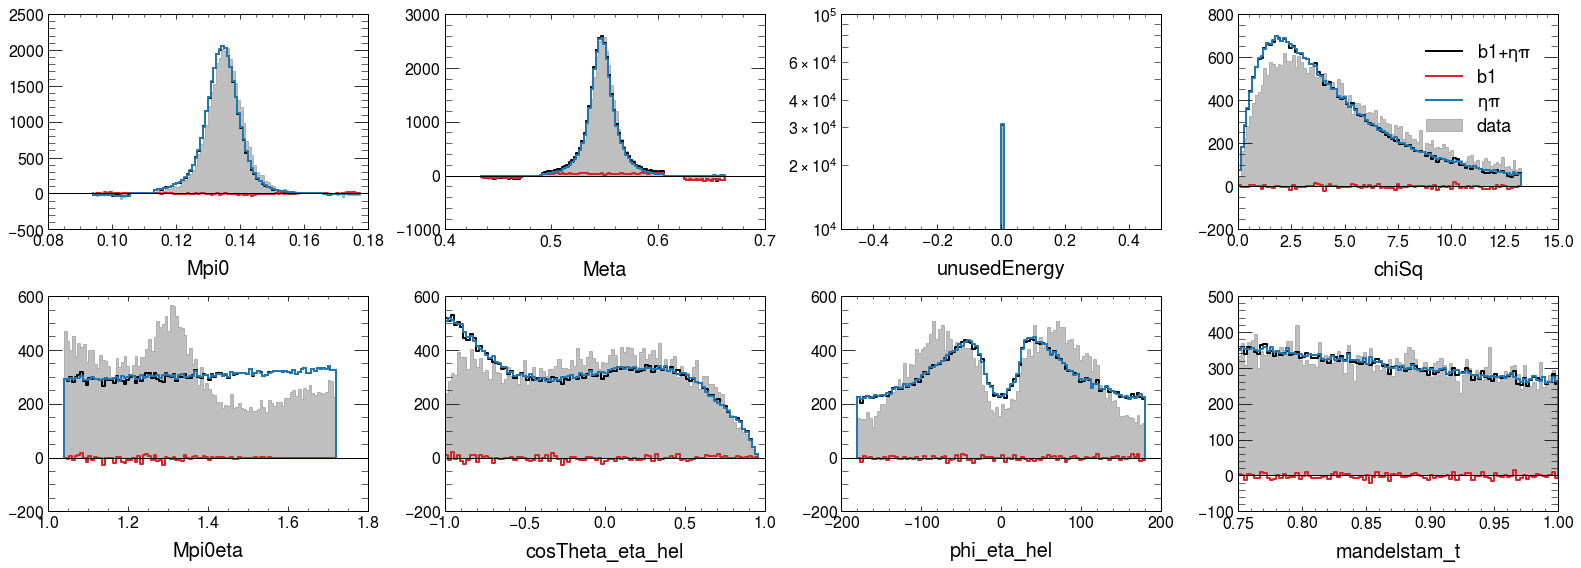

In [586]:
dat_df_5=dat_df_6[(dat_df_6.unusedEnergy<0.1)&(dat_df_6.chiSq<13.277)&(dat_df_6.mandelstam_t>0.1)&(dat_df_6.mandelstam_t<1.0)]
acc_df_5=acc_df_6[(acc_df_6.unusedEnergy<0.1)&(acc_df_6.chiSq<13.277)&(acc_df_6.mandelstam_t>0.1)&(acc_df_6.mandelstam_t<1.0)]
b1_df_5=b1_df_6[(b1_df_6.unusedEnergy<0.1)&(b1_df_6.chiSq<13.277)&(b1_df_6.mandelstam_t>0.1)&(b1_df_6.mandelstam_t<1.0)]

b1_df_5['scaleFactor']=0.15
acc_df_5['scaleFactor']=0.1
summed=pd.concat([b1_df_5,acc_df_5])

drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'AccWeight')
drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'weightASBS')

print(f'yield in data: {(dat_df_5[weight]).sum()}')
print(f'yield in summed: {(summed[weight]*summed.scaleFactor).sum()}')
print(f'yield in b1: {(b1_df_5[weight]*b1_df_5.scaleFactor).sum()}')
print(f'yield in acc: {(acc_df_5[weight]*acc_df_5.scaleFactor).sum()}')
print(f'summed/acc: {(summed[weight]*summed.scaleFactor).sum()/(acc_df_5[weight]*acc_df_5.scaleFactor).sum():0.3f}')

###############
dat_df_5=dat_df_6[(dat_df_6.unusedEnergy<0.1)&(dat_df_6.chiSq<13.277)&(dat_df_6.mandelstam_t>0.1)&(dat_df_6.mandelstam_t<0.2)]
acc_df_5=acc_df_6[(acc_df_6.unusedEnergy<0.1)&(acc_df_6.chiSq<13.277)&(acc_df_6.mandelstam_t>0.1)&(acc_df_6.mandelstam_t<0.2)]
b1_df_5=b1_df_6[(b1_df_6.unusedEnergy<0.1)&(b1_df_6.chiSq<13.277)&(b1_df_6.mandelstam_t>0.1)&(b1_df_6.mandelstam_t<0.2)]

b1_df_5['scaleFactor']=0.15
acc_df_5['scaleFactor']=0.13
summed=pd.concat([b1_df_5,acc_df_5])

drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'AccWeight')
drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'weightASBS')

print(f'yield in data: {(dat_df_5[weight]).sum()}')
print(f'yield in summed: {(summed[weight]*summed.scaleFactor).sum()}')
print(f'yield in b1: {(b1_df_5[weight]*b1_df_5.scaleFactor).sum()}')
print(f'yield in acc: {(acc_df_5[weight]*acc_df_5.scaleFactor).sum()}')
print(f'summed/acc: {(summed[weight]*summed.scaleFactor).sum()/(acc_df_5[weight]*acc_df_5.scaleFactor).sum():0.3f}')


################
dat_df_5=dat_df_6[(dat_df_6.unusedEnergy<0.1)&(dat_df_6.chiSq<13.277)&(dat_df_6.mandelstam_t>0.75)&(dat_df_6.mandelstam_t<1.0)]
acc_df_5=acc_df_6[(acc_df_6.unusedEnergy<0.1)&(acc_df_6.chiSq<13.277)&(acc_df_6.mandelstam_t>0.75)&(acc_df_6.mandelstam_t<1.0)]
b1_df_5=b1_df_6[(b1_df_6.unusedEnergy<0.1)&(b1_df_6.chiSq<13.277)&(b1_df_6.mandelstam_t>0.75)&(b1_df_6.mandelstam_t<1.0)]

b1_df_5['scaleFactor']=0.5
acc_df_5['scaleFactor']=0.095
summed=pd.concat([b1_df_5,acc_df_5])

drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'AccWeight')
drawPlots(dat_df_5,summed,b1_df_5,acc_df_5,'weightASBS')

print(f'yield in data: {(dat_df_5[weight]).sum()}')
print(f'yield in summed: {(summed[weight]*summed.scaleFactor).sum()}')
print(f'yield in b1: {(b1_df_5[weight]*b1_df_5.scaleFactor).sum()}')
print(f'yield in acc: {(acc_df_5[weight]*acc_df_5.scaleFactor).sum()}')
print(f'summed/acc: {(summed[weight]*summed.scaleFactor).sum()/(acc_df_5[weight]*acc_df_5.scaleFactor).sum():0.3f}')

In [14]:
selection='Mpi0eta 0.85 2.0 pVH 0.5 999 !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
!photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'

d1=dat_df
d1=applyCut(d1,selection)
a1=acc_df
a1=applyCut(a1,selection)
b1=b1_df
b1=applyCut(b1,selection)

In [15]:
d2=d1[
    (d1.weightBSpi0==1)&(d1.weightBSeta==1)&
    (d1.unusedEnergy<0.1)&(d1.chiSq<13.277)
]

a2=a1[
    (a1.weightBSpi0==1)&(a1.weightBSeta==1)&
    (a1.unusedEnergy<0.1)&(a1.chiSq<13.277)
]

b2=b1[
    (b1.weightBSpi0==1)&(b1.weightBSeta==1)&
    (b1.unusedEnergy<0.1)&(b1.chiSq<13.277)
]

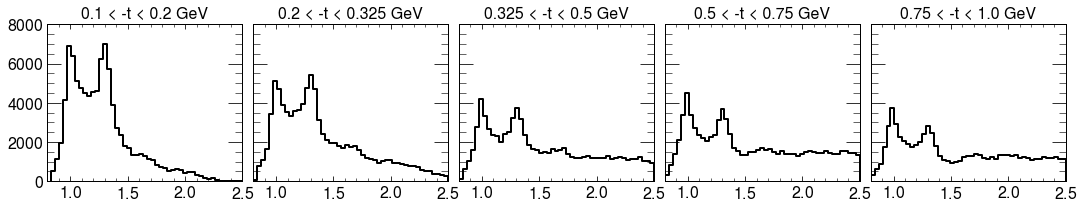

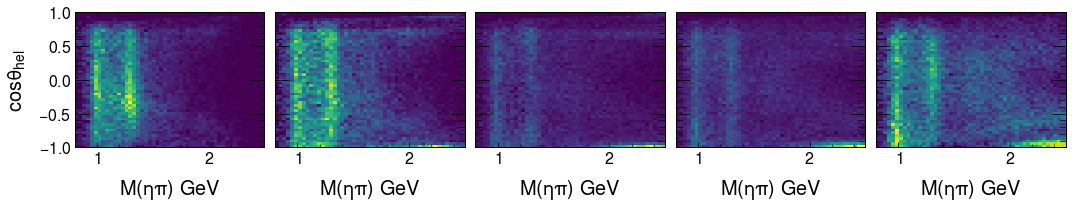

In [93]:
# nominal='Mpi0eta 1.04 1.72 pVH 0.5 999 unusedEnergy -999 0.01 chiSq -999 13.277 \
# !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
# !photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
# photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
# proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'
selection='chiSq -999 13.277'

dat_df_2=dat_df_2.copy()
dat_df_2=applyCut(dat_df_2,selection)
acc_df_2=acc_df_2.copy()
acc_df_2=applyCut(acc_df_2,selection)

fig,axes=plt.subplots(1,5,figsize=(15,3),sharex=True,sharey=True)
axes=axes.flatten()

mmin=0.8
mmax=2.5
xbins=np.linspace(mmin,mmax,50)
for it,tmin,tmax in zip(range(5),[0.1,0.2,0.325,0.5,0.75],[0.2,0.325,0.5,0.75,1.0]):
    tmp=dat_df_2[(dat_df_2.mandelstam_t>tmin)&(dat_df_2.mandelstam_t<tmax)&(dat_df_2.pVH)]
#     tmp=tmp[f(tmp["Mpi0eta"],*args2) > tmp.vanHove_omega]
    tmp=tmp[(tmp["Mpi0eta"]<mmax)&(tmp["Mpi0eta"]>mmin)]
    axes[it].set_title(f"{tmin} < -t < {tmax} GeV")
    hep.histplot(np.histogram(tmp.Mpi0eta,weights=tmp.weightASBS,bins=xbins),ax=axes[it],c='black')
axes[0].set_xlim(mmin,mmax)
axes[0].set_ylim(0)#,5000)
plt.tight_layout()

ybins=np.linspace(-1,1,50)
fig,axes=plt.subplots(1,5,figsize=(15,3),sharex=True,sharey=True)
axes=axes.flatten()
for it,tmin,tmax in zip(range(5),[0.1,0.2,0.325,0.5,0.75],[0.2,0.325,0.5,0.75,1.0]):
    tmp=dat_df_2[(dat_df_2.mandelstam_t>tmin)&(dat_df_2.mandelstam_t<tmax)&(dat_df_2.pVH)]
#     tmp=tmp[f(tmp["Mpi0eta"],*args2) > tmp.vanHove_omega]
    tmp=tmp[(tmp["Mpi0eta"]<mmax)&(tmp["Mpi0eta"]>mmin)]
    out=np.histogram2d(tmp.Mpi0eta,tmp.cosTheta_eta_hel,weights=tmp.weightASBS,bins=(xbins,ybins))
    c,edges=out[0],out[1:]
    c[c<=0]=0
    out=(c,*edges)
    hep.hist2dplot(out,ax=axes[it],cbar=False,cmin=0)
    axes[it].set_xlabel(r"$M(\eta\pi)$ GeV")
axes[0].set_xlim(mmin,mmax)
axes[0].set_ylabel(r"$cos\theta_{hel}$")
plt.tight_layout()

## --- END ABOVE STUDY ----

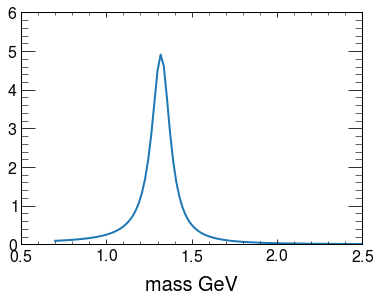

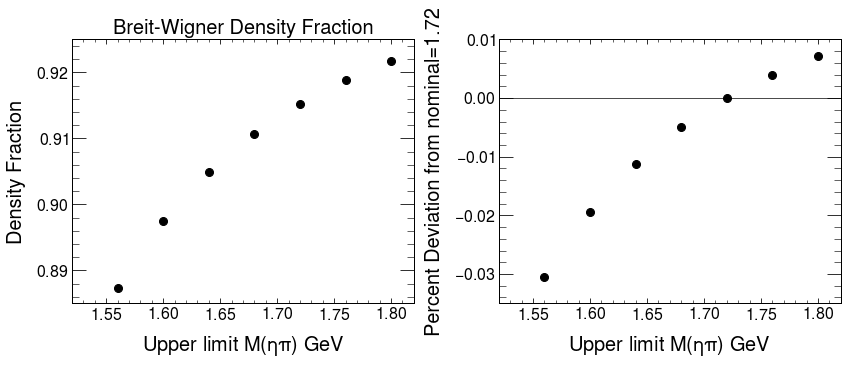

In [808]:
########################################################################################
########### STUDY FAKE SYSTEMATIC OF TRUNCATING METAPI SINCE LESS OF THE BW IS SEEN ######################
########################################################################################

def relBW(x,particle_mass,width):
    ''' Equation for relativistic breit-wigner'''
    gamma=np.sqrt(particle_mass*particle_mass*(particle_mass*particle_mass+width*width))
    k=2*np.sqrt(2)*particle_mass*width*gamma/np.pi/np.sqrt(particle_mass*particle_mass+gamma)
    return k / ((x*x - particle_mass*particle_mass)**2 + (particle_mass*width)**2)


##### WE DO NOT EXPLICITY INCLUDE THE PHASE SPACE MODIFICATION BUT WE WILL ESTIMATE THIS 
#####   BY INTEGRATING BETWEEN THE ETAPI0 THRESHOLD AND AROUND 3.2 WHERE WE STOP SEEING EVENTS IN DATA
etamass=0.548
pi0mass=0.135
etapi0lower=etamass+pi0mass
etapi0upper=3.2
a2params=(1.32,0.13)
x=np.linspace(0.7,2.5,100)
y=relBW(x,*a2params)
plt.plot(x,y)
plt.ylim(0)
plt.xlabel(r'mass GeV')


integral_fractions=[]
integral_total=scipy.integrate.quad(relBW,etapi0lower,etapi0upper,args=a2params)[0]
upperlimits=[1.56,1.60,1.64,1.68,1.72,1.76,1.80]
for u in upperlimits:
    integral=scipy.integrate.quad(relBW,1.04,u,args=a2params)[0]
    integral_fractions.append(integral/integral_total)
fig,axes=plt.subplots(1,2,figsize=(12,5))
axes[0].scatter(upperlimits,integral_fractions,c='black')
axes[0].set_xlabel(r'Upper limit $M(\eta\pi)$ GeV')
axes[0].set_ylabel('Density Fraction')
axes[0].set_title('Breit-Wigner Density Fraction',size=20)
axes[0].set_xlim(1.52,1.82)
axes[1].scatter(upperlimits,[(x-integral_fractions[4])/integral_fractions[4] for x in integral_fractions],c='black')
axes[1].set_xlabel(r'Upper limit $M(\eta\pi)$ GeV')
axes[1].set_ylabel('Percent Deviation from nominal=1.72')
axes[1].set_xlim(1.52,1.82)
axes[1].ticklabel_format(style='plain')
axes[1].axhline(0,c='black',linewidth=1,alpha=0.7)
plt.tight_layout()

## --- END ABOVE STUDY ----

In [604]:
import pickle
floc='/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/systematic_v13/SOURCE/systematic_syst/input_data.pkl'

In [605]:
with open(floc, "rb") as input_file:
    input_result = pickle.load(input_file)

In [606]:
nvariations=len(input_result['variations'])

No handles with labels found to put in legend.


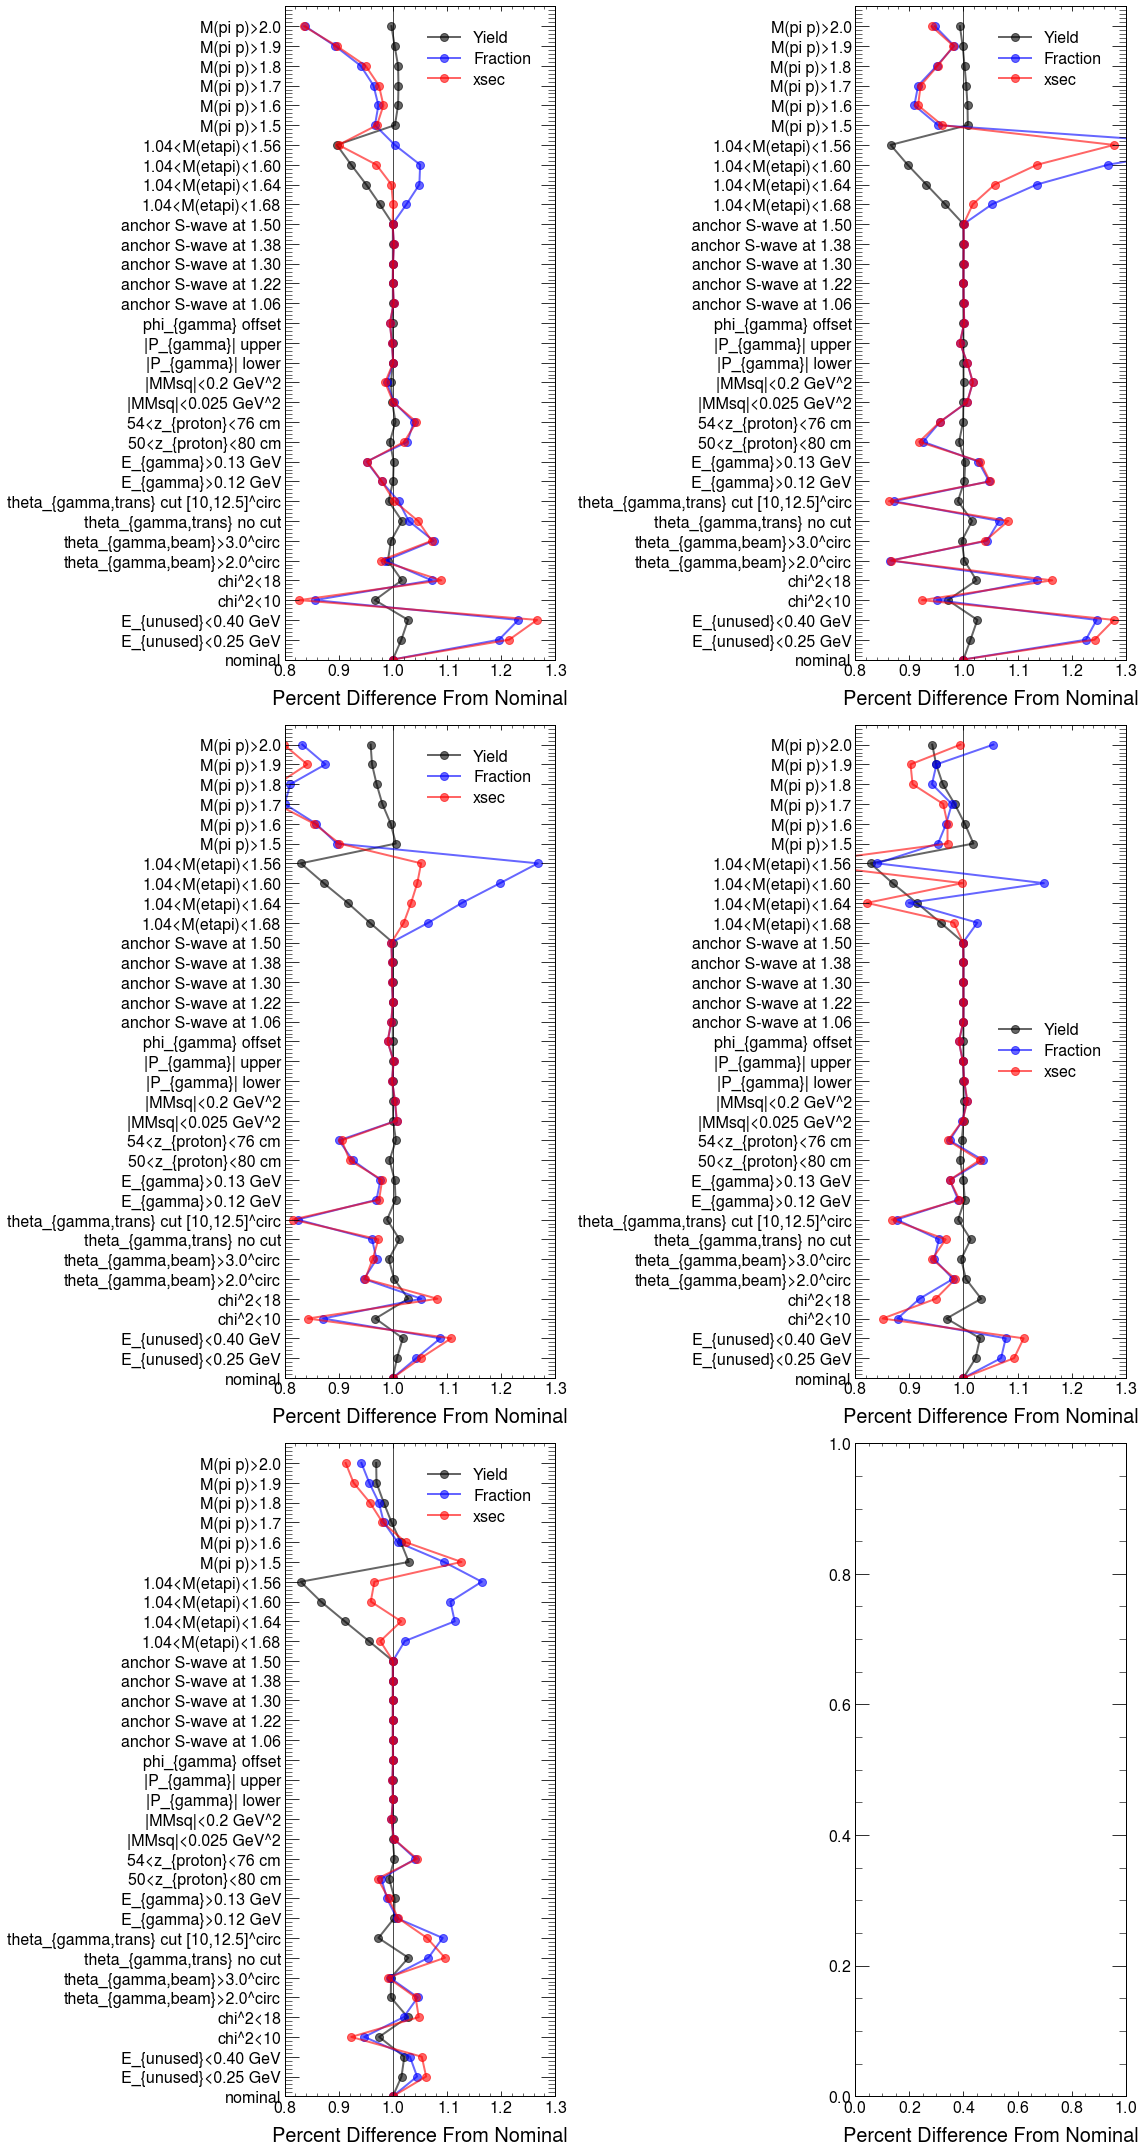

In [607]:
fig,axes=plt.subplots(3,2,figsize=(16,30))
axes=axes.flatten()

keys=[r'nominal']+[x.replace('\\','').replace('$','') for x in input_result['variations']]
indexes=range(len(keys))
values=np.array(input_result['totals']).reshape(-1,nvariations+1) # +1 for the nominal
for i,ax in zip(range(5),axes): # 5 tbins
    ax.plot(values[i]/values[i][0],indexes,'-o',c='black',label='Yield',alpha=0.6) # 0th element is the nominal
    ax.set_ylim(0,nvariations+1)
    ax.set_xlim(0.8,1.3)
    ax.axvline(1,c='black',alpha=0.7,linewidth=1)
    ax.set_yticks(indexes)
    ax.set_yticklabels(keys)

values=np.array(input_result['waveInts_ts']['D']).reshape(-1,nvariations+1)
for i,ax in zip(range(5),axes): # 5 tbins
    ax.plot(values[i]/values[i][0],indexes,'-o',c='blue',label='Fraction',alpha=0.6)
            
values=(np.array(input_result['xsecpos'])+np.array(input_result['xsecneg'])).reshape(-1,nvariations+1)
for i,ax in zip(range(5),axes): # 5 tbins
    ax.plot(values[i]/values[i][0],indexes,'-o',c='red',label='xsec',alpha=0.6)
                   
[ax.legend() for ax in axes]
[ax.set_xlabel('Percent Difference From Nominal') for ax in axes]
plt.tight_layout()

## --- END ABOVE STUDY ----

In [698]:
acc_df=[]
c_rec=["Mpi0eta","Meta","Mpi0","mandelstam_t","Ebeam","weightASBS","cosTheta_eta_hel","phi_eta_hel","Metap",
       "Mpi0p","vanHove_omega",'rfTime',
      'proton_z','proton_momentum','unusedEnergy','pVH','chiSq','photonTheta1','photonTheta2','photonTheta3','photonTheta4',
      'photonE1','photonE2','photonE3','photonE4','mmsq','Phi']
c_gen=["Mpi0eta_thrown",'mandelstam_t_thrown','cosTheta_eta_hel_thrown','phi_eta_hel_thrown']

dat_df=[[],[],[],[],[]]
acc_df=[[],[],[],[],[]]
gen_df=[[],[],[],[],[]]
for i,t in enumerate(['010020','0200325','0325050','050075','075100']):
    for run in ["2017_1","2018_1","2018_8"]:
        dat_df[i].append(loadDF(f"/d/grid17/ln16/dselector_v3/phase1_selected_v4/t{t}_m104180_selectGenTandM/"+
                             f'polALL_t{t}_m104180_selectGenTandM_DTOT_selected_acc_flat.root',"kin",cols=c_rec))
        acc_df[i].append(loadDF(f"/d/grid17/ln16/dselector_v3/phase1_selected_v4/t{t}_m104180_selectGenTandM/"+
                             f'polALL_t{t}_m104180_selectGenTandM_FTOT_selected_acc_flat.root',"kin",cols=c_rec))
        gen_df[i].append(loadDF(f"/d/grid17/ln16/dselector_v3/phase1_selected_v4/t{t}_m104180_selectGenTandM/"+
                             f'polALL_t{t}_m104180_selectGenTandM_FTOT_gen_data_flat.root',"kin",cols=c_gen))
    dat_df[i]=pd.concat(dat_df[i])
    dat_df[i]=dat_df[i].reset_index(drop=True)
    acc_df[i]=pd.concat(acc_df[i])
#     acc_df[i]=acc_df[i].sample(int(len(acc_df[i])*0.3))
    gen_df[i]=pd.concat(gen_df[i])
    acc_df[i]=acc_df[i].reset_index(drop=True)

def f(x,a,b,c,d):
    return a*np.arctan(b*x+c)+d
args2=(-29.5,-1.05,2.78,328)

In [701]:
tmp=dat_df.copy()
tmp_acc=acc_df.copy()
tmp_gen=gen_df.copy()
for j in range(5):
    tmp[j]=applyCut(tmp[j],nominal)
    tmp_acc[j]=applyCut(tmp_acc[j],nominal)

In [728]:
cdats=[]
corrs=[]
cgens=[]
caccs=[]
exs=[]
eys=[]

ex=np.linspace(1.04,1.72,52)
# ex=np.linspace(-1,1,52)
ey=np.linspace(-180,180,52)
xvar='Mpi0eta'
yvar='phi_eta_hel'

for j in range(5):
    cdat,_,_=np.histogram2d(tmp[j][xvar],tmp[j][yvar],weights=tmp[j].weightASBS,bins=(ex,ey))
    cacc,_,_=np.histogram2d(tmp_acc[j][xvar],tmp_acc[j][yvar],weights=tmp_acc[j].weightASBS,bins=(ex,ey))
    cgen,_,_=np.histogram2d(tmp_gen[j][xvar+'_thrown'],tmp_gen[j][yvar+'_thrown']*180/np.pi,bins=(ex,ey))
    cacc[cacc==0]=0.001 # avoid div by 0
    corr=cgen/cacc
    corr[abs(corr)>20]=0 # thrown out large corrections
    cdats.append(cdat)
    corrs.append(corr)
    caccs.append(cacc)
    cgens.append(cgen)
    exs.append(ex)
    eys.append(ey)

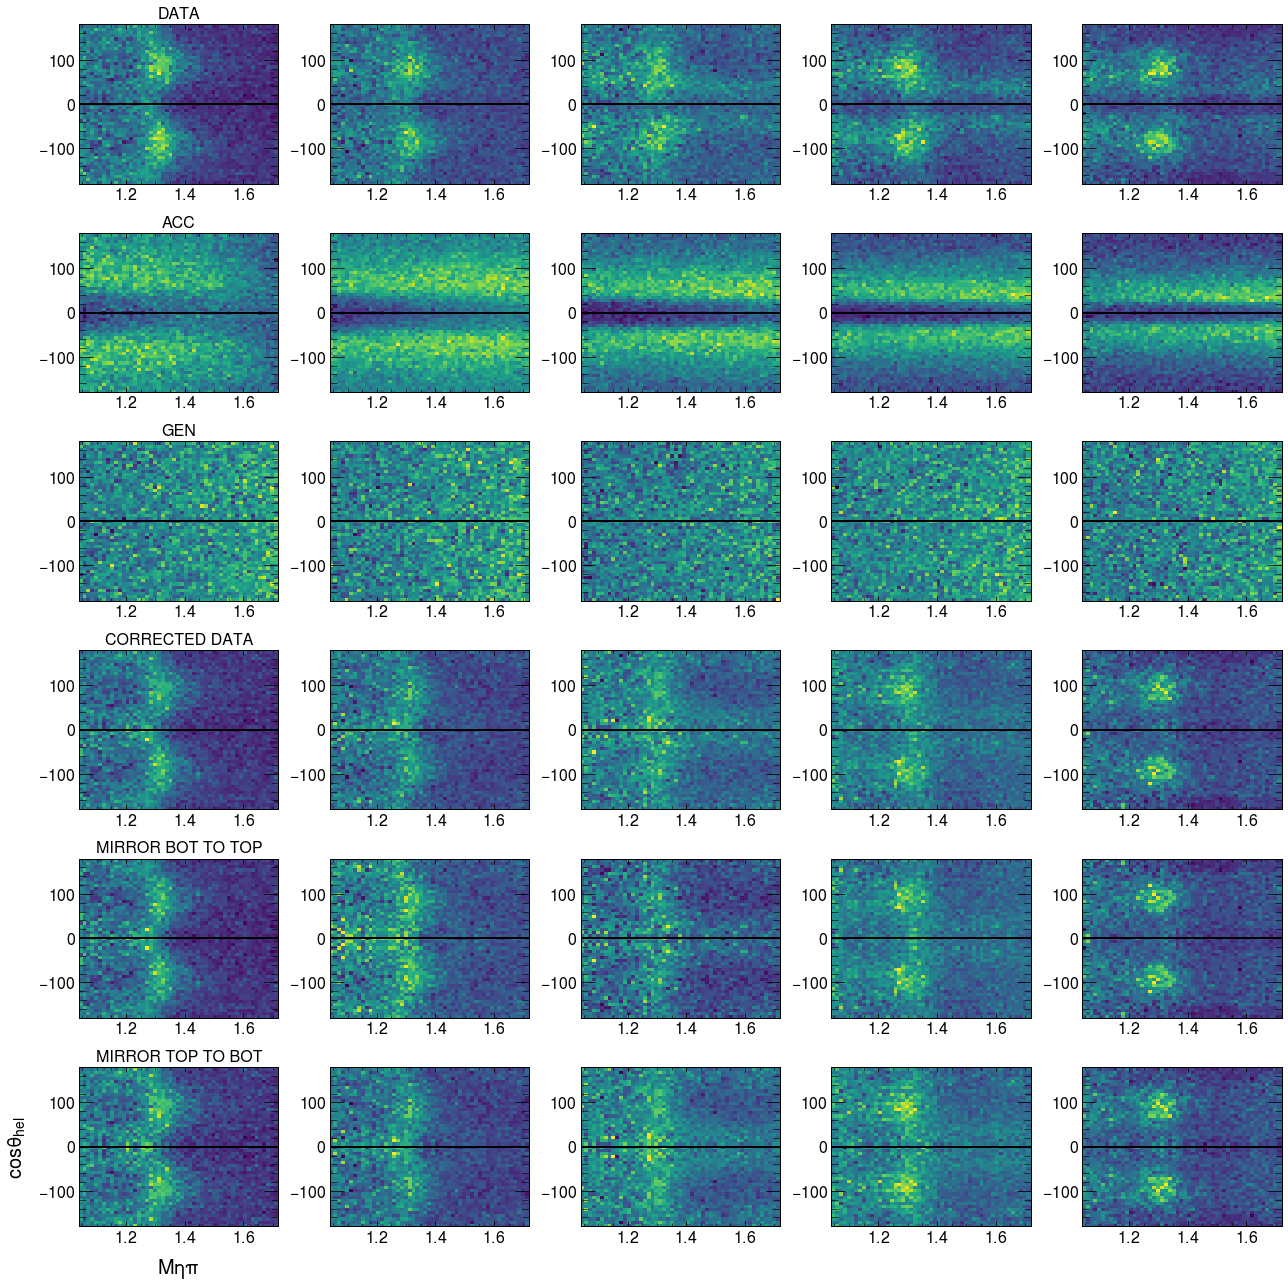

In [729]:
fig,axes=plt.subplots(6,5,figsize=(18,18))

def drawXY(xs,iax):
    for j,x,cdat,ex,ey in zip(range(5),xs,cdats,exs,eys):
        hep.hist2dplot((x,ex,ey),ax=axes[iax,j],cbar=False)#vmin=0)
        axes[iax,j].set_ylim(ey[0],ey[-1])
        axes[iax,j].set_xlim(ex[0],ex[-1])
        axes[iax,j].axhline(0,c='black') 
        axes[iax,j]
    
drawXY(cdats,0)
drawXY(caccs,1)
drawXY(cgens,2)
drawXY([corr*cdat for corr,cdat in zip(corrs,cdats)],3)

xs=[corr*cdat for corr,cdat in zip(corrs,cdats)]
for i in range(len(xs)):
    xs[i][:,25:]=np.flip(xs[i],axis=1)[:,25:]
drawXY(xs,4)

xs=[corr*cdat for corr,cdat in zip(corrs,cdats)]
for i in range(len(xs)):
    xs[i][:,:25]=np.flip(xs[i],axis=1)[:,:25]
drawXY(xs,5)
    
axes[0,0].set_title("DATA")
axes[1,0].set_title("ACC")
axes[2,0].set_title("GEN")
axes[3,0].set_title("CORRECTED DATA")
axes[4,0].set_title("MIRROR BOT TO TOP")
axes[5,0].set_title("MIRROR TOP TO BOT")
axes[5,0].set_ylabel(r'$cos\theta_{hel}$')
axes[5,0].set_xlabel(r'$M\eta\pi$')
plt.tight_layout()

In [ ]:
# nominal='Mpi0eta 1.04 1.72 pVH 0.5 999 unusedEnergy -999 0.01 chiSq -999 13.277 \
# !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
# !photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
# photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
# proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'

# variable='cosTheta_eta_hel'
# variable=variable.split(';')
# nvars=len(variable)

# nvariations=3
# fig,axes=plt.subplots(2,5,figsize=(18,10))
# tmp=dat_df.copy()
# tmp_acc=acc_df.copy()
# for j in range(5):
#     tmp[j]=applyCut(tmp[j],nominal)
#     tmp_acc[j]=applyCut(tmp_acc[j],nominal)
#     for i in range(nvariations):
#         tmp2=tmp[j][tmp[j].Mpi0p>(2.0-0.25*i)].copy()
#         tmp2_acc=tmp_acc[j][tmp_acc[j].Mpi0p>(2.0-0.25*i)].copy()
#         edges=np.histogram(tmp2[variable[0]],weights=tmp2['weightASBS'],bins=30)[1]
#         hep.histplot(np.histogram(tmp2[variable[0]],weights=tmp2['weightASBS'],density=True,bins=edges),ax=axes[0,j])
#         hep.histplot(np.histogram(tmp2_acc[variable[0]],weights=tmp2_acc['weightASBS'],density=True,bins=edges),ax=axes[1,j],linestyle='-')
#         axes[0,j].set_ylim(0)
#         axes[1,j].set_ylim(0)
# plt.tight_layout()

## --- END ABOVE STUDY ----

In [7]:
#######################################
###### Make things look prettier #######
#######################################

prettyWave={
    "S0++":"S_{0}^{+}",
    "D2-+":"D_{-2}^{+}",
    "D1-+":"D_{-1}^{+}",
    "D0++":"D_{0}^{+}",
    "D1++":"D_{1}^{+}",
    "D2++":"D_{2}^{+}",
    "S0+-":"S_{0}^{-}",
    "D2--":"D_{-2}^{-}",
    "D1--":"D_{-1}^{-}",
    "D0+-":"D_{0}^{-}",
    "D1+-":"D_{1}^{-}",
    "D2+-":"D_{2}^{-}",
    "D2-+_pD2-+":"D_{-2}^{+}",
    "D1-+_pD1-+":"D_{-1}^{+}",
    "D0++_pD0++":"D_{0}^{+}",
    "D1++_pD1++":"D_{1}^{+}",
    "D2++_pD2++":"D_{2}^{+}",
    "S0+-_pS0+-":"S_{0}^{-}",
    "D2--_pD2--":"D_{-2}^{-}",
    "D1--_pD1--":"D_{-1}^{-}",
    "D0+-_pD0+-":"D_{0}^{-}",
    "D1+-_pD1+-":"D_{1}^{-}",
    "D2+-_pD2+-":"D_{2}^{-}",
}

rearrangeWaveNotation={
    "S0+":"S0++",
    "S0-":"S0+-",
    "D-2+":"D2-+",
    "D-2-":"D2--",
    "D-1+":"D1-+",
    "D-1-":"D1--",
    "D0+":"D0++",
    "D0-":"D0+-",
    "D1+":"D1++",
    "D1-":"D1+-",
    "D2+":"D2++",
    "D2-":"D2+-",
}
rearrangeWaveNotationErr={k+"_err":v+"_err" for k,v in rearrangeWaveNotation.items()}
rearrangeWaveNotation={**rearrangeWaveNotation,**rearrangeWaveNotationErr}

# Mass Independet Fit Results

In [643]:
def loadMassIndependentData(baseFolder,waveset,masses,factor=1.0,bsTag="",keep=[True,True,True]):
    '''
    [baseFolder]: location to look for the finalAmps+[bsTag] which should contain a folder [waveset]
    [factor]: should we keep likelihoods within this factor of the best?
    [keep]: what data should we keep? only [converged, best likelihood, smallest err]
    '''
    keepConvergedOnly, keepBestLikelihoodOnly, keepSmallestErrorOnly = keep
    
    width=masses[1]-masses[0]
    masses=(masses)[:-1]+width/2
    binToMass={binNum:mass for binNum,mass in enumerate(masses)}

    datasets=[]
    totalFits=0
    filteredFits=0
    if not os.path.exists(baseFolder):
        print("folder does not exist! skipping: "+baseFolder)
        return None
    base=baseFolder+"finalAmps"+bsTag+"/"+waveset
    print("loading results in: "+base)
    for binNum in range(0,len(masses)):
        fullData=pd.read_csv(base+"/amplitudes-binNum"+str(binNum)+".txt",delimiter="\t")#,nrows=50)
        fullData["binNum"]=binNum
        totalFits+=len(fullData)

        # Convert datatypes
        ampCols=[tmp for tmp in fullData.columns if tmp not in ["status","likelihood","binNum","iteration","solution"]]
        fullData[ampCols]=fullData[ampCols].astype("float")

        # Filter results
        if keepConvergedOnly:
            fullData=fullData[fullData.status=="C"]
        if keepBestLikelihoodOnly:
            bestLikelihoods=fullData.groupby("binNum").likelihood.min()
            fullData=fullData[fullData.likelihood<=bestLikelihoods.values[0]*factor] # likelihoods within factor of the best is kept
        fullData.columns=[rearrangeWaveNotation[col] if col in rearrangeWaveNotation.keys() else col for col in fullData.columns]
        if keepSmallestErrorOnly:
            fullData=fullData[fullData["S0++_err"]==fullData["S0++_err"].min()]

        filteredFits+=len(fullData)
        datasets.append(fullData)

    print("\tt - total entries pre filtering {0}".format(totalFits))
    print("\tt - total entries post filtering {0}".format(filteredFits))
    datasets=pd.concat(datasets)
    datasets["mass"]=datasets.binNum.map(binToMass)
    datasets=datasets.reset_index(drop=True)

    return datasets

def plotSpecificAmps(inputDF,df,lms,outFile,useBSerrs=True,axes=None,**kwargs):
    '''
    inputDF: dataframe contain the input mass histogram
    df: dataframe containing the amplitudes
    lms: lm choices
    outFile: save the figure to this location. IF "" then do not save anything
    '''
    #### SETUP
    fontsize=24
    varX="mass"
    signs=["+","-"]
    colors=["indianred","royalblue"]
    kwargs={"markersize":0, "linewidth":5, "fmt":"."}
    
    #### AXES RELATED
    nrows=int(np.floor(np.sqrt(len(lms))))
    ncols=int(np.ceil(np.sqrt(len(lms))))
    if nrows*ncols<len(lms):
        nrows+=1
    if axes is None:
        fig,axes=plt.subplots(nrows,ncols,figsize=(ncols*8,5*nrows))#,sharey=True,sharex=True)
    print("creating figure with {} rows and {} cols".format(nrows,ncols))
    axes=axes.flatten()
    mapAmpToAx={amp:i for i,amp in enumerate(lms)}
    mproj=[wave[-1] if wave[-1] in {"+","-"} else "" for wave in lms]
    latexAmps=[r'${0}_{{{1}}}$'.format(wave[0],wave[1]) for wave in lms]
    latexAmpsRef=[r'${0}_{{{1}}}"$'.format(wave[0],wave[1]) for wave in lms]
        
    #### Loop over waves and reflectivites and plot it
    for iref,ref in enumerate(["+","-"]):
        for i,amp in enumerate(lms):
            if iref==0:
                hep.histplot((inputDF.intensity,np.linspace(mi_lowMass,mi_upMass,mi_nbins+1)),c='black',label="Total",ax=axes[i])
            iax=mapAmpToAx[amp]
            wave=amp+ref
            if wave not in df.columns:
                continue
            label=latexAmps[i].split("}")
            label=label[0]+"}^{"+ref+"}"+label[1]
            print(wave)
            
            if useBSerrs:
                axes[i].errorbar(mi_df.mass+0.0075,mi_df[wave],yerr=[lstds[wave+"_err"],ustds[wave+"_err"]],c=colors[iref],label=label,**kwargs)
            else:
                axes[i].errorbar(mi_df.mass+0.0075,mi_df[wave],yerr=mi_df[wave+"_err"],c=colors[iref],label=label,**kwargs)
            axes[i].set_ylim(0)
            axes[i].set_xlim(inputDF[varX].min()*0.95,inputDF[varX].max()*1.05)
            axes[i].legend()

    for i in range(0,len(lms)):
        axes[i].legend(markerscale=3,prop={"size":18})
    for i in np.arange((nrows-1)*ncols,nrows*ncols):
        axes[i].set_xlabel(r"M($\eta\pi)$",size=fontsize)
    for i in np.arange(0,nrows*ncols,ncols):
        axes[i].set_ylabel("Intensity / 40 MeV",size=fontsize)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    if outFile!="":
        plt.savefig(outFile)
    
    return axes

def loadPlotterLog(base):
    '''
    etapi_plotter outputs a log file containing the corrected yields and fit fractions.
       this program loads the data
    '''
    fractions={}
    with open(base+"/etapi_plotter_output.log") as log:
        for line in log.readlines():
            if line.startswith("TOTAL"):
                entries=int(line.split(" ")[3].rstrip().lstrip())
                fractions["entries"]=entries
            if line.startswith("FIT FRACTION"):
                key=line.split(" ")[2].rstrip().lstrip()
                val=line.split(" ")[4].rstrip().lstrip()
                fractions[key]=float(val)*entries
    return fractions

def load_kmatrix(base,wave,yieldMap,binwidth):
    '''
    Load the Kmatrix mass dependent fit results (used for getting the generated curves)
    '''
    fileLoc=base+"etapi_plot_S0+-_S0++_D0+-_D0++_D2+-_D2++.root"
    extraYieldNorm=(loadMergedPols(fileLoc,"Metapidat",["000"])[0]-loadMergedPols(fileLoc,"Metapibkg",["000"])[0])/loadMergedPols(fileLoc,"Metapiacc",["000"])[0]
    
    ### etapi_plotter acceptance corrects the yields in the output file. The histograms in the root files does not correct for acceptance
    ####  but includes acceptance in the fit. We can temporarily scale these histograms by the corrected yields which is NOT the same 
    ####  as acceptance correction I think!
    scaleToYields=yieldMap['entries']/loadMergedPols(fileLoc,"Metapiacc",["000"])[0].sum()
    
    fileLoc=base+"etapi_plot_"+wave+".root"
    print(f"loading: {fileLoc}")
    assert(os.path.exists(fileLoc))
    histacc,edgesacc,_=loadMergedPols(fileLoc,"Metapiacc",["000"])
    histacc*=binwidth/(edgesacc[1]-edgesacc[0])
    histacc[~np.isfinite(histacc)]=0
    histacc*=scaleToYields
    
    return histacc, edgesacc

def getMatchingValues(array1,array2,array3):
    '''
    find indicies of array2 that match the value of array1 and use
    that those indices to index into array3
    '''
    matchingIdxs=[]
    for val1 in array1:
        for i,val2 in enumerate(array2):
            if val1==val2:
                matchingIdxs.append(i)
    match=np.array(array3)[matchingIdxs]
    assert(len(match)==len(array1))
    return match

In [645]:
#################
# Basic Setup
#################
mi_lowMass=1.04
mi_upMass=1.56
mi_nbins=13
mi_waveset="D0+_D0-_D2+_D2-_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

mi_baseFolder="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr_v1/"

In [646]:
#################
# Load input histograms
#################
inputDF=pd.read_csv(mi_baseFolder+"/drawAmptoolsVar/corrected_yields.txt",header=None,delimiter=" ",
                   names=["mass","intensity"])
inputDF["binNum"]=inputDF.index

#################
# Load Nominal results
#################
mi_df=loadMassIndependentData(mi_baseFolder,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1),keep=[True,False,False])
bestLikelihoods=mi_df.groupby("binNum").likelihood.min()
## THERE IS SOMETHING WONKY GOING ON WITH BIN 12, LETS JUST MANUALLY SELECT A SLIGHTLY WORSE SOLUTION
bestLikelihoods[6]=mi_df[mi_df.binNum==6].likelihood.unique()[0]
dfs=[]
for binNum in range(mi_nbins):
    df=mi_df[mi_df.binNum==binNum]
    df=df[df.likelihood<=bestLikelihoods[binNum]].iloc[0]
    dfs.append(df)
mi_df=pd.concat(dfs,axis=1).T.reset_index(drop=True)
mi_df.mass=mi_df.mass.astype(float)

#################
# Load Bootstrap results
#################
mi_bs=loadMassIndependentData(mi_baseFolder,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1),bsTag="_bs_data1x_bkgnd1x",keep=[True,False,False])

# Extract 16th, 50th, 84th percentiles and standard deviation
lstds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.16).reset_index()
mstds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.50).reset_index()
ustds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.84).reset_index()
stds=mi_bs.groupby("mass")[mi_waveset_vec].std().reset_index()

ustds[mi_waveset_vec] = ustds[mi_waveset_vec]-mstds[mi_waveset_vec]
lstds[mi_waveset_vec] = mstds[mi_waveset_vec]-lstds[mi_waveset_vec]

renameMap={ele:ele+"_err" for ele in mi_waveset_vec}
lstds=lstds.rename(columns=renameMap)
ustds=ustds.rename(columns=renameMap)
stds=stds.rename(columns=renameMap)
mi_waveset_err_vec=[ele+"_err" for ele in mi_waveset_vec]

loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr_v1/finalAmps/D0+_D0-_D2+_D2-_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 601
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr_v1/finalAmps_bs_data1x_bkgnd1x/D0+_D0-_D2+_D2-_S0+_S0-
	t - total entries pre filtering 6500
	t - total entries post filtering 6131


creating figure with 2 rows and 2 cols
S0++
D0++
D2++
S0+-
D0+-
D2+-


/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in true_divide


loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/generated_plots/etapi_plot_S0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/accepted_plots/etapi_plot_S0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/generated_plots/etapi_plot_S0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/accepted_plots/etapi_plot_S0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/generated_plots/etapi_plot_D0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/accepted_plots/etapi_plot_D0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/generated_plots/etapi_plot_D0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/accepted_plots/etapi_plot_D0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/generated_plots/etapi_plot_D2++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/accepted_plots/etapi_plot_D2++.root
loading: /d/grid17/ln16/dselector_v

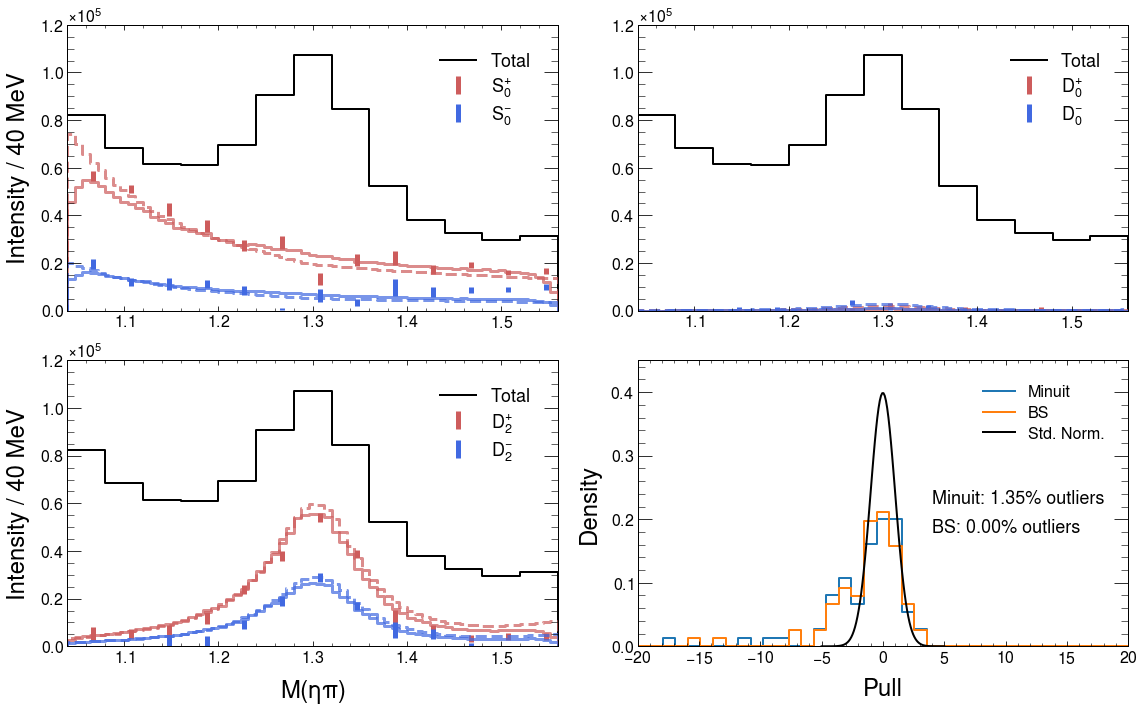

In [650]:
### Overlay kmatrix generated results and save the pulls
axes=plotSpecificAmps(inputDF,mi_df,["S0+","D0+","D2+"],"",useBSerrs=False)
[axes[iax].set_xlim(mi_lowMass,mi_upMass) for iax in range(3)]


pull_minuit=[]
pull_bs=[]
mi_centers=np.around(mi_df.mass.values,5)

kmatrix_gen="/d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/generated_plots/"
yieldMap_gen=loadPlotterLog(kmatrix_gen)
kmatrix_acc="/d/grid17/ln16/dselector_v3/study_pwa/kmatrix_fits/accepted_plots/"
yieldMap_acc=loadPlotterLog(kmatrix_acc)
for i,amp in enumerate(["S0+","D0+","D2+"]):
    for ref,c in zip(["+","-"],["indianred","royalblue"]):
        wave=amp+ref
        binwidth=(inputDF.mass[1]-inputDF.mass[0])
        gen,edges=load_kmatrix(kmatrix_gen,wave,yieldMap_gen,binwidth)
        acc,edges=load_kmatrix(kmatrix_acc,wave,yieldMap_acc,binwidth)
        centers=np.around(edges[:-1]+(edges[1]-edges[0])/2,5)
        hep.histplot(gen,edges,c=c,linewidth=3, linestyle='--',alpha=0.7,ax=axes[i])
        hep.histplot(acc,edges,c=c,linewidth=3, linestyle='-',alpha=0.7,ax=axes[i])
        
        predictions=getMatchingValues(mi_centers,centers,gen)
        pull_minuit.append((mi_df[wave]-predictions)/(mi_df[wave+"_err"]))
        pull_bs.append((mi_df[wave]-predictions)/((ustds[wave+"_err"]+lstds[wave+"_err"])/2)) ## yes its adding ustd and lstd since lstd has implict subtraction
pull_minuit=np.array(pull_minuit).flatten()
pull_bs=np.array(pull_bs).flatten()
        
### Draw the pulls
percentOutside=[]
for pulls,label in zip([pull_minuit,pull_bs],["Minuit","BS"]):
    pulls=pulls[(pulls>np.quantile(pulls,0.02))*(pulls<np.quantile(pulls,0.98))]
    h=np.histogram(pulls,bins=np.linspace(-20,20,40))
    percentOutside.append((1-h[0].sum()/len(pulls))*100)
    hep.histplot(h,ax=axes[3],density=True,label=label)
x = np.linspace(-5, 5, 100)
axes[3].plot(x, stats.norm.pdf(x, 0, 1),c='black',label="Std. Norm.")
axes[3].text(0.6,0.5,"Minuit: {:0.2f}% outliers".format(percentOutside[0]),size=18,transform=axes[3].transAxes)
axes[3].text(0.6,0.40,"BS: {:0.2f}% outliers".format(percentOutside[1]),size=18,transform=axes[3].transAxes)
axes[3].set_ylabel("Density",size=24)
axes[3].set_xlabel("Pull",size=24)
axes[3].legend()

plt.tight_layout()
plt.savefig(ofolder+"/kmatrix_compare_gen_and_pwa_results.pdf")

creating figure with 2 rows and 2 cols
S0++
D0++
D2++
S0+-
D0+-
D2+-
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_S0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_S0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D2++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D2+-.root


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


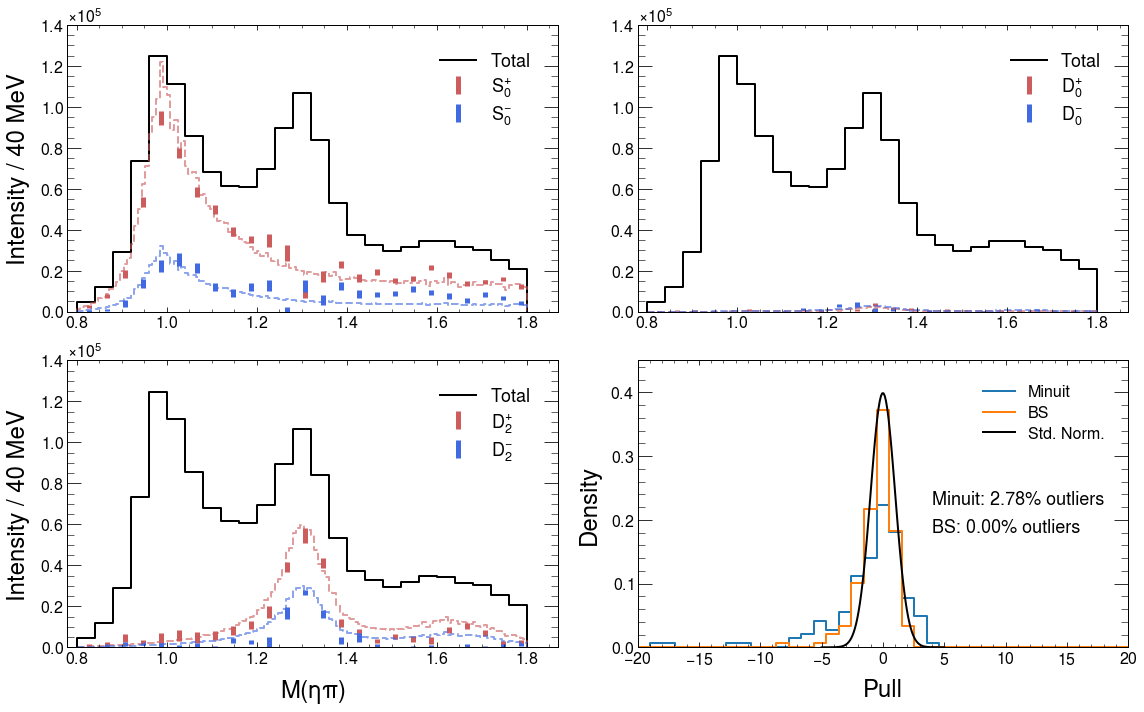

In [11]:
### Overlay kmatrix generated results and save the pulls
axes=plotSpecificAmps(inputDF,mi_df,["S0+","D0+","D2+"],"")

pull_minuit=[]
pull_bs=[]
mi_centers=np.around(mi_df.mass.values,5)

kmatrix_base="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/"
yieldMap=loadPlotterLog(kmatrix_base)
for i,amp in enumerate(["S0+","D0+","D2+"]):
    for ref,c in zip(["+","-"],["indianred","royalblue"]):
        wave=amp+ref
        binwidth=(inputDF.mass[1]-inputDF.mass[0])
        acc,edges=load_kmatrix(kmatrix_base,wave,yieldMap,binwidth)
        centers=np.around(edges[:-1]+(edges[1]-edges[0])/2,5)
#         axes[i].plot(centers,acc,c=c,linewidth=2, linestyle='--',alpha=0.6)
        hep.histplot(acc,edges,c=c,linewidth=2, linestyle='--',alpha=0.6,ax=axes[i])
        predictions=getMatchingValues(mi_centers,centers,acc)
        pull_minuit.append((mi_df[wave]-predictions)/(mi_df[wave+"_err"]))
        pull_bs.append((mi_df[wave]-predictions)/((ustds[wave+"_err"]+lstds[wave+"_err"])/2)) ## yes its adding ustd and lstd since lstd has implict subtraction
pull_minuit=np.array(pull_minuit).flatten()
pull_bs=np.array(pull_bs).flatten()
        
### Draw the pulls
percentOutside=[]
for pulls,label in zip([pull_minuit,pull_bs],["Minuit","BS"]):
    pulls=pulls[(pulls>np.quantile(pulls,0.02))*(pulls<np.quantile(pulls,0.98))]
    h=np.histogram(pulls,bins=np.linspace(-20,20,40))
    percentOutside.append((1-h[0].sum()/len(pulls))*100)
    hep.histplot(h,ax=axes[3],density=True,label=label)
x = np.linspace(-5, 5, 100)
axes[3].plot(x, stats.norm.pdf(x, 0, 1),c='black',label="Std. Norm.")
axes[3].text(0.6,0.5,"Minuit: {:0.2f}% outliers".format(percentOutside[0]),size=18,transform=axes[3].transAxes)
axes[3].text(0.6,0.40,"BS: {:0.2f}% outliers".format(percentOutside[1]),size=18,transform=axes[3].transAxes)
axes[3].set_ylabel("Density",size=24)
axes[3].set_xlabel("Pull",size=24)
axes[3].legend()

plt.tight_layout()
plt.savefig(ofolder+"/kmatrix_compare_gen_and_pwa_results.pdf")

# GlueX Data

In [418]:
floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/"

loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/010020/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/0200325/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/0325050/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/050075/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/st

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:122: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


array([['S0++', 'D0++', 'D1++', 'D2++']], dtype='<U4')

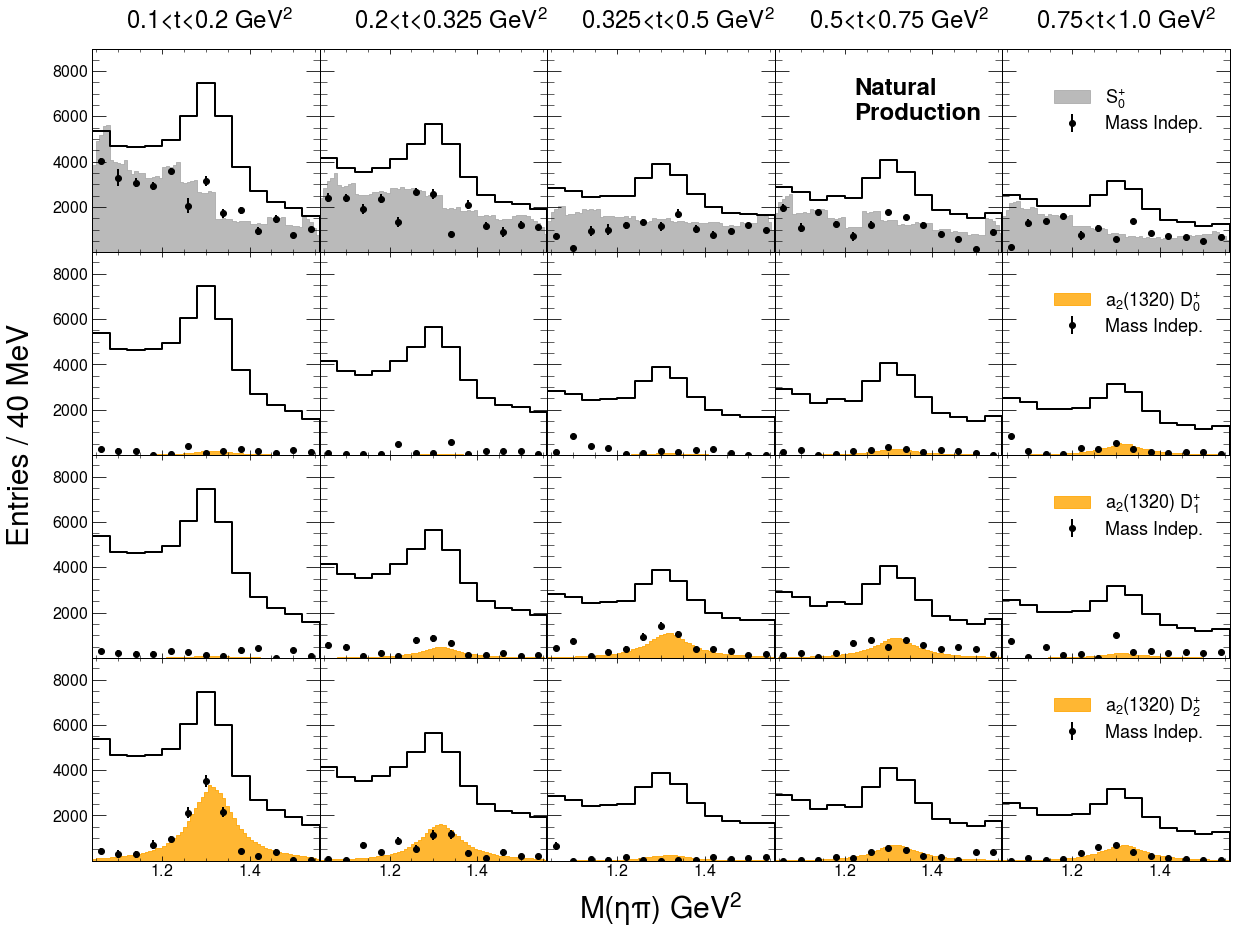

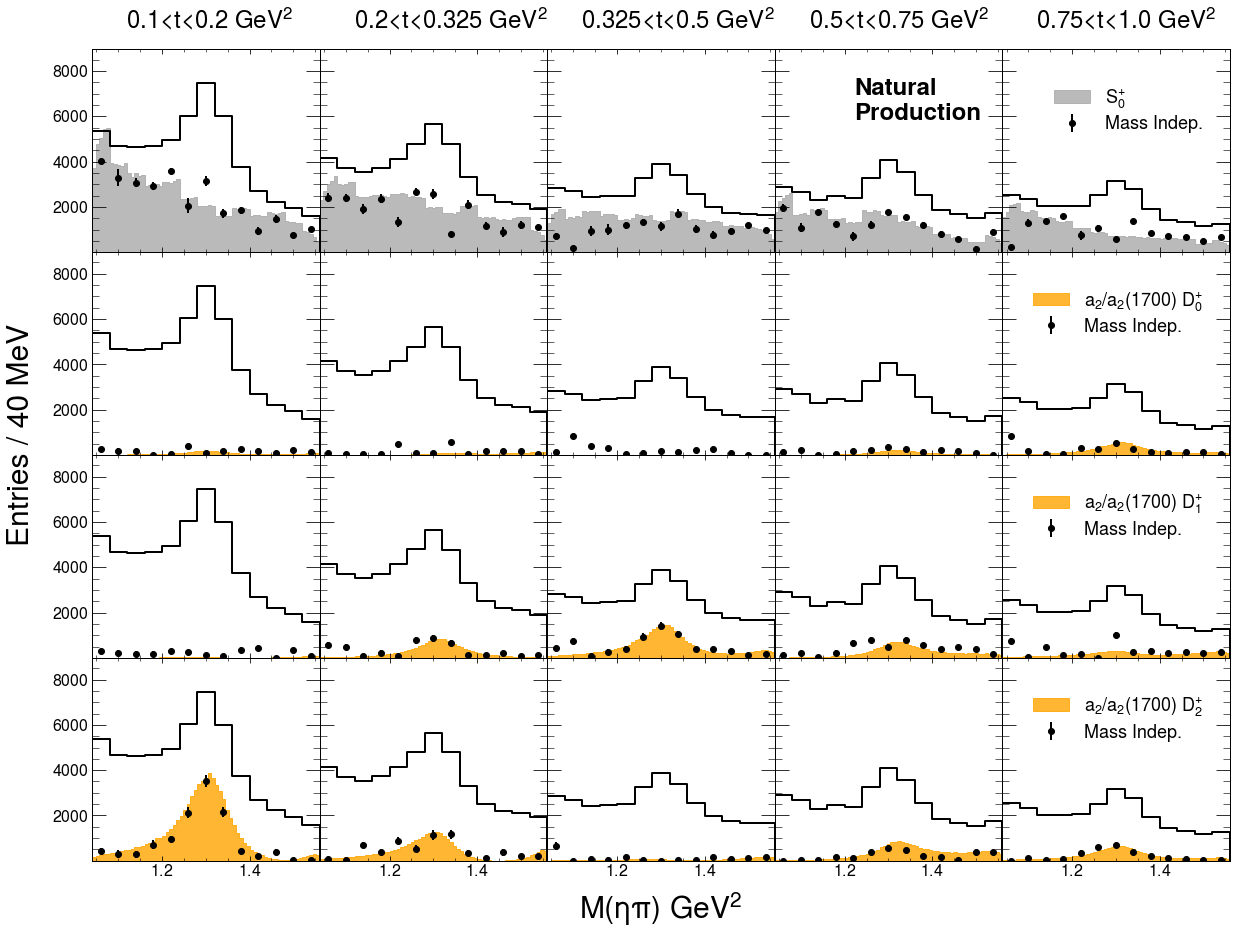

In [268]:
#################
# Basic Setup
#################
mi_lowMass=1.04
mi_upMass=1.56
mi_nbins=13
mi_waveset="D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

ts=["010020","0200325","0325050","050075","075100"]
midts=np.array([0.15,0.2625,0.4125,0.625,0.875])
tLabels=[f"0.1<t<0.2 $GeV^2$", f"0.2<t<0.325 $GeV^2$", f"0.325<t<0.5 $GeV^2$", f"0.5<t<0.75 $GeV^2$", f"0.75<t<1.0 $GeV^2$"]

# mi_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_t010020_m104180_noAccCorr/"
mis=[]
for t in ["010020","0200325",'0325050','050075','075100']:
    mi_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/"
    mi=loadMassIndependentData(mi_floc+t+"/",mi_waveset,
                                  np.linspace(mi_lowMass,mi_upMass,mi_nbins+1))
    mi['t']=t
    mis.append(mi)
mis=pd.concat(mis)

md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD/"
plotWaves(md_floc,mis,"m104156_a2",selectRef=[1],resonances=[""],plotMI=True,plotTheory=False,plotData=True)
md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD_includesa2p_bestOutOfTwo/"
plotWaves(md_floc,mis,"m104156_a2a2prime",selectRef=[1],resonances=["both"],plotMI=True,plotTheory=False,plotData=True)

In [269]:
import scipy.stats

def extractValue(floc,search):
    '''
    Extract value given a search string, i.e. bestMinimum in file location, floc
    '''
    with open(floc) as f:
        for line in f.readlines():
            if search in line:
                likelihood=line.split("\t")[-1].rstrip()
                break
    return float(likelihood)

import re
def extractNParameters(floc):
    '''
    Extracting the number of free parameters not really easy, we will search the logs for 
       the specified [search] string and search for npars around there
    input: floc - file location
    output: npars - number of parameters
    '''
    def is_not_float(string):
        try:
            float(string)
            return False
        except ValueError:  # String is not a number
            return True
    
    search="EXT PARAMETER"
    with open(floc) as f:
        lines=f.readlines()
        lines=np.array([line.rstrip().lstrip() for line in lines])
    idx=[i for i in range(len(lines)) if search in lines[i]][0]
    lines=lines[idx:idx+300] # Hopefully there isnt more than 300 parameters...
    lines=[line for line in lines if line!=""]
    lines=[line for line in lines if line[0].isnumeric()]
    lines=[re.sub('\s+',' ',line).split(" ") for line in lines]
    lines=[line for line in lines if len(line)<=6]
    lines=[line for line in lines if "fixed" not in line]
    lines=[line for line in lines if sum(list(map(is_not_float,line)))>=1]
    lines=np.array([int(line[0]) for line in lines if line[0].isdigit()])
    npars=len(set(lines))
    return npars


def extractPvalue(f1,f2):
    '''
    Extract p-values given 2 file locations
    '''
    min1=extractValue(f1+"etapi_result.fit","bestMinimum")
    a1=f1.split("_")[-1].rstrip().rstrip('/')
    npar1=extractNParameters(f1+"../fitAttempt"+a1+".log")
    min2=extractValue(f2+"etapi_result.fit","bestMinimum")
    a2=f2.split("_")[-1].rstrip().rstrip('/')
    npar2=extractNParameters(f2+"../fitAttempt"+a2+".log")

    deltaLL=min2-min1
    deltaNPars=abs(npar2-npar1)
    pvalue=1-stats.chi2.cdf(deltaLL, deltaNPars)
    return deltaLL, deltaNPars, pvalue


performance=[]
for t in ts:
    f1="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD_includesa2p_bestOutOfTwo/"+t+"/"
    f2="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD/"+t+"/"
    a1=loadLastAttempt(f1)
    a2=loadLastAttempt(f2)
    performance.append(extractPvalue(f1,a1,f2,a2))
performance=np.array(performance)

In [270]:
### Alternative to Null
performance=pd.DataFrame(performance,columns=["DeltaLL","DOF","p-value"])
performance["t"]=tLabels
performance=performance[["t","DeltaLL","DOF","p-value"]]
performance

t     DeltaLL   DOF       p-value
0    0.1<t<0.2 $GeV^2$  124.721544  14.0  0.000000e+00
1  0.2<t<0.325 $GeV^2$   52.233357  14.0  2.567405e-06
2  0.325<t<0.5 $GeV^2$  353.829951  14.0  0.000000e+00
3   0.5<t<0.75 $GeV^2$  100.882494  14.0  3.219647e-15
4   0.75<t<1.0 $GeV^2$  333.504934  14.0  0.000000e+00

# Phase difference

In [271]:
floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD_includesa2p_bestOutOfTwo/010020/etapi_result0.fit"

In [272]:
def loadBWresults(ref="Positive"):
    bwProdCoef=[line for line in lines if "EtaPi0_000::"+ref+"Re" in line]
    bwProdCoef=dict(line.split("\t") for line in bwProdCoef)
    amps=list(set([line.split("_")[-2].split("::")[-1] for line in lines if "EtaPi0_000::"+ref+"Re" in line]))
    prefix="EtaPi0_000::"+ref+"Re::"
    return {amp:float(bwProdCoef[prefix+amp+"_re"])+1j*float(bwProdCoef[prefix+amp+"_im"]) for amp in amps}

def loadPcwiseResults(ref="Pos"):
    return {"pcwsBin_"+str(n)+ref: float(pcwise["pcwsBin_"+str(n)+"Re"+ref])+1j*float(pcwise["pcwsBin_"+str(n)+"Im"+ref]) for n in range(nbins)}


# https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution 
###  gives us the propagator of the Rel. BW distribution but seems to be off by a factor of -1. The phase starts > pi
###  This is fine, since what we measure is the intensity and a -1 drops when squaring
# https://pdg.lbl.gov/2019/reviews/rpp2019-rev-resonances.pdf EQUATION 48.18
###  PDG also suggests that the denominator should be multiplied by -1 
def T(m,m0,Gamma):
#     return Gamma/2/(m0-m-1j*Gamma/2)
    gamma=np.sqrt(m0**2*(m0**2+Gamma**2))
    k=2*np.sqrt(2)*m0*Gamma*gamma/np.pi/np.sqrt(m0**2+gamma)
    return -1*np.sqrt(k)/((m**2-m0**2)+1j*m0*Gamma)

def mapPhases(phase):
#     return phase
    return (phase+2*np.pi)%(2*np.pi)

In [273]:
####################################################
# THIS BLOCK OF CODE LOADS THE FIT RESULTS AND ATTEMPTS TO PARSE IT TO EXTRACT
#    THE PRODUCTION COEFFICIENTS AND BW RESONANCE PARAMETERS
####################################################

with open(floc) as f:
    lines=f.readlines()
    lines=[line.rstrip().lstrip() for line in lines]
_lines=lines

interestingStartingWords=["EtaPi0_000","pcwsBin","a2"] # all pols constrained to equal, lets look at 0 only
lines=[line for line in lines if np.any([line.startswith(word) for word in interestingStartingWords])==1] # find important lines
lines=[line for line in lines if not "parScale" in line] # remove all parScale lines
lines=[line for line in lines if len(line.split("\t"))==2] # key value pairs are tab separated

# LOAD - Lines related to a2 resonance parameters
bwpars=[line for line in lines if "a2" in line]
bwpars=dict(line.split("\t") for line in bwpars)
bwpars={k:float(v) for k,v in bwpars.items()}

# LOAD - BW PRODUCTION COEFFICIENTS
bwPosRe=loadBWresults("Positive")
bwNegRe=loadBWresults("Negative")

# LOAD - Binning of the pcwise S-wave
samplePiecewiseLine=[line for line in _lines if "Piecewise" in line][0]
binning=samplePiecewiseLine.split(" ")[3:6]
binning=[float(binning[0]),float(binning[1]),int(binning[2])]
nbins=binning[2]
edges=np.linspace(binning[0],binning[1],binning[2]+1)
centers=edges[:-1]+(edges[1]-edges[0])/2

# LOAD - PIECEWISE BINNED PRODUCTION COEFFICIENTS
pcwise_pos=loadPcwiseResults("Pos")
pcwise_neg=loadPcwiseResults("Neg")

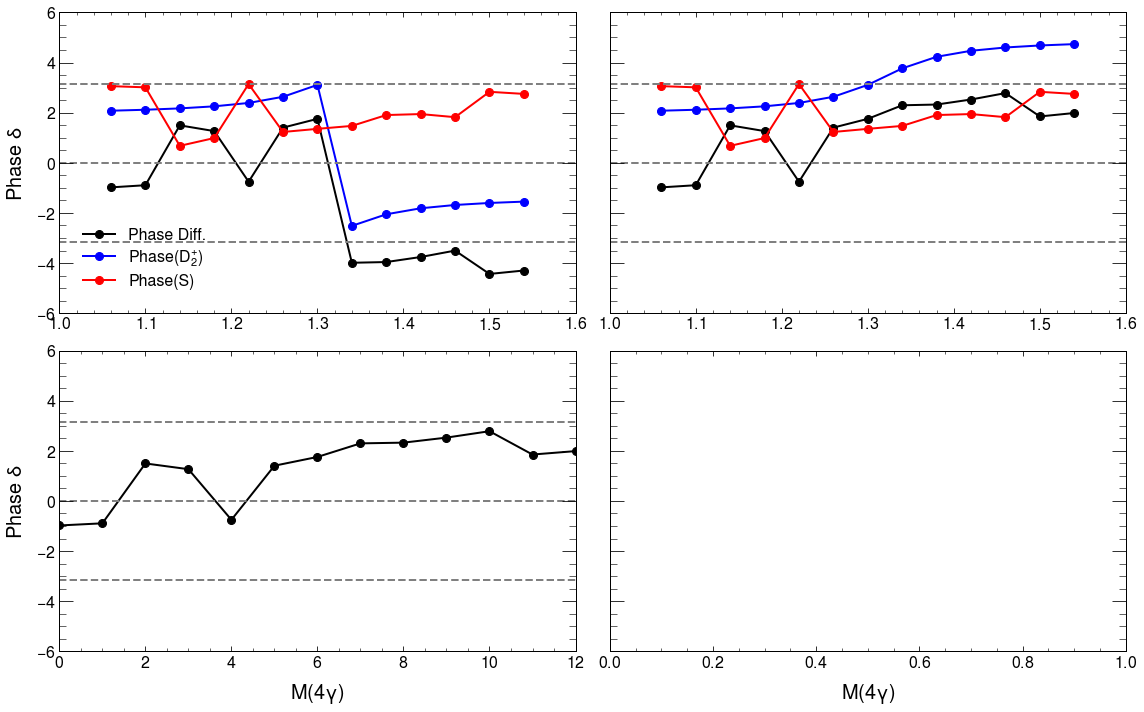

In [274]:
fig,axes=plt.subplots(2,2,figsize=(16,10),sharey=True)
axes=axes.flatten()

wave="D2++"
a2_bwProdCoef=bwPosRe[wave]
a2prime_bwProdCoef=bwPosRe["p"+wave]
a2_Ts=T(centers,bwpars["a2mass"],bwpars["a2width"])
a2prime_Ts=T(centers,bwpars["a2massprime"],bwpars["a2widthprime"])
S0p=np.array(list(pcwise_pos.values()))
S0n=np.array(list(pcwise_neg.values()))

### ---------------------------------
a2_bwPhase=np.angle(a2_bwProdCoef*a2_Ts)
a2prime_bwPhase=np.angle(a2prime_bwProdCoef*a2prime_Ts)
pcwisePhase=np.angle(S0p) if wave[-1]=="+" else np.angle(S0n)
phaseDiff=a2_bwPhase-pcwisePhase

axes[0].plot(centers,phaseDiff,c='black',marker='o',label="Phase Diff.")
axes[0].plot(centers,a2_bwPhase,c='blue',marker='o',label=f"$Phase({prettyWave[wave]})$")
axes[0].plot(centers,pcwisePhase,c='red',marker='o',label="Phase(S)")
axes[0].axhline(-np.pi,c='gray',linestyle='--')
axes[0].axhline(0,c='gray',linestyle='--')
axes[0].axhline(np.pi,c='gray',linestyle='--')
axes[0].legend()

### ---------------------------------
a2_bwPhase=mapPhases(np.angle(a2_bwProdCoef*a2_Ts))
a2prime_bwPhase=mapPhases(np.angle(a2prime_bwProdCoef*a2prime_Ts))
pcwisePhase=mapPhases(np.angle(S0p) if wave[-1]=="+" else np.angle(S0n))
phaseDiff=a2_bwPhase-pcwisePhase

axes[1].plot(centers,phaseDiff,c='black',marker='o',label="Phase Diff.")
axes[1].plot(centers,a2_bwPhase,c='blue',marker='o',label=f"$Phase({prettyWave[wave]})$")
axes[1].plot(centers,pcwisePhase,c='red',marker='o',label="Phase(S)")
axes[1].axhline(-np.pi,c='gray',linestyle='--')
axes[1].axhline(0,c='gray',linestyle='--')
axes[1].axhline(np.pi,c='gray',linestyle='--')

### ---------------------------------
b=S0p/abs(S0p)
a=a2_bwProdCoef*a2_Ts/abs(a2_bwProdCoef*a2_Ts)
c=np.log(b/a)
assert np.prod(c.real<1e-10)
p=(c*1j).real
axes[2].plot(p,marker='o',c='black')
axes[2].axhline(-np.pi,c='gray',linestyle='--')
axes[2].axhline(0,c='gray',linestyle='--')
axes[2].axhline(np.pi,c='gray',linestyle='--')


axes[0].set_ylabel(r"Phase $\delta$")
axes[2].set_ylabel(r"Phase $\delta$")
axes[2].set_xlabel(r"$M(4\gamma)$")
axes[3].set_xlabel(r"$M(4\gamma)$")
plt.tight_layout()

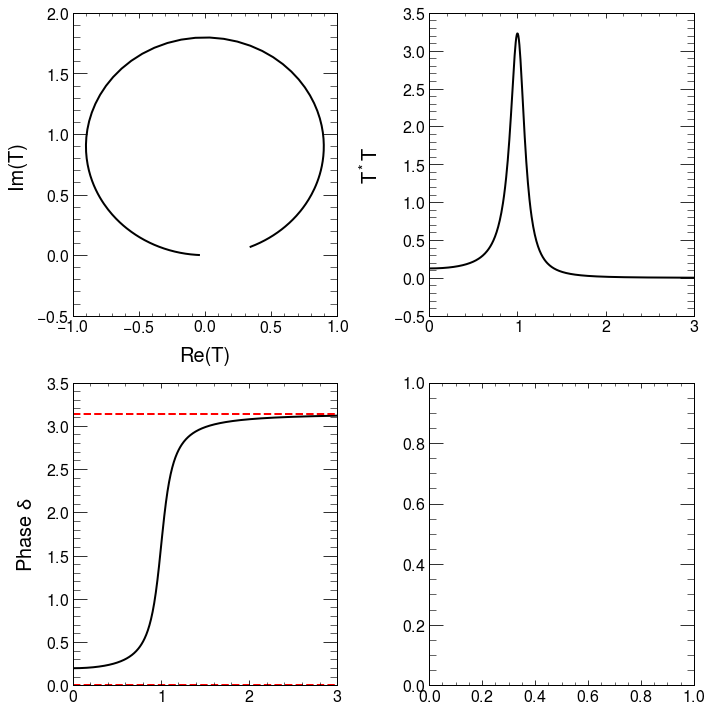

In [275]:
############################################
# TESTING THE CODE, MAKING THEORY PLOT
############################################

_m=np.linspace(0,3,500)
t=T(_m,1,0.2)
fig,axes=plt.subplots(2,2,figsize=(10,10))
axes=axes.flatten()

axes[0].plot(t.real,t.imag,c='black')
axes[0].set_xlabel("Re(T)")
axes[0].set_ylabel("Im(T)")

axes[1].plot(_m,(t*np.conjugate(t)).real,c='black')
axes[1].set_ylabel(r"$T^*T$")

axes[2].plot(_m,np.angle(t),c='black')
axes[2].set_ylabel(r"Phase $\delta$")
axes[2].axhline(0,c='red',linestyle='--')
axes[2].axhline(np.pi,c='red',linestyle='--')


plt.tight_layout()

# Hybrid Fit Results

In [1828]:
#######################################################
# OLDER FUNCTION THAT DOES NOT FOLLOW THE NEW DIRECTORY LAYOUT
########################################################
# def plotWaves(floc,mi_df,ofileTag,
#               selectRef=[0,1],
#               resonances=["","p"],
#               wavesets=np.array([["S0+-","D1--","D0+-","D1+-"],["S0++","D0++","D1++","D2++"]]),
#               plotMI=False,plotTheory=False,plotData=True,
#               histtype="fill"):
#     '''
#     md_floc: folder location containing the etapi_plotter root files
#     mi_df: dataframe containing the fit results for mass-indep fits
#     ofiletag: output file tag to include in the output file name -> positiveRef_[tag].pdf
#     refs: where 0,1 represents -,+ reflectivies to plot. i.e. [0,1] will plot both [1] will just plot + ref
#     resonaces=["","p"] where ""=a2 or "p"=a2prime or set resonances=["both"] to merge (for mass-indep comparison)
#     plotMI: should we plot the mass-independent fit results located in mi_df?
#     plotTheroy: should we overlay Vincent's predictions?
#     '''
#     fileName="etapi_plot_"
#     wavesets=wavesets[selectRef]
#     refs=np.array(["negativeRef","positiveRef"])[selectRef]
#     naturalities=np.array(["Unnatural\nProduction","Natural\nProduction"])[selectRef]
#     xlabel=r"$M(\eta\pi)$ $GeV^2$"
#     ylabel=r"Entries / 40 MeV"

#     #### Get the maximum value of the D2++ wave in the smallest t-bin so that we can scale all theory curves to it
#     histdat, _, width = loadMergedPols(floc+"010020/"+fileName+"D2++.root","Metapi_40MeVBindat",["000","045","090","135"])
#     histacc, _, widthacc = loadMergedPols(floc+"010020/"+fileName+"D2++.root","Metapiacc",["000","045","090","135"])
#     binScaleFactor=width/widthacc
#     maxD2pp=histacc.max()*binScaleFactor
#     theory=constructAltTheory(1)
#     scaleFactor=maxD2pp/theory["D2++"].max()    
#     for iws,waveset,ref,naturality in zip(range(len(wavesets)),wavesets,refs,naturalities):
#         fig,axes=plt.subplots(4,5,figsize=(20,14),sharex=True,sharey=True)
#         for prime in resonances:
#             for iw,wave in enumerate(waveset):
#                 for it,t,tLabel in zip(range(len(ts)),ts,tLabels):
#                     ############### Load the data to be plotted - ok to overwrite histdat and histacc now
#                     if wave[0]=="D":
#                         selectWave=prime+wave if prime in ["","p"] else wave+"_p"+wave
#                         if prime=="":
#                             histLabel=f"$a_2(1320)$ ${prettyWave[wave]}$"
#                         elif prime=="p":
#                             histLabel=f"$a_2(1700)$ ${prettyWave[wave]}$"
#                         else:
#                             histLabel=r"$a_2/a_2(1700)$"+f" ${prettyWave[wave]}$"
#                     else: #All non-D waves
#                         selectWave=prime+wave if prime in ["","p"] else wave
#                         histLabel=f"${prettyWave[wave]}$"
#                     fileLoc=floc+t+"/"+fileName+selectWave+".root"
#                     if not os.path.exists(fileLoc):
#                         continue
#                     histdat,edges,_=loadMergedPols(fileLoc,"Metapi_40MeVBindat",["000","045","090","135"])
#                     histbkg,_,_=loadMergedPols(fileLoc,"Metapi_40MeVBinbkg",["000","045","090","135"])
#                     values=histdat-histbkg
#                     histacc,edgesacc,_=loadMergedPols(fileLoc,"Metapiacc",["000","045","090","135"])
#                     valuesacc=histacc*binScaleFactor
#                     if plotData:
#                         hep.histplot(values,edges,c='black',ax=axes[iw,it])
#                     if wave[3]=="+" and (prime=="" or prime=="both"):
#                         color="darkgray" if wave[0]=="S" else "orange"
#                     if wave[3]=="+" and prime=="p":
#                         color="royalblue"
#                     if wave[3]=="-" and (prime=="" or prime=="both"):
#                         color="darkgray" if wave[0]=="S" else "orange"
#                     if wave[3]=="-" and prime=="p":
#                         color="royalblue"
#                     hep.histplot(valuesacc,edgesacc,color=color,ax=axes[iw,it],alpha=0.8,label=histLabel,histtype=histtype)

#                     #### Mass independent results
#                     if plotMI:
#                         mi=mi_df[mi_df.t==t]
#                         axes[iw,it].errorbar(mi.mass,mi[wave],yerr=mi[wave+"_err"],c='black',fmt='o',markersize=6,label="Mass Indep.")

#                     #### Theory curves
#                     if plotTheory:
#                         theory=loadTheory(it+1)
#                         theory=constructAltTheory(it+1)
#                         if wave in theory.columns and prime=="":
#                             axes[iw,it].plot(theory.mass,theory[wave].values*scaleFactor,c="mediumseagreen",label="Theory",linewidth=3)
                            
#                     ## Draw text with t-bin
#                     if iw==0:
#                         plt.text(0.15, 1.1, tLabel, fontsize=24, transform=axes[iw,it].transAxes)

#                     if it==len(ts)-1:
#                         axes[iw,it].legend(prop={"size":18},bbox_to_anchor=(1,0.95))
#                     if it==0:
#                         maxValInT=max(values)
#                     axes[iw,it].set_ylim(0.001,maxValInT*1.2)
#                     xmin=edges[:-1][histdat>0][0] # edges has 1 more dimension than the counts, need to account for that
#                     xmax=edges[1:][histdat>0][-1]
#                     axes[iw,it].set_xlim(xmin,xmax)

#         axes[-1,2].set_xlabel(xlabel,size=30)
#         axes[1,0].set_ylabel(ylabel,size=30)
#         axes[1,0].yaxis.set_label_coords(-0.25, 0.1)
        
#         plt.text(0.35, 0.65, naturality, fontsize=24, transform=axes[0,3].transAxes, weight="bold")
#         plt.tight_layout()
#         plt.subplots_adjust(wspace=0, hspace=0)
#         plt.savefig(ofolder+ref+"_"+ofileTag+".pdf")
        
#     return wavesets


def loadValue(floc,search="bestMinimum"):
    with open(floc+"etapi_result.fit") as f:
        lines=[line.rstrip().lstrip() for line in f.readlines()]
        line=[float(line.split("\t")[1]) for line in lines if line.split("\t")[0]==search][0]
    return line

def getBestFiles(floc,verbose=True):
    ########################################################
    # OBTAIN A LIST OF ALL THE FILES WE WOULD LIKE TO PLOT 
    #   Modify the list (i.e. based on best likelihood) to select what you want to show
    ########################################################
    files=np.array([])
    bestFiles=np.array([])
    for t in ts:
        fs=np.array([floc+"/"+t+"/"+f+"/" for f in os.listdir(floc+"/"+t) if t in f])
        nlls=np.array([loadValue(f) for f in fs])
        order=np.argsort(nlls)
        fs=fs[order]
        nlls=nlls[order]
        if verbose:
            [print(f"{file} | NLL: {nll:0.0f} : DeltaBestNLL: {nll-nlls[0]:0.0f}") for file,nll in zip(fs,nlls)]
        bestFiles=np.append(bestFiles,fs[0])
        files=np.append(files,fs)
    return bestFiles,files


def plotWaves(floc,mi_df,ofileTag,
              selectRef=[0,1],
              resonances=["","p"],
              wavesets=np.array([["S0+-","D1--","D0+-","D1+-"],["S0++","D0++","D1++","D2++"]]),
              plotMI=False,plotTheory=False,plotData=True,plotBest=True,useBSerr_MI=False,
              histtype="fill"):
    '''
    md_floc: folder location containing the etapi_plotter root files
    mi_df: dataframe containing the fit results for mass-indep fits
    ofiletag: output file tag to include in the output file name -> positiveRef_[tag].pdf
    refs: where 0,1 represents -,+ reflectivies to plot. i.e. [0,1] will plot both [1] will just plot + ref
    resonaces=["","p"] where ""=a2 or "p"=a2prime or set resonances=["both"] to merge (for mass-indep comparison)
    plotMI: should we plot the mass-independent fit results located in mi_df?
    plotTheroy: should we overlay Vincent's predictions?
    '''
    fileName="etapi_plot_"
    wavesets=wavesets[selectRef]
    refs=np.array(["negativeRef","positiveRef"])[selectRef]
    naturalities=np.array(["Unnatural\nProduction","Natural\nProduction"])[selectRef]
    xlabel=r"$M(\eta\pi)$ $GeV^2$"
    ylabel=r"Entries / 40 MeV"
            
    bestFiles, files = getBestFiles(floc)
    if plotBest:
        files=bestFiles
            
    ########################################################
    #### With multiple reinitializations obtaining a scale factor is a bit ambiguious. 
    ####   currently we will just take the average D2++ amplitude as the scale to match
    ########################################################
    theory=constructAltTheory(1)
    fs=[f for f in files if ts[0] in f]
    assert len(fs)>0 # if there are no sub folders found you might be using the older folder scheme
    maxD2pps=[]
    for i,f in enumerate(fs):
        #### Get the maximum value of the D2++ wave in the smallest t-bin so that we can scale all theory curves to it
        histdat, edges, width = loadMergedPols(f+fileName+"D2++.root","Metapi_40MeVBindat",["000","045","090","135"])
        histacc, edgesacc, widthacc = loadMergedPols(f+fileName+"D2++.root","Metapiacc",["000","045","090","135"])
        binScaleFactor=width/widthacc
        maxD2pps.append(histacc.max()*binScaleFactor)
    xmin=edges[:-1][histdat>0][0] # edges has 1 more dimension than the counts, need to account for that
    xmax=edges[1:][histdat>0][-1]
    maxD2pp=np.mean(maxD2pps)
    if plotBest:
        assert(len(maxD2pps)==1)
    scaleFactor=maxD2pp/theory["D2++"].max()       

    ########################################################
    # Begin drawing plots we have selected
    ########################################################
    md_curves=[]
    for iws,waveset,ref,naturality in zip(range(len(wavesets)),wavesets,refs,naturalities):
        fig,axes=plt.subplots(4,5,figsize=(20,14),sharex=True,sharey=True)
        for prime in resonances:
            for iw,wave in enumerate(waveset):
                for it,t,tLabel in zip(range(len(ts)),ts,tLabels):
                    ############### Load the data to be plotted - ok to overwrite histdat and histacc now
                    if wave[0]=="D":
                        selectWave=prime+wave if prime in ["","p"] else wave+"_p"+wave
                        if prime=="":
                            histLabel=f"$a_2(1320)$ ${prettyWave[wave]}$"
                        elif prime=="p":
                            histLabel=f"$a_2(1700)$ ${prettyWave[wave]}$"
                        else:
                            histLabel=r"$a_2/a_2(1700)$"+f" ${prettyWave[wave]}$"
                    else: #All non-D waves
                        selectWave=prime+wave if prime in [""] else wave
                        histLabel=f"${prettyWave[wave]}$"
                        
                    rootFileName=fileName+selectWave+".root"
                    fs=[floc+"/"+t+"/"+f+"/" for f in os.listdir(floc+"/"+t) if t in f]
#                     fs=[floc+"/"+t+"/" for f in os.listdir(floc+"/"+t) if t in f]
                    maxValInT=0 if it==0 else maxValInT
                    for i,fileLoc in enumerate(fs):
                        if not os.path.exists(fileLoc) or not fileLoc in files:
                            continue
                        histdat,_,_=loadMergedPols(fileLoc+rootFileName,"Metapi_40MeVBindat",["000","045","090","135"])
                        histbkg,_,_=loadMergedPols(fileLoc+rootFileName,"Metapi_40MeVBinbkg",["000","045","090","135"])
                        values=histdat-histbkg
                        maxValInT=max(values) if max(values)>maxValInT and it==0 else maxValInT
                        histacc,_,_=loadMergedPols(fileLoc+rootFileName,"Metapiacc",["000","045","090","135"])
                        valuesacc=histacc*binScaleFactor
                        if plotData:
                            hep.histplot(values,edges,c='black',ax=axes[iw,it])
                            
                        if (prime=="" or prime=="both")*(wave[0]=="D"):
                            color="orange"
                        elif (prime=="p")*(wave[0]=="D"):
                            color="royalblue"
                        else:
                            color='darkgray'    
                        
                        _label = histLabel if i==0 else ""
                        _alpha = 1.0 if fileLoc in bestFiles else 0.4
                        _linewidth = 4 if fileLoc in bestFiles else 2
                        hep.histplot(valuesacc,edgesacc,color=color,ax=axes[iw,it],alpha=_alpha,label=_label,linewidth=_linewidth,histtype=histtype)
                        if fileLoc in bestFiles:
                            md_curves.append([ref,prime,wave,t,valuesacc,edgesacc[:-1]+(edgesacc[1]-edgesacc[0])/2])
                    

                    #### Mass independent results
                    mi=mi_df[mi_df.t==t]
                    if useBSerr_MI:
                        yerr=(mi[wave+"_err_bsl"],mi[wave+"_err_bsu"])
                        label="Mass Indep.\nBS uncert."
                    else:
                        yerr=mi[wave+"_err"]
                        label="Mass Indep.\nMinuit uncert."
                    if plotMI and (prime=="" or prime=="both"):
                        axes[iw,it].errorbar(mi.mass,mi[wave],yerr=yerr,c='black',fmt='o',markersize=2,label=label,zorder=99)
                        
                    #### Theory curves
                    if plotTheory:
                        theory=loadTheory(it+1)
                        theory=constructAltTheory(it+1)
                        if wave in theory.columns and prime=="":
                            axes[iw,it].plot(theory.mass,theory[wave].values*scaleFactor,c="mediumseagreen",label="Theory",linewidth=3)
                            
                    ## Draw text with t-bin
                    if iw==0:
                        plt.text(0.15, 1.1, tLabel, fontsize=24, transform=axes[iw,it].transAxes)

                    if it==len(ts)-1:
                        axes[iw,it].legend(prop={"size":18},loc=1)#,bbox_to_anchor=(1,0.95))
                    axes[iw,it].set_ylim(0.001,maxValInT*1.2)
                    axes[iw,it].set_xlim(xmin,xmax)

        axes[-1,2].set_xlabel(xlabel,size=30)
        axes[1,0].set_ylabel(ylabel,size=30)
        axes[1,0].yaxis.set_label_coords(-0.25, 0.1)
        
        plt.text(0.35, 0.65, naturality, fontsize=24, transform=axes[0,3].transAxes, weight="bold")
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(ofolder+ref+"_"+ofileTag+".pdf")
        
    md_curves=pd.DataFrame(md_curves,columns=["refl","prime","wave","t","intensity","mass"])
    return bestFiles, md_curves


def getConstraint(sampleCfg,search):
    with open(sampleCfg) as sampleCfg:
        lines=sampleCfg.readlines()
        lines=[line for line in lines if "parameter" in line and "#" not in line]
        lines=[line for line in lines if line.split(" ")[1]==search]
        if len(lines)!=1:
            raise ValueError("Could not extract constraint lines in cfg file")
        lines=lines[0].rstrip().lstrip()
        if "gaussian" in lines:
            mean=float(lines.split(" ")[4])
            uncert=float(lines.split(" ")[5])
        elif "fixed" in lines:
            mean=float(lines.split(" ")[2])
            uncert=0
        else:
            raise ValueError("getConstraint only accepts 'gaussian' or 'fixed' constraints")
    return mean, uncert

def compareBWparams(floc):
    fig,axes=plt.subplots(2,2,figsize=(16,10),sharex=True)
    axes=axes.flatten()
    files=np.array([])
    variables=["a2mass","a2width","a2massprime","a2widthprime"]
    for midt,t in zip(midts,ts):
        fs=np.array([floc+"/"+t+"/"+f+"/" for f in os.listdir(floc+"/"+t) if t in f])
        values=[np.array([loadValue(f,variable) for f in fs]) for variable in variables]
        nlls=np.array([loadValue(f) for f in fs])
        [axes[i].scatter([midt]*len(value),value) for i,value in enumerate(values)]

#     pdgs=[1.3177,0.1111,1.698,0.265] # a2 mass, a2 width, a2prime mass, a2prime width
#     #pdg_errs=[0.0014,0.0024,0.04,0.060] # pdg values for the etapi channel
#     pdg_errs=[0.0014,0.0055,0.04,0.060]

    print(floc+"*/*cfg")
    print(glob.glob(floc+"*/*cfg"))

    pdgs=[]
    pdg_errs=[]
    mean, uncert = getConstraint(glob.glob(floc+"*/*cfg")[0],"a2mass")
    pdgs.append(mean)
    pdg_errs.append(uncert)
    mean, uncert = getConstraint(glob.glob(floc+"*/*cfg")[0],"a2width")
    pdgs.append(mean)
    pdg_errs.append(uncert)
    mean, uncert = getConstraint(glob.glob(floc+"*/*cfg")[0],"a2massprime")
    pdgs.append(mean)
    pdg_errs.append(uncert)
    mean, uncert = getConstraint(glob.glob(floc+"*/*cfg")[0],"a2widthprime")
    pdgs.append(mean)
    pdg_errs.append(uncert)

    
    labels=[r"$a_2(1320)~mass$",r"$a_2(1320)~width$",r"$a_2(1700)~mass$",r"$a_2(1700)~width$"]

    for i, pdg, pdg_err, label in zip(range(4),pdgs,pdg_errs,labels):
        axes[i].set_xlim(0.1,1)
        axes[i].set_ylabel(label,size=32)
        axes[i].axhline(pdg,c='gray',linestyle='--')
        axes[i].fill_between(np.linspace(0,1,100),[pdg-pdg_err]*100,[pdg+pdg_err]*100,color='lightgray',alpha=0.4)

    axes[2].set_xlabel(r"$-t~GeV^2$",size=32)
    axes[3].set_xlabel(r"$-t~GeV^2$",size=32)
    plt.tight_layout()
    
import scipy.stats

def extractValue(floc,search):
    '''
    Extract value given a search string, i.e. bestMinimum in file location, floc
    '''
    with open(floc) as f:
        for line in f.readlines():
            if search in line:
                likelihood=line.split("\t")[-1].rstrip()
                break
    return float(likelihood)

import re
def extractNParameters(floc):
    '''
    Extracting the number of free parameters not really easy, we will search the logs for 
       the specified [search] string and search for npars around there
    input: floc - file location
    output: npars - number of parameters
    '''
    def is_not_float(string):
        try:
            float(string)
            return False
        except ValueError:  # String is not a number
            return True
    
    search="EXT PARAMETER"
    with open(floc) as f:
        lines=f.readlines()
        lines=np.array([line.rstrip().lstrip() for line in lines])
    idx=[i for i in range(len(lines)) if search in lines[i]][0]
    lines=lines[idx:idx+300] # Hopefully there isnt more than 300 parameters...
    lines=[line for line in lines if line!=""]
    lines=[line for line in lines if line[0].isnumeric()]
    lines=[re.sub('\s+',' ',line).split(" ") for line in lines]
    lines=[line for line in lines if len(line)<=6]
    lines=[line for line in lines if "fixed" not in line]
    lines=[line for line in lines if sum(list(map(is_not_float,line)))>=1]
    lines=np.array([int(line[0]) for line in lines if line[0].isdigit()])
    npars=len(set(lines))
    return npars

def extractNParametersV2(f1):
    '''
    Sadly extractNParameters() cant really stand on its own, will use parts of extractPvalue() to determine the iteartion number
    Create a simple function that grabs the iteration and uses extractNParameters()
    '''
    a1=f1.split("_")[-1].rstrip().rstrip('/')
    npar1=extractNParameters(f1+"../fitAttempt"+a1+".log")
    return npar1

def extractPvalue(f1,f2):
    '''
    Extract p-values given 2 file locations
    '''
    min1=extractValue(f1+"etapi_result.fit","bestMinimum")
    a1=f1.split("_")[-1].rstrip().rstrip('/')
    npar1=extractNParameters(f1+"../fitAttempt"+a1+".log")
    min2=extractValue(f2+"etapi_result.fit","bestMinimum")
    a2=f2.split("_")[-1].rstrip().rstrip('/')
    npar2=extractNParameters(f2+"../fitAttempt"+a2+".log")

    deltaLL=min2-min1
    deltaNPars=abs(npar2-npar1)
    pvalue=1-stats.chi2.cdf(deltaLL, deltaNPars)
    return deltaLL, deltaNPars, pvalue


def comparePerformance(f1,f2):
    performance=[]
    bestFiles1=getBestFiles(f1,verbose=False)[0]
    bestFiles2=getBestFiles(f2,verbose=False)[0]
    for f1,f2 in zip(bestFiles1,bestFiles2):
        performance.append(extractPvalue(f1,f2))
    performance=np.array(performance)

    ### Alternative to Null
    ### f2 - f1
    performance=pd.DataFrame(performance,columns=["DeltaLL","DOF","p-value"])
    performance["t"]=tLabels
    performance=performance[["t","DeltaLL","DOF","p-value"]]
    print("============  Negative DeltaLL Favors Alternative   =================")
    print(performance)

In [1823]:
#################
# Basic Setup
#################
mi_lowMass=1.04
mi_upMass=1.80
mi_nbins=19
mi_waveset="D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

ts=["010020","0200325","0325050","050075","075100"]
midts=[0.15,0.2625,0.4125,0.625,0.875]
tLabels=[f"0.1<t<0.2 $GeV^2$", f"0.2<t<0.325 $GeV^2$", f"0.325<t<0.5 $GeV^2$", f"0.5<t<0.75 $GeV^2$", f"0.75<t<1.0 $GeV^2$"]

## OLD RESULTS
# md_floc="/d/grid17/ln16/myDSelector/amptools/mass_dep_fits/fitResults_tbins5_SDDp_allConverged_gausPars_malteSub_includes_a2prime/"
# flux_floc="/d/grid17/ln16/myDSelector/amptools/mass_dep_fits/flux/"

#######################
#### LOAD MASS DEPENDENT FIT RESULTS
#######################
## V0 - RESULTS SHOWN A LOT OF TIMES NOW
# md_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/fitResults/" 

## V1 - 5 converged fits per bin with Gaus constrained a2 and a2prime
## V2 - 5 converged fits per bin with Gaus constrained a2. a2prime fixed to pdg values
## V3 - 5 converged fits per bin with Gaus constrained a2. a2prime fixed to pdg values. Fixed to 1.04 to 1.56 region
## V4 - 5 converged fits per bin with Gaus constrained a2. a2prime fixed to pdg values. Fixed to 1.04 to 1.56 region. a2 BW width = wrong mass resolution 27 MeV
## V5 - 5 converged fits per bin with Gaus constrained a2. a2prime fixed to pdg values. Fixed to 1.04 to 1.56 region. a2 BW width = mass resolution 13 MeV
## V6 - 5 converged fits per bin with Gaus constrained a2. a2prime fixed to pdg values. Fixed to 1.04 to 1.56 region. a2 BW width = mass resolution 13/2.355 MeV
## V7 - 15 converged fits with Gaussian constrained a2. a2prime parameters fixed to PDG values. Restrict to 1.04-1.56 region. a2 BW width set to mass resolution 13/2.355 MeV
##    - AND flat MC does not split among polarizations
## V8 - 5 converged fits with Gaussian constrained a2. a2prime parameters fixed to PDG values. Restrict to 1.04-1.56 region. a2 BW width set to mass resolution 13/2.355 MeV
##    - AND flat MC does not split among polarizations
##    - AND single precsion instead
## V9 - same as v8 but with data on a ramdisk. This would be test the data I/O when amptools is loading, not the data I/O between GPU and RAM if there is any

# md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/v8/"

### FROM SHARED RESULTS
md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1/"


#######################
#### MI FITS 
#######################
mis=[]
useBSerr_MI=True
for t in ts:
    #################
    # Load Nominal results
    #################
    mi_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/phase1_m104180_noAccCorr_vh/"
    mi=loadMassIndependentData(mi_floc+t+"/",mi_waveset,
                               np.linspace(mi_lowMass,mi_upMass,mi_nbins+1) 
                              ) # by default only the first best NLL with smallest errors and converged fits are saved
    mi['t']=t
    
    #################
    # Load Bootstrap results
    #################
    if useBSerr_MI:
        mi_bs=loadMassIndependentData(mi_floc+t+"/",mi_waveset,
                                      np.linspace(mi_lowMass,mi_upMass,mi_nbins+1),bsTag="_bs_data1x_bkgnd1x",keep=[True,False,False])
        # Extract 16th, 50th, 84th percentiles and standard deviation
        lstds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.16).reset_index()
        mstds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.50).reset_index()
        ustds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.84).reset_index()
        stds=mi_bs.groupby("mass")[mi_waveset_vec].std().reset_index()
        ustds[mi_waveset_vec] = ustds[mi_waveset_vec]-mstds[mi_waveset_vec]
        lstds[mi_waveset_vec] = mstds[mi_waveset_vec]-lstds[mi_waveset_vec]
        lstds=lstds.rename(columns={ele:ele+"_err"+"_bsl" for ele in mi_waveset_vec}).drop("mass",axis=1)
        ustds=ustds.rename(columns={ele:ele+"_err"+"_bsu" for ele in mi_waveset_vec}).drop("mass",axis=1)
        stds=stds.rename(columns={ele:ele+"_err"+"_bss" for ele in mi_waveset_vec}).drop("mass",axis=1)
        mi=pd.concat([mi,lstds,ustds,stds],axis=1)
    
    mis.append(mi)
mis=pd.concat(mis)

loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/phase1_m104180_noAccCorr_vh/010020/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 950
	t - total entries post filtering 19
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/phase1_m104180_noAccCorr_vh/010020/finalAmps_bs_data1x_bkgnd1x/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 9500
	t - total entries post filtering 9117
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/phase1_m104180_noAccCorr_vh/0200325/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 950
	t - total entries post filtering 19
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/phase1_m104180_noAccCorr_vh/0200325/finalAmps_bs_data1x_bkgnd1x/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 9500
	t - total entries post filtering 9227
loading results in: /d/grid1

/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1/*/*cfg
['/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1/010020/etapi_hybrid-copy.cfg', '/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1/0200325/etapi_hybrid-copy.cfg', '/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1/0325050/etapi_hybrid-copy.cfg', '/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1/050075/etapi_hybrid-copy.cfg', '/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1/075100/etapi_hybrid-copy.cfg']
/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1//010020/010020_12/ | NLL: -1044779 : DeltaBestNLL: 0
/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1//010020/010020_6/ | NLL: -1044751 : DeltaBestNLL: 28
/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/v9.1//010020/010020_23/ | N

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:265: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


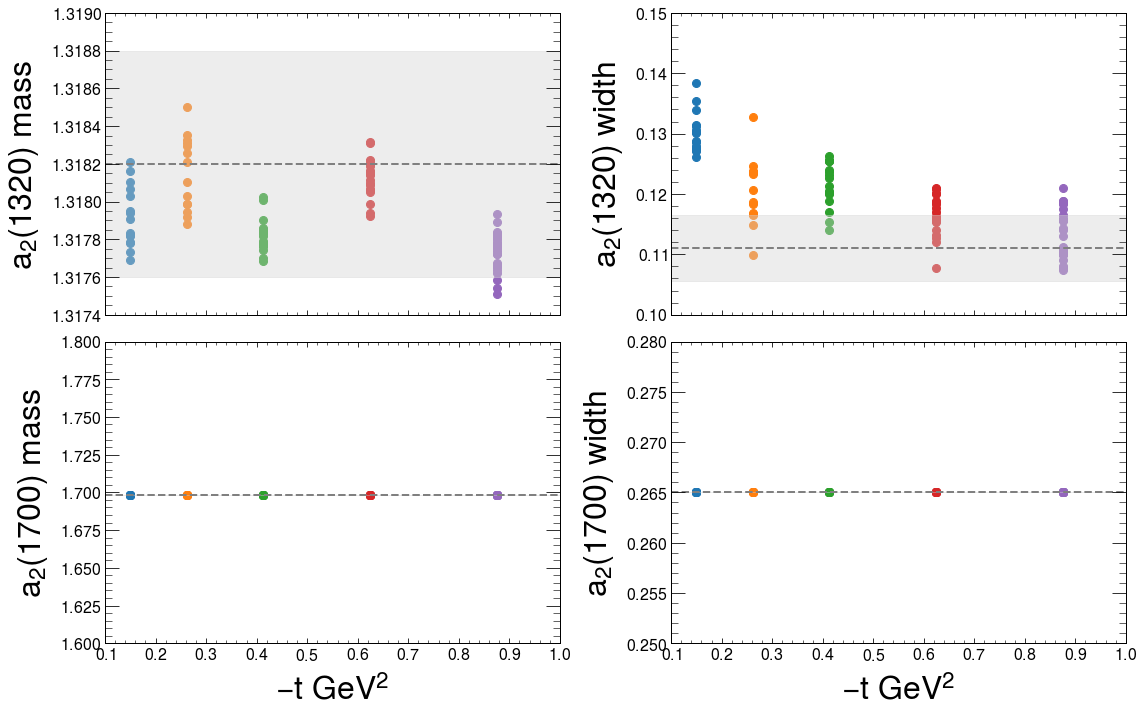

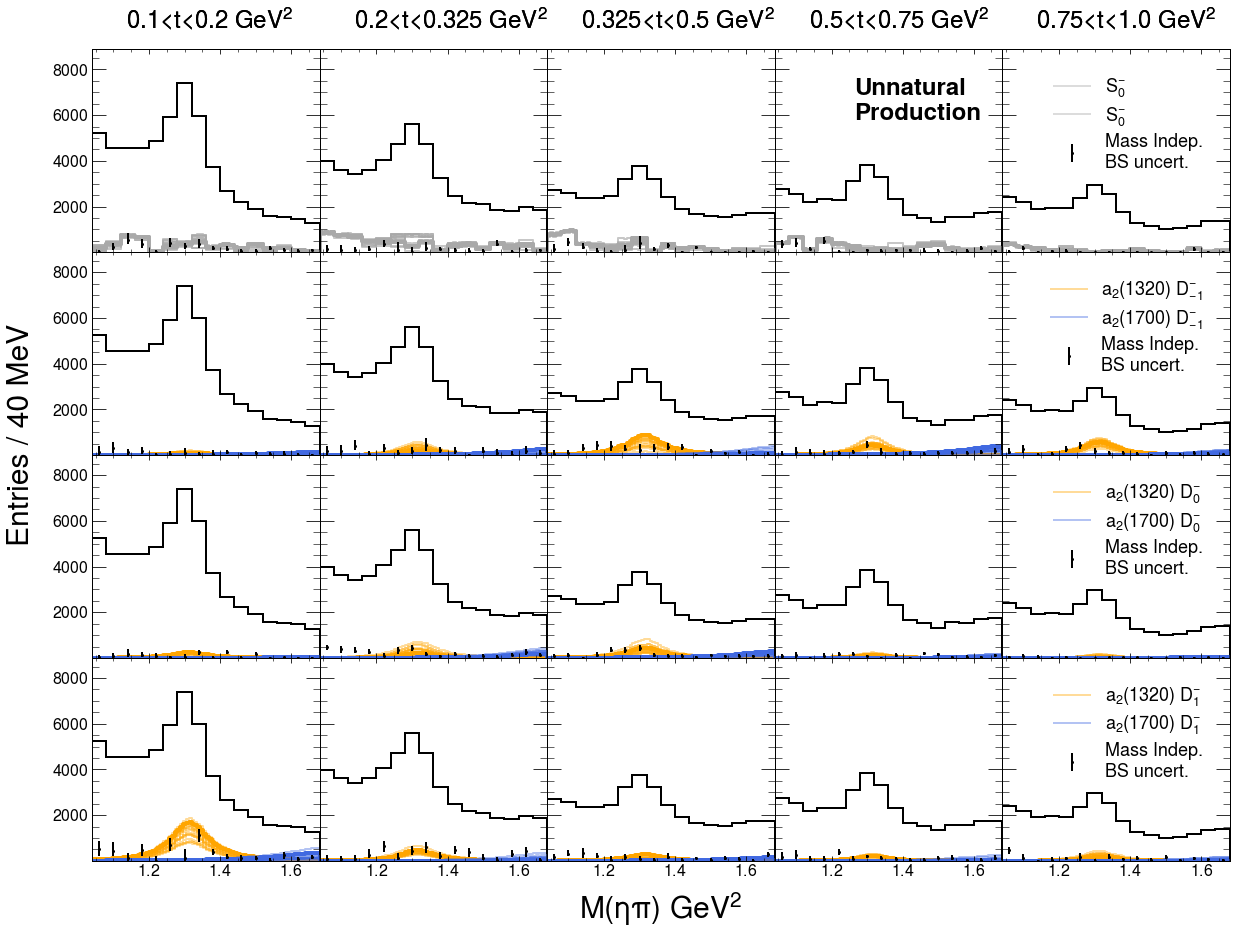

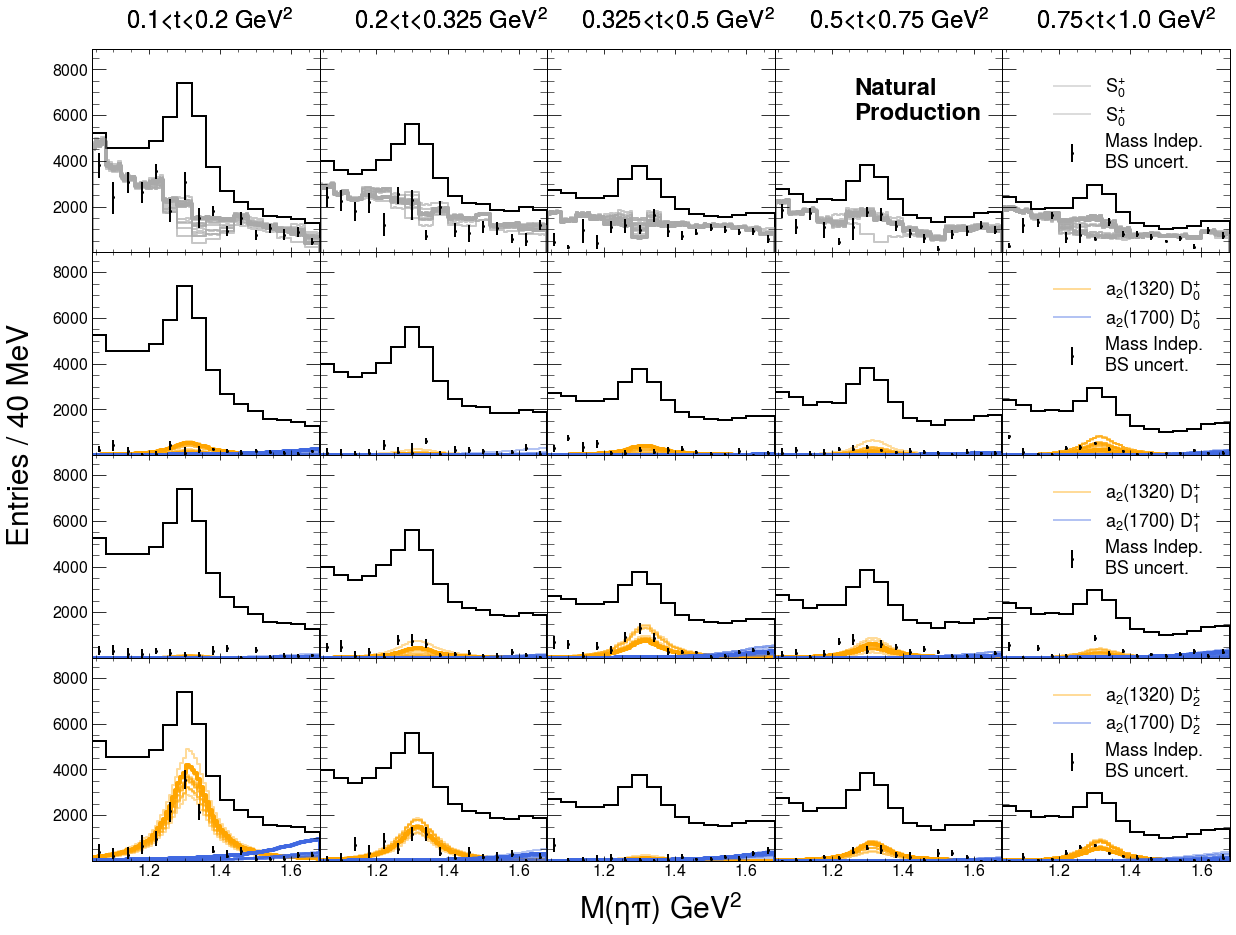

In [1830]:
compareBWparams(md_floc)

# bestFiles=plotWaves(md_floc,mis,"nominal",resonances=["","p"],plotMI=False,histtype='step')
# bestFiles=bestFiles[0]

bestFiles, md_curves = plotWaves(md_floc,mis,"nominal",resonances=["","p"],plotMI=True,plotBest=False,useBSerr_MI=useBSerr_MI,histtype='step')

In [ ]:
# This is also defined a few cell blocks up
def extractNParametersV2(f1):
    a1=f1.split("_")[-1].rstrip().rstrip('/')
    npar1=extractNParameters(f1+"../fitAttempt"+a1+".log")
    return npar1

# extractNParametersV2(bestFiles[0])

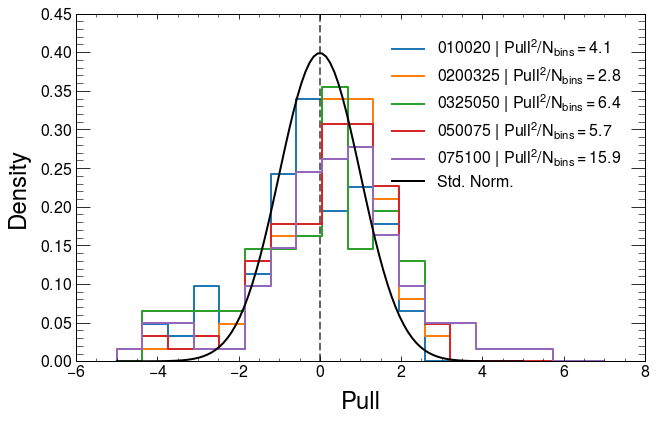

In [1673]:
fig,ax=plt.subplots(1,1,figsize=(10,6))

totalBins=len(mi_mass)*len(mi_waveset_vec)
for t in ts:
    pull_minuit=[]
    pull_bs=[]
    for i,wave in enumerate(mi_waveset_vec):
        # Load mass dependent fit results
        md_df=md_curves[(md_curves.wave==wave)&(md_curves.t==t)]
        md_int=md_df.intensity.values[0]
        md_mass=md_df.mass.values[0]
        md_centers=np.around(md_mass,5)
        # Load mass independent fit results
        mi_df=mis[mis.t==t]
        mi_mass=mi_df.mass.values
        mi_centers=np.around(mi_mass,5)

        predictions=getMatchingValues(mi_centers,md_centers,md_int)
        pull_minuit.append((mi_df[wave]-predictions)/(mi_df[wave+"_err"]))
        pull_bs.append((mi_df[wave]-predictions)/((mi_df[wave+"_err_bsl"]+mi_df[wave+"_err_bsu"])/2)) ## yes its adding ustd and lstd since lstd has implict subtraction

    pull_minuit=np.array(pull_minuit).flatten()
    pull_bs=np.array(pull_bs).flatten()
    sumResidSq=(pull_bs**2).sum()
    avgResidSq=sumResidSq/totalBins

    ### Draw the pulls
    pulls=pull_bs
    pulls=pulls[(pulls>np.quantile(pulls,0.02))*(pulls<np.quantile(pulls,0.98))]
    h=np.histogram(pulls,bins=np.linspace(-5,7,20))
    hep.histplot(h,ax=ax,density=True,label=t+r" | $Pull^2/N_{bins}=$"+f"{avgResidSq:0.1f}",linewidth=2)
#     ax.text(0.65,0.65,label+": {:0.2f}% outliers".format((1-h[0].sum()/len(pulls))*100),size=18,transform=ax.transAxes)
    
#### FINAL OBJECTS
x = np.linspace(-5, 5, 100)
ax.plot(x, stats.norm.pdf(x, 0, 1),c='black',label="Std. Norm.")
ax.set_ylabel("Density",size=24)
ax.set_xlabel("Pull",size=24)
ax.legend()
ax.set_ylim(0)
ax.axvline(0,c='black',linestyle='--',alpha=0.6)

In [1674]:
comparePerformance(
    "/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/v1/",
    "/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/v2/"
    )

============  Negative DeltaLL Favors Alternative   =================
                     t     DeltaLL  DOF       p-value
0    0.1<t<0.2 $GeV^2$  -39.458520  2.0  1.000000e+00
1  0.2<t<0.325 $GeV^2$  131.612211  2.0  0.000000e+00
2  0.325<t<0.5 $GeV^2$   29.483528  2.0  3.960348e-07
3   0.5<t<0.75 $GeV^2$  -30.330858  2.0  1.000000e+00
4   0.75<t<1.0 $GeV^2$   -6.870784  2.0  1.000000e+00


In [1675]:
### EXTRA
a2_br=[0.145,0.012]
a2prime_br=[0.036,0.011]
eta_br=[0.3941,0.002]
pi0_br=[0.98823,0.00034]
a2FullReact_br=combineBR(a2_br,eta_br,pi0_br)
a2primeFullReact_br=combineBR(a2prime_br,eta_br,pi0_br)
target=1.22*1e-9
xerrs=[0.05,0.0625,0.0875,0.125,0.125]
tBinWidths=np.array([0.1,0.125,0.175,0.25,0.25])

flux_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/flux/" 

spring_2017_flux=uproot.open(flux_floc+"flux_30274_31057.root")["tagged_flux"].values[0]
spring_2018_1_flux=uproot.open(flux_floc+"flux_40856_42577.root")["tagged_flux"].values[0]
fall_2018_8_flux=uproot.open(flux_floc+"flux_50677_51768.root")["tagged_flux"].values[0]

spring_2017_flux_amo=uproot.open(flux_floc+"flux_AMO_30274_31057.root")["tagged_flux"].values[0]
spring_2018_1_flux_amo=uproot.open(flux_floc+"flux_AMO_40856_42577.root")["tagged_flux"].values[0]
fall_2018_8_flux_amo=uproot.open(flux_floc+"flux_AMO_50677_51768.root")["tagged_flux"].values[0]

phase1_polarized_flux=spring_2017_flux+spring_2018_1_flux+fall_2018_8_flux-spring_2017_flux_amo-spring_2018_1_flux_amo-fall_2018_8_flux_amo
## For the background leakage studies I estimated around 20e13 flux for phase1 between [8,9]. Around 50% of the data would be [8.2,8.8] and
####  then subtracting out around 3% of that does get me around the right number I show below
print(f"phase1 polarized flux: {phase1_polarized_flux:0.3e}")

phase1 polarized flux: 9.367e+13


In [1676]:
# Old nominal results
# bestFiles=[
#     "/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/fitResults/010020/",
#     "/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/fitResults/0200325/",
#     "/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/fitResults/0325050/",
#     "/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/fitResults/050075/",
#     "/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/fitResults/075100/"
# ]

waveInts_ts, waveIntErrs_ts, totals = loadFitFractions(bestFiles)

In [1677]:
## YIELDS
###### totals of around 450k is about the right number if we manually acceptance correct the yield in t=010020 range. Can look at 
############# drawAmptoolsVar.C program
accCorrected_D=waveInts_ts["D"]*totals
accCorrectedErr_D=waveIntErrs_ts["D"]*totals
accCorrected_Dpos=np.array([v for k,v in waveInts_ts.items() if k[0]=="D" and k[-1]=="+"]).sum(axis=0)*totals
accCorrectedErr_Dpos=np.sqrt(np.power(np.array([v for k,v in waveIntErrs_ts.items() if k[0]=="D" and k[-1]=="+"]),2).sum(axis=0))*totals
accCorrected_Dneg=np.array([v for k,v in waveInts_ts.items() if k[0]=="D" and k[-1]=="-"]).sum(axis=0)*totals
accCorrectedErr_Dneg=np.sqrt(np.power(np.array([v for k,v in waveIntErrs_ts.items() if k[0]=="D" and k[-1]=="-"]),2).sum(axis=0))*totals

### CALCULATE CROSS SECTION
## Polarized flux basically no error bars 
crossSection=accCorrected_D/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
crossSectionErr=crossSection*np.sqrt( 
    (accCorrectedErr_D/accCorrected_D)*(accCorrectedErr_D/accCorrected_D)+
    (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                    )
crossSectionPos=accCorrected_Dpos/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
crossSectionPosErr=crossSectionPos*np.sqrt( 
    (accCorrectedErr_Dpos/accCorrected_Dpos)*(accCorrectedErr_Dpos/accCorrected_Dpos)+
    (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                    )
crossSectionNeg=accCorrected_Dneg/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
crossSectionNegErr=crossSectionNeg*np.sqrt( 
    (accCorrectedErr_Dneg/accCorrected_Dneg)*(accCorrectedErr_Dneg/accCorrected_Dneg)+
    (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                    )

# nb to microbarns
crossSection/=1000
crossSectionErr/=1000
crossSectionPos/=1000
crossSectionPosErr/=1000
crossSectionNeg/=1000
crossSectionNegErr/=1000

parityAsym=(crossSectionPos-crossSectionNeg)/(crossSectionPos+crossSectionNeg)
parityAsymErr=np.sqrt(
    np.power((2*crossSectionNeg/np.power(crossSectionPos+crossSectionNeg,2)*crossSectionPosErr),2)+
    np.power((2*crossSectionPos/np.power(crossSectionPos+crossSectionNeg,2)*crossSectionNegErr),2)
)

In [628]:
baseTheoryFolder="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/theory_pred/"
bapa_theory=pd.read_csv(baseTheoryFolder+"Ten_A2_Fit_85GeV.txt",delimiter=";")
bapa_theory=bapa_theory[["beam asymmetry"]]
bapa_theory.columns=["ba"]

crossSection_theory=pd.read_csv(baseTheoryFolder+"Bands_TMD_A2.txt", delim_whitespace=True, header=None)
crossSection_theory=crossSection_theory.loc[:,[0,7,8,9]]
crossSection_theory.columns=["t","cs_low_err","cs","cs_up_err"]

psig_theory=pd.read_csv(baseTheoryFolder+"Psig_Bands_TMD_A2.txt", delim_whitespace=True, header=None)
psig_theory=psig_theory.loc[:,[7,8,9]]
psig_theory.columns=["pa_low_err","pa","pa_up_err"]

crossSection_theory=pd.concat([crossSection_theory,psig_theory,bapa_theory],axis=1)
crossSection_theory["cs_low_err"]=crossSection_theory["cs"]-crossSection_theory["cs_low_err"]
crossSection_theory["cs_up_err"]=crossSection_theory["cs_up_err"]-crossSection_theory["cs"]
crossSection_theory["pa_low_err"]=crossSection_theory["pa"]-crossSection_theory["pa_low_err"]
crossSection_theory["pa_up_err"]=crossSection_theory["pa_up_err"]-crossSection_theory["pa"]
crossSection_theory=crossSection_theory[(crossSection_theory.t<1)&(crossSection_theory.t>0.1)]

crossSection_theory=crossSection_theory[(crossSection_theory.t<1)&(crossSection_theory.t>0.1)]

In [1679]:
clas_e3545={}
clas_e3545["x"]=[0.3, 0.55, 0.9, 1.3]
clas_e3545["y"]=[0.46039, 0.268257, 0.313349, 0.252332]
clas_e3545["ex"]=[0.1, 0.15, 0.2, 0.2]
clas_e3545["ey"]=[0.0645401, 0.0403087, 0.0313953, 0.0314814]

clas_e4555={}
clas_e4555["x"]=[0.3, 0.55, 0.9, 1.3, 1.75]
clas_e4555["y"]=[0.23734, 0.151709, 0.244609, 0.123577,0.0707616]
clas_e4555["ex"]=[0.1, 0.15, 0.2, 0.2, 0.25]
clas_e4555["ey"]=[0.0647159, 0.0319749, 0.0243778, 0.0177268, 0.0117884]

In [1680]:
runs=["2017_1","2018_1","2018_8"]
ts=["010020","0200325","0325050","050075","075100"]
midts=[0.15,0.2625,0.4125,0.625,0.875]
tLabels=[f"0.1<t<0.2 $GeV^2$", f"0.2<t<0.325 $GeV^2$", f"0.325<t<0.5 $GeV^2$", f"0.5<t<0.75 $GeV^2$", f"0.75<t<1.0 $GeV^2$"]

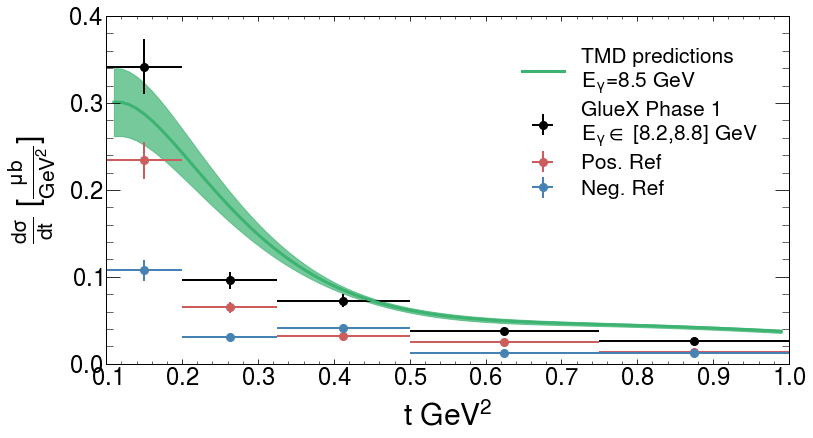

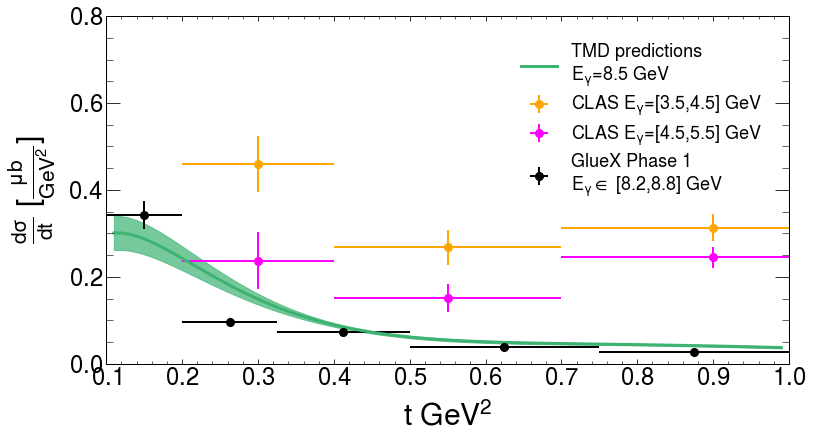

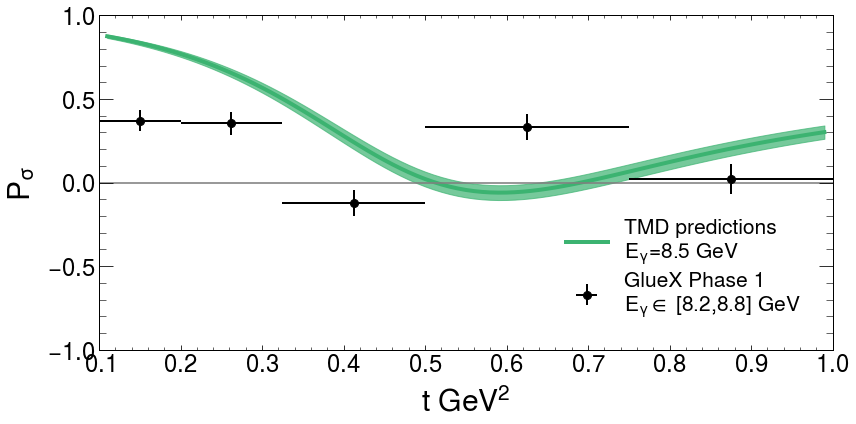

In [1682]:
############################################################
############## GLUEX TOTAL - POS - NEG #####################
############################################################
fig,axes=plt.subplots(1,1,figsize=(12,6))

arbitraryFactor=1
axes.errorbar(midts,crossSection,fmt='o',xerr=xerrs,yerr=crossSectionErr,c='black',
                 label="GlueX Phase 1\n$E_{\gamma}\in$ [8.2,8.8] GeV")
axes.errorbar(midts,crossSectionPos,fmt='o',xerr=xerrs,yerr=crossSectionPosErr,c='indianred',label="Pos. Ref")
axes.errorbar(midts,crossSectionNeg,fmt='o',xerr=xerrs,yerr=crossSectionNegErr,c='steelblue',label="Neg. Ref")
axes.set_xlabel(r"t $GeV^2$",size=30)
axes.set_ylabel(r"$\frac{d\sigma}{dt}$ [$\frac{\mu b}{GeV^2}$]",size=30)
axes.plot(crossSection_theory["t"],crossSection_theory["cs"]/arbitraryFactor,c="mediumseagreen",linewidth=3,
             label="TMD predictions\n$E_{\gamma}$=8.5 GeV")
axes.fill_between(crossSection_theory["t"],
                      (crossSection_theory["cs"]-crossSection_theory["cs_low_err"])/arbitraryFactor,
                      (crossSection_theory["cs"]+crossSection_theory["cs_up_err"])/arbitraryFactor,
                      color="mediumseagreen",alpha=0.7)

axes.tick_params(axis='both',labelsize=24)
axes.set_xlim(0.1)
axes.set_ylim(0,0.4)
axes.ticklabel_format(style='plain')
axes.legend(prop={"size":21})
plt.savefig(ofolder+"a2_xsec.pdf")

############################################################
############## GLUEX TO CLAS #####################
############################################################
fig,axes=plt.subplots(1,1,figsize=(12,6))

axes.errorbar(clas_e3545['x'],clas_e3545['y'],xerr=clas_e3545['ex'],yerr=clas_e3545['ey'],fmt='o',c='orange',label="CLAS $E_{\gamma}$=[3.5,4.5] GeV")
axes.errorbar(clas_e4555['x'],clas_e4555['y'],xerr=clas_e4555['ex'],yerr=clas_e4555['ey'],fmt='o',c='magenta',label="CLAS $E_{\gamma}$=[4.5,5.5] GeV")

arbitraryFactor=1
axes.errorbar(midts,crossSection,fmt='o',xerr=xerrs,yerr=crossSectionErr,c='black',
                 label="GlueX Phase 1\n$E_{\gamma}\in$ [8.2,8.8] GeV")
axes.set_xlabel(r"t $GeV^2$",size=30)
axes.set_ylabel(r"$\frac{d\sigma}{dt}$ [$\frac{\mu b}{GeV^2}$]",size=30)
axes.plot(crossSection_theory["t"],crossSection_theory["cs"]/arbitraryFactor,c="mediumseagreen",linewidth=3,
             label="TMD predictions\n$E_{\gamma}$=8.5 GeV")
axes.fill_between(crossSection_theory["t"],
                      (crossSection_theory["cs"]-crossSection_theory["cs_low_err"])/arbitraryFactor,
                      (crossSection_theory["cs"]+crossSection_theory["cs_up_err"])/arbitraryFactor,
                      color="mediumseagreen",alpha=0.7)

axes.tick_params(axis='both',labelsize=24)
axes.ticklabel_format(style='plain')
axes.legend(prop={"size":18})
axes.set_xlim(0.1,1.0)
axes.set_ylim(0,0.8)
plt.savefig(ofolder+"a2_xsec_clas.pdf")


############################################################
############## PARITY ASYMMETRY #####################
############################################################
fig,axes=plt.subplots(1,1,figsize=(12,6))
axes.errorbar(midts,parityAsym,fmt='o',xerr=xerrs,yerr=parityAsymErr,c='black',label="GlueX Phase 1\n$E_{\gamma}\in$ [8.2,8.8] GeV")
axes.tick_params(axis='both',labelsize=24)
axes.set_xlabel(r"t $GeV^2$",size=30)
axes.set_ylabel(r"$P_{\sigma}$",size=30)
axes.plot(crossSection_theory["t"],crossSection_theory["pa"],c="mediumseagreen",linewidth=4,label="TMD predictions \n$E_{\gamma}$=8.5 GeV")
axes.fill_between(crossSection_theory["t"],
                      (crossSection_theory["pa"]-crossSection_theory["pa_low_err"])/arbitraryFactor,
                      (crossSection_theory["pa"]+crossSection_theory["pa_up_err"])/arbitraryFactor,
                      color="mediumseagreen",alpha=0.7)
axes.tick_params(axis='both',labelsize=24)
axes.set_xlim(0.1)
axes.set_ylim(-1,1)
axes.legend(prop={"size":21})
axes.axhline(0,c='gray',alpha=0.8,linestyle='-')

plt.tight_layout()

plt.savefig(ofolder+"a2_parityAsym.pdf")

# Phase Study

This study shows that calculating the phases with atan2 might not be the best. It can create discontinuities in the phase motion due to atan2 being restricted to [-pi, pi]. the phase difference is not required to have a domain span of 2pi

I think a better way to do it is to normmalize the amps and take i*log(im/re) guarentees domain span of 2pi

In [320]:
#################
# Basic Setup
#################
mi_lowMass=0.8
mi_upMass=1.8
mi_nbins=25
mi_waveset="D0+_D0-_D2+_D2-_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

mi_baseFolder="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/"

mi_df=loadMassIndependentData(mi_baseFolder,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1),keep=[False,False,False])

loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/finalAmps/D0+_D0-_D2+_D2-_S0+_S0-
	t - total entries pre filtering 750
	t - total entries post filtering 750


In [388]:
def getPhaseDiff(method):
    if method==1:
        phaseS0p=np.arctan2(mi_df["ImS0+"],mi_df["ReS0+"])
        phaseD2p=np.arctan2(mi_df["ImD2+"],mi_df["ReD2+"])
        phaseDiff=phaseD2p-phaseS0p
        phaseDiff=np.abs(phaseDiff)
    elif method==2:
        s0p=(mi_df["ReS0+"]+1j*mi_df["ImS0+"])
        d2p=(mi_df["ReD2+"]+1j*mi_df["ImD2+"])
        s0p/=s0p.abs()
        d2p/=d2p.abs()
        phaseDiff=1j*np.log(d2p/s0p)
        phaseDiff=np.real(phaseDiff)
        phaseDiff=np.abs(phaseDiff)
    return phaseDiff

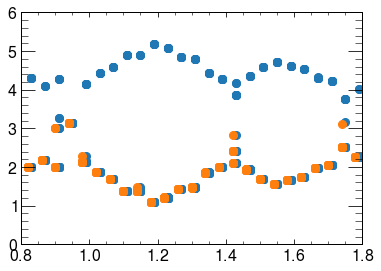

In [390]:
plt.scatter(mi_df.mass+0.01, getPhaseDiff(1),label="nominal")
plt.scatter(mi_df.mass, getPhaseDiff(2),label="new")